In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [3]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [100]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [5]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [6]:
from utils.resources import ClusterReference

crf = ClusterReference("../linguistics/cluster_references/ru-RU/cluster_references.json")

In [7]:
def aggregate_rover(raw_data, rover_class=RoverVotingScheme, treshhold=0.51, cluster_references=None):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    hyps = []
    for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        hyps.append(TextHyp("1", worker_id, text))
    rover = rover_class("1", hyps, cluster_references)
    rover_result = rover.get_result()
    text = " ".join(value for value, score in rover_result if value != "")
    if text == "":
        conf = 0
        text = None
    elif any(score < treshhold for value, score in rover_result):
        conf = 0
        text = None
    else:
        conf = 1
    
    return AggregationResult(text, conf, cost)

In [8]:
class RoverVotingSchemeEmptyDecreased(WordTransitionNetwork):
    def get_result(self):
        result = []
        empty_correction = 0.66
        for edges in self.edges:
            score, _, value = max((len(set(x.sources)) * (1 if x.value else empty_correction), 
                                   len(x.value), 
                                   x.value) for x in edges.values())
            score = float(score)
            if value == "":
                score /= empty_correction
            score /= sum(len(set(x.sources)) for x in edges.values())
            result.append((value, score))
        return result

In [9]:
MAX_NUM_ANSWERS = 10
NO_SOURCE_ID = "NO WORKER"


def extract_prefeatures(data, field_name):
    prefeatures = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(dict)))
    for row in data:
        toloka_answers = sorted(row[field_name], key=lambda x: x["submit_ts"])
        id_ = row["mds_key"]
        for cost in range(1, len(toloka_answers) + 1):
            hyps = []
            for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in toloka_answers[:cost]]:
                if speech != "BAD" and text:
                    text = text.lower().replace('ё', 'е')
                else:
                    text = ""
                hyps.append(TextHyp(id_, worker_id, text))
            wtn = WordTransitionNetwork(object_id=id_, hypotheses=hyps)
            ref_text = row.get("text", "")
            ref = WordTransitionNetwork(object_id=id_, hypotheses=[TextHyp(id_, "reference", ref_text)])
            alignment, actions = wtn._align(wtn.edges, ref.edges, wtn.hypotheses_sources, ref.hypotheses_sources)
            expanded_alignment = []  # формируем дополнительные ребра на местах где не было вставок
            skip_next = False
            for item, action in zip(alignment, actions): 
                if action == "I":
                    if skip_next:
                        continue  # берем только первую вставку из нескольких так как они индентичны
                    expanded_alignment.append(item)
                    skip_next = True
                elif skip_next:
                    expanded_alignment.append(item)
                    skip_next = False
                else:
                    expanded_alignment += [
                        {"": WTNEdge("", 
                                     None, 
                                     wtn.hypotheses_sources + ["reference"], 
                                     [None for _ in wtn.hypotheses_sources + ["reference"]])}, item
                    ]
            if not skip_next:
                expanded_alignment.append(
                    {
                        "": WTNEdge(
                            "", 
                            None, 
                            wtn.hypotheses_sources + ["reference"], 
                            [None for _ in wtn.hypotheses_sources + ["reference"]]
                        )
                    }
                )
            for position, edges in enumerate(expanded_alignment):
                correct_word = None
                fixed_edges = {}
                for word, edge in edges.items():
                    if "reference" in edge.sources:
                        edge = WTNEdge(edge[0], edge[1], edge[2][:-1], edge[3][:-1])
                        assert "reference" not in edge.sources
                        assert correct_word is None
                        correct_word = edge.value
                    if len(edge.sources) != 0:
                        fixed_edges[word] = edge
                assert correct_word is not None
                all_submissions = [(edge.value, edge.score, source, original_position)
                                   for edge in fixed_edges.values() 
                                   for source, original_position in zip(edge.sources, edge.original_positions) 
                                   ]
                for word in fixed_edges:
                    submissions_sorted = sorted(
                        (calculate_wer(list(word), list(sub[0]))[1], *sub) for sub in all_submissions
                    )
                    prefeatures[id_][cost][position][word] = (submissions_sorted, word == correct_word)
    return prefeatures    

In [10]:
import re

eng_letter = re.compile("[a-zA-Z]")

def count_eng_letters(text):
    x = re.findall(eng_letter, text)
    return len(x)

In [11]:
def get_word_features(word):
    if word is None:
        return [-100] * 3
    result = [
        len(word), count_eng_letters(word), len(word) - count_eng_letters(word)
    ]
    return result

def get_word_to_word_features(word, hyp_word):
    if word is None or hyp_word is None:
        return [-100] * 3
    result = [
        calculate_wer(list(word), list(hyp_word))[1], 
        len(word) - len(hyp_word),
        count_eng_letters(word) - count_eng_letters(hyp_word)
    ]
    return result

In [12]:
def extract_task_features(row):
    mds_key = row["mds_key"]
    return []

In [13]:
def extract_source_features(data, field_name): # , predresult)
    N_FEATURES = 8
    sources_stats = collections.defaultdict(lambda: np.zeros(N_FEATURES, dtype=np.int32))
    for row in data:
        mds_key = row["mds_key"]
        texts = []
        for cost, assignment in enumerate(sorted(row[field_name], key=lambda x: x["submit_ts"])):
            cost += 1
            source_id = assignment["worker_id"]
            text = assignment["text"]
            texts.append(text)
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            for i in range(cost, MAX_NUM_ANSWERS + 1):
                sources_stats[(source_id, i)] += np.array([
                                                      1, 
                                                      text == "", 
                                                      len(text.split()), 
                                                      len(text), 
                                                      number_of_speakers=="many", 
                                                      count_eng_letters(text),
                                                      count_eng_letters(text) != 0,
                                                      sum(1 for x in texts if x == text)
                                                     ])
    sources_stats[NO_SOURCE_ID] = np.full(fill_value=-1, shape=N_FEATURES)
    for i, value in sources_stats.items():
        n = value[0]
        value = np.concatenate((
            np.array([n], dtype=np.float),
            value[1:] / n
        ))
        sources_stats[i] = list(value)
    for i in range(1, MAX_NUM_ANSWERS + 1):
        sources_stats[(NO_SOURCE_ID, i)] = [-1] * N_FEATURES
    return dict(sources_stats)

In [14]:
def count_eng_words(text):
    return sum(1 for word in text.split() if count_eng_letters(word) != 0)

In [15]:
def extract_task_and_source_features(data, field_name):
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        assignments = sorted(row[field_name], key=lambda x: x["submit_ts"])
        for cost in range(1, len(assignments) + 1):
            texts = []
            for assignment in assignments[:cost]:
                text = assignment["text"]
                speech = assignment["speech"]
                if speech != "BAD" and text:
                    text = text.lower().replace('ё', 'е')
                else:
                    text = ""
                texts.append(text)
            for assignment, text in zip(assignments[:cost], texts):
                source_id = assignment["worker_id"]
                speech = assignment["speech"]
                number_of_speakers = assignment["number_of_speakers"]
                submit_ts = assignment["submit_ts"]
                stats[(mds_key, source_id, cost)] = [
                    len(text.split()), 
                    len(text), 
                    number_of_speakers == "many", 
                    count_eng_letters(text),
                    count_eng_words(text),
                    sum(1 for x in texts if x == text)
                ]
        
        for i in range(1, MAX_NUM_ANSWERS + 1):
            stats[(mds_key, NO_SOURCE_ID, i)] = [
                    -1, 
                    -1, 
                    -1, 
                    -1,
                    -1,
                    -1
                ]
    return stats

In [16]:
def extract_task_and_source_word_features(data, field_name):
    N_FEATURES = 5
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        for assignment in row[field_name]:
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            text = text.split()
            text_len = len(text)
            for pos, word in enumerate(text):
                stats[(mds_key, source_id, pos)] = [
                    pos, 
                    len(text[pos-1]) if pos > 0 else -1, 
                    len(text[pos+1]) if pos + 1 < text_len else -1,
                    count_eng_letters(text[pos-1]) if pos > 0 else -1, 
                    count_eng_letters(text[pos+1]) if pos + 1 < text_len else -1
                ]
            stats[(mds_key, source_id, None)] = [-1] * N_FEATURES
        stats[(mds_key, NO_SOURCE_ID, None)] = [-1] * N_FEATURES
    return stats

In [17]:
def extract_features(data, field_name):
    task_features = dict((row["mds_key"], extract_task_features(row)) for row in data)
    source_features = extract_source_features(data, field_name)
    task_and_source_features = extract_task_and_source_features(data, field_name)
    task_and_source_word_features = extract_task_and_source_word_features(data, field_name)
    
    features = extract_prefeatures(data, field_name)
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    prefeature, y = item3
                    prefeature += [(-1, None, None, NO_SOURCE_ID, None) for _ in range(MAX_NUM_ANSWERS - len(prefeature))]
                    if len(prefeature) != MAX_NUM_ANSWERS:
                        print(prefeature)
                        assert False
                    x = [position] + task_features[task_id] + get_word_features(word) 
                    for edit_distance, hyp_word, score, source_id, original_position in prefeature:
                        x += get_word_features(hyp_word)
                        x += get_word_to_word_features(word, hyp_word)
                        x += source_features[(source_id, cost)]
                        x += task_and_source_features[(task_id, source_id, cost)]
                        x += task_and_source_word_features[(task_id, source_id, original_position)]
                    features[task_id][cost][position][word] = (x, y)
    return features

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

In [19]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [20]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [21]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if (row['text'] != '' and hyp == ''):
            false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    false_empty /= aggregated
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [22]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [23]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [24]:
data_assistant_train = yt.read_table("//home/voice/vklyukin/va-893/assistant/train")
data_assistant_test = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_valid = list(data_assistant_train) + list(data_assistant_test)

In [25]:
len(data_assistant_valid)

7022

In [26]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_assistant_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833

ROVER:
Aggregated: 69.7074%
WER: 9.9717%
Accuracy: 74.3621%
Mean overlap: 3.833


In [27]:
data_assistant_train = yt.read_table("//home/voice/vklyukin/va-893/assistant/train")
data_assistant_test = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_train = list(data_assistant_train)
data_assistant_test = list(data_assistant_test)
for row in data_assistant_test:
    if 'text' in row:
        del row['text']

In [28]:
data_assistant_new_test_features = extract_features(data_assistant_test, 'toloka_results')

In [29]:
data_assistant_new_train_features = extract_features(data_assistant_train, 'toloka_results')

In [30]:
data_assistant_test_valid = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_test_valid = list(data_assistant_test_valid)

In [31]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833

ROVER:
Aggregated: 69.7074%
WER: 9.9717%
Accuracy: 74.3621%
Mean overlap: 3.833


In [32]:
X_train, Y_train = convert_to_array(data_assistant_new_train_features)

In [33]:
clf_new = CatBoostClassifier(iterations=19000, depth=6, thread_count=26, random_seed=42)
clf_new.fit(X_train, Y_train)

Learning rate set to 0.006743
0:	learn: 0.6839108	total: 228ms	remaining: 1h 12m 12s
1:	learn: 0.6749854	total: 376ms	remaining: 59m 32s
2:	learn: 0.6662095	total: 555ms	remaining: 58m 33s
3:	learn: 0.6575844	total: 719ms	remaining: 56m 55s
4:	learn: 0.6490770	total: 893ms	remaining: 56m 32s
5:	learn: 0.6409922	total: 1.08s	remaining: 56m 48s
6:	learn: 0.6328550	total: 1.25s	remaining: 56m 29s
7:	learn: 0.6249659	total: 1.43s	remaining: 56m 44s
8:	learn: 0.6172107	total: 1.6s	remaining: 56m 17s
9:	learn: 0.6094894	total: 1.76s	remaining: 55m 51s
10:	learn: 0.6019506	total: 1.94s	remaining: 55m 46s
11:	learn: 0.5945699	total: 2.1s	remaining: 55m 25s
12:	learn: 0.5875036	total: 2.26s	remaining: 54m 58s
13:	learn: 0.5803056	total: 2.43s	remaining: 54m 54s
14:	learn: 0.5735620	total: 2.59s	remaining: 54m 43s
15:	learn: 0.5666930	total: 2.76s	remaining: 54m 38s
16:	learn: 0.5597845	total: 2.93s	remaining: 54m 31s
17:	learn: 0.5531292	total: 3.09s	remaining: 54m 19s
18:	learn: 0.5468145	tota

155:	learn: 0.2404675	total: 26.4s	remaining: 53m 10s
156:	learn: 0.2399291	total: 26.6s	remaining: 53m 8s
157:	learn: 0.2394153	total: 26.7s	remaining: 53m 7s
158:	learn: 0.2389372	total: 26.9s	remaining: 53m 5s
159:	learn: 0.2384614	total: 27.1s	remaining: 53m 5s
160:	learn: 0.2379780	total: 27.2s	remaining: 53m 2s
161:	learn: 0.2375067	total: 27.4s	remaining: 53m
162:	learn: 0.2369908	total: 27.5s	remaining: 53m 1s
163:	learn: 0.2364830	total: 27.7s	remaining: 53m 1s
164:	learn: 0.2360223	total: 27.9s	remaining: 53m 3s
165:	learn: 0.2355957	total: 28.1s	remaining: 53m 3s
166:	learn: 0.2351372	total: 28.2s	remaining: 52m 59s
167:	learn: 0.2346951	total: 28.3s	remaining: 52m 57s
168:	learn: 0.2342514	total: 28.5s	remaining: 52m 57s
169:	learn: 0.2338031	total: 28.7s	remaining: 52m 56s
170:	learn: 0.2333643	total: 28.9s	remaining: 52m 57s
171:	learn: 0.2329621	total: 29s	remaining: 52m 57s
172:	learn: 0.2325571	total: 29.2s	remaining: 52m 58s
173:	learn: 0.2321542	total: 29.4s	remainin

309:	learn: 0.2051224	total: 52.5s	remaining: 52m 47s
310:	learn: 0.2050470	total: 52.7s	remaining: 52m 46s
311:	learn: 0.2049583	total: 52.9s	remaining: 52m 45s
312:	learn: 0.2048658	total: 53s	remaining: 52m 45s
313:	learn: 0.2047959	total: 53.2s	remaining: 52m 44s
314:	learn: 0.2047310	total: 53.3s	remaining: 52m 44s
315:	learn: 0.2046523	total: 53.5s	remaining: 52m 42s
316:	learn: 0.2045678	total: 53.7s	remaining: 52m 43s
317:	learn: 0.2044832	total: 53.8s	remaining: 52m 43s
318:	learn: 0.2043913	total: 54s	remaining: 52m 43s
319:	learn: 0.2043124	total: 54.2s	remaining: 52m 43s
320:	learn: 0.2042355	total: 54.4s	remaining: 52m 44s
321:	learn: 0.2041565	total: 54.5s	remaining: 52m 43s
322:	learn: 0.2040484	total: 54.7s	remaining: 52m 41s
323:	learn: 0.2039445	total: 54.8s	remaining: 52m 40s
324:	learn: 0.2038513	total: 55s	remaining: 52m 38s
325:	learn: 0.2037725	total: 55.1s	remaining: 52m 37s
326:	learn: 0.2037100	total: 55.3s	remaining: 52m 36s
327:	learn: 0.2036295	total: 55.4s

461:	learn: 0.1964700	total: 1m 18s	remaining: 52m 39s
462:	learn: 0.1964430	total: 1m 18s	remaining: 52m 40s
463:	learn: 0.1964058	total: 1m 19s	remaining: 52m 40s
464:	learn: 0.1963606	total: 1m 19s	remaining: 52m 41s
465:	learn: 0.1963287	total: 1m 19s	remaining: 52m 41s
466:	learn: 0.1962775	total: 1m 19s	remaining: 52m 42s
467:	learn: 0.1962373	total: 1m 19s	remaining: 52m 42s
468:	learn: 0.1962123	total: 1m 20s	remaining: 52m 42s
469:	learn: 0.1961636	total: 1m 20s	remaining: 52m 42s
470:	learn: 0.1961220	total: 1m 20s	remaining: 52m 42s
471:	learn: 0.1960813	total: 1m 20s	remaining: 52m 41s
472:	learn: 0.1960514	total: 1m 20s	remaining: 52m 41s
473:	learn: 0.1960236	total: 1m 20s	remaining: 52m 41s
474:	learn: 0.1959964	total: 1m 21s	remaining: 52m 40s
475:	learn: 0.1959725	total: 1m 21s	remaining: 52m 39s
476:	learn: 0.1959414	total: 1m 21s	remaining: 52m 39s
477:	learn: 0.1958937	total: 1m 21s	remaining: 52m 39s
478:	learn: 0.1958585	total: 1m 21s	remaining: 52m 38s
479:	learn

611:	learn: 0.1925344	total: 1m 44s	remaining: 52m 20s
612:	learn: 0.1925258	total: 1m 44s	remaining: 52m 21s
613:	learn: 0.1925083	total: 1m 44s	remaining: 52m 20s
614:	learn: 0.1924824	total: 1m 45s	remaining: 52m 20s
615:	learn: 0.1924671	total: 1m 45s	remaining: 52m 19s
616:	learn: 0.1924517	total: 1m 45s	remaining: 52m 18s
617:	learn: 0.1924346	total: 1m 45s	remaining: 52m 18s
618:	learn: 0.1924180	total: 1m 45s	remaining: 52m 18s
619:	learn: 0.1923830	total: 1m 45s	remaining: 52m 18s
620:	learn: 0.1923497	total: 1m 46s	remaining: 52m 18s
621:	learn: 0.1923324	total: 1m 46s	remaining: 52m 18s
622:	learn: 0.1923203	total: 1m 46s	remaining: 52m 18s
623:	learn: 0.1923060	total: 1m 46s	remaining: 52m 17s
624:	learn: 0.1922964	total: 1m 46s	remaining: 52m 17s
625:	learn: 0.1922826	total: 1m 46s	remaining: 52m 16s
626:	learn: 0.1922686	total: 1m 47s	remaining: 52m 15s
627:	learn: 0.1922518	total: 1m 47s	remaining: 52m 15s
628:	learn: 0.1922370	total: 1m 47s	remaining: 52m 14s
629:	learn

763:	learn: 0.1901721	total: 2m 10s	remaining: 51m 46s
764:	learn: 0.1901604	total: 2m 10s	remaining: 51m 46s
765:	learn: 0.1901497	total: 2m 10s	remaining: 51m 46s
766:	learn: 0.1901372	total: 2m 10s	remaining: 51m 46s
767:	learn: 0.1901242	total: 2m 10s	remaining: 51m 46s
768:	learn: 0.1901106	total: 2m 11s	remaining: 51m 47s
769:	learn: 0.1900916	total: 2m 11s	remaining: 51m 47s
770:	learn: 0.1900848	total: 2m 11s	remaining: 51m 47s
771:	learn: 0.1900747	total: 2m 11s	remaining: 51m 46s
772:	learn: 0.1900645	total: 2m 11s	remaining: 51m 45s
773:	learn: 0.1900533	total: 2m 11s	remaining: 51m 46s
774:	learn: 0.1900435	total: 2m 12s	remaining: 51m 46s
775:	learn: 0.1900353	total: 2m 12s	remaining: 51m 45s
776:	learn: 0.1900196	total: 2m 12s	remaining: 51m 45s
777:	learn: 0.1900023	total: 2m 12s	remaining: 51m 44s
778:	learn: 0.1899964	total: 2m 12s	remaining: 51m 43s
779:	learn: 0.1899796	total: 2m 12s	remaining: 51m 43s
780:	learn: 0.1899662	total: 2m 13s	remaining: 51m 43s
781:	learn

914:	learn: 0.1884941	total: 2m 34s	remaining: 51m 3s
915:	learn: 0.1884795	total: 2m 35s	remaining: 51m 3s
916:	learn: 0.1884718	total: 2m 35s	remaining: 51m 2s
917:	learn: 0.1884616	total: 2m 35s	remaining: 51m 2s
918:	learn: 0.1884526	total: 2m 35s	remaining: 51m 1s
919:	learn: 0.1884360	total: 2m 35s	remaining: 51m 1s
920:	learn: 0.1884285	total: 2m 35s	remaining: 51m 1s
921:	learn: 0.1884146	total: 2m 36s	remaining: 51m
922:	learn: 0.1884048	total: 2m 36s	remaining: 51m
923:	learn: 0.1883977	total: 2m 36s	remaining: 51m
924:	learn: 0.1883914	total: 2m 36s	remaining: 51m
925:	learn: 0.1883782	total: 2m 36s	remaining: 51m
926:	learn: 0.1883733	total: 2m 36s	remaining: 50m 59s
927:	learn: 0.1883619	total: 2m 37s	remaining: 50m 59s
928:	learn: 0.1883543	total: 2m 37s	remaining: 50m 58s
929:	learn: 0.1883431	total: 2m 37s	remaining: 50m 58s
930:	learn: 0.1883347	total: 2m 37s	remaining: 50m 58s
931:	learn: 0.1883209	total: 2m 37s	remaining: 50m 58s
932:	learn: 0.1883070	total: 2m 37s	r

1063:	learn: 0.1871411	total: 2m 59s	remaining: 50m 26s
1064:	learn: 0.1871240	total: 2m 59s	remaining: 50m 25s
1065:	learn: 0.1871170	total: 2m 59s	remaining: 50m 25s
1066:	learn: 0.1871073	total: 2m 59s	remaining: 50m 24s
1067:	learn: 0.1871008	total: 3m	remaining: 50m 24s
1068:	learn: 0.1870890	total: 3m	remaining: 50m 23s
1069:	learn: 0.1870843	total: 3m	remaining: 50m 22s
1070:	learn: 0.1870804	total: 3m	remaining: 50m 22s
1071:	learn: 0.1870761	total: 3m	remaining: 50m 21s
1072:	learn: 0.1870594	total: 3m	remaining: 50m 21s
1073:	learn: 0.1870563	total: 3m 1s	remaining: 50m 21s
1074:	learn: 0.1870499	total: 3m 1s	remaining: 50m 21s
1075:	learn: 0.1870399	total: 3m 1s	remaining: 50m 21s
1076:	learn: 0.1870330	total: 3m 1s	remaining: 50m 21s
1077:	learn: 0.1870257	total: 3m 1s	remaining: 50m 20s
1078:	learn: 0.1870168	total: 3m 1s	remaining: 50m 20s
1079:	learn: 0.1870099	total: 3m 2s	remaining: 50m 20s
1080:	learn: 0.1869904	total: 3m 2s	remaining: 50m 20s
1081:	learn: 0.1869839	t

1213:	learn: 0.1859304	total: 3m 24s	remaining: 50m 1s
1214:	learn: 0.1859255	total: 3m 25s	remaining: 50m 1s
1215:	learn: 0.1859187	total: 3m 25s	remaining: 50m 1s
1216:	learn: 0.1859131	total: 3m 25s	remaining: 50m 1s
1217:	learn: 0.1859074	total: 3m 25s	remaining: 50m 1s
1218:	learn: 0.1859014	total: 3m 25s	remaining: 50m
1219:	learn: 0.1858964	total: 3m 25s	remaining: 50m
1220:	learn: 0.1858893	total: 3m 26s	remaining: 50m
1221:	learn: 0.1858850	total: 3m 26s	remaining: 50m
1222:	learn: 0.1858801	total: 3m 26s	remaining: 50m
1223:	learn: 0.1858710	total: 3m 26s	remaining: 49m 59s
1224:	learn: 0.1858655	total: 3m 26s	remaining: 49m 59s
1225:	learn: 0.1858614	total: 3m 26s	remaining: 49m 59s
1226:	learn: 0.1858541	total: 3m 27s	remaining: 49m 58s
1227:	learn: 0.1858441	total: 3m 27s	remaining: 49m 58s
1228:	learn: 0.1858360	total: 3m 27s	remaining: 49m 58s
1229:	learn: 0.1858312	total: 3m 27s	remaining: 49m 58s
1230:	learn: 0.1858245	total: 3m 27s	remaining: 49m 58s
1231:	learn: 0.18

1360:	learn: 0.1849920	total: 3m 48s	remaining: 49m 24s
1361:	learn: 0.1849893	total: 3m 48s	remaining: 49m 24s
1362:	learn: 0.1849863	total: 3m 49s	remaining: 49m 24s
1363:	learn: 0.1849797	total: 3m 49s	remaining: 49m 23s
1364:	learn: 0.1849711	total: 3m 49s	remaining: 49m 23s
1365:	learn: 0.1849653	total: 3m 49s	remaining: 49m 23s
1366:	learn: 0.1849619	total: 3m 49s	remaining: 49m 22s
1367:	learn: 0.1849551	total: 3m 49s	remaining: 49m 22s
1368:	learn: 0.1849505	total: 3m 50s	remaining: 49m 22s
1369:	learn: 0.1849447	total: 3m 50s	remaining: 49m 22s
1370:	learn: 0.1849364	total: 3m 50s	remaining: 49m 22s
1371:	learn: 0.1849278	total: 3m 50s	remaining: 49m 21s
1372:	learn: 0.1849246	total: 3m 50s	remaining: 49m 21s
1373:	learn: 0.1849185	total: 3m 50s	remaining: 49m 21s
1374:	learn: 0.1849129	total: 3m 51s	remaining: 49m 20s
1375:	learn: 0.1849056	total: 3m 51s	remaining: 49m 20s
1376:	learn: 0.1849031	total: 3m 51s	remaining: 49m 20s
1377:	learn: 0.1848973	total: 3m 51s	remaining: 

1509:	learn: 0.1841120	total: 4m 13s	remaining: 48m 51s
1510:	learn: 0.1841004	total: 4m 13s	remaining: 48m 51s
1511:	learn: 0.1840960	total: 4m 13s	remaining: 48m 50s
1512:	learn: 0.1840933	total: 4m 13s	remaining: 48m 50s
1513:	learn: 0.1840813	total: 4m 13s	remaining: 48m 49s
1514:	learn: 0.1840720	total: 4m 13s	remaining: 48m 49s
1515:	learn: 0.1840625	total: 4m 14s	remaining: 48m 49s
1516:	learn: 0.1840598	total: 4m 14s	remaining: 48m 49s
1517:	learn: 0.1840574	total: 4m 14s	remaining: 48m 49s
1518:	learn: 0.1840530	total: 4m 14s	remaining: 48m 49s
1519:	learn: 0.1840489	total: 4m 14s	remaining: 48m 48s
1520:	learn: 0.1840454	total: 4m 14s	remaining: 48m 48s
1521:	learn: 0.1840416	total: 4m 14s	remaining: 48m 48s
1522:	learn: 0.1840395	total: 4m 15s	remaining: 48m 47s
1523:	learn: 0.1840343	total: 4m 15s	remaining: 48m 47s
1524:	learn: 0.1840288	total: 4m 15s	remaining: 48m 47s
1525:	learn: 0.1840243	total: 4m 15s	remaining: 48m 46s
1526:	learn: 0.1840176	total: 4m 15s	remaining: 

1657:	learn: 0.1832964	total: 4m 37s	remaining: 48m 19s
1658:	learn: 0.1832906	total: 4m 37s	remaining: 48m 19s
1659:	learn: 0.1832834	total: 4m 37s	remaining: 48m 19s
1660:	learn: 0.1832797	total: 4m 37s	remaining: 48m 19s
1661:	learn: 0.1832768	total: 4m 37s	remaining: 48m 18s
1662:	learn: 0.1832718	total: 4m 38s	remaining: 48m 18s
1663:	learn: 0.1832669	total: 4m 38s	remaining: 48m 18s
1664:	learn: 0.1832641	total: 4m 38s	remaining: 48m 18s
1665:	learn: 0.1832574	total: 4m 38s	remaining: 48m 18s
1666:	learn: 0.1832528	total: 4m 38s	remaining: 48m 18s
1667:	learn: 0.1832493	total: 4m 38s	remaining: 48m 18s
1668:	learn: 0.1832444	total: 4m 39s	remaining: 48m 18s
1669:	learn: 0.1832410	total: 4m 39s	remaining: 48m 17s
1670:	learn: 0.1832321	total: 4m 39s	remaining: 48m 17s
1671:	learn: 0.1832251	total: 4m 39s	remaining: 48m 17s
1672:	learn: 0.1832225	total: 4m 39s	remaining: 48m 17s
1673:	learn: 0.1832190	total: 4m 39s	remaining: 48m 17s
1674:	learn: 0.1832141	total: 4m 40s	remaining: 

1806:	learn: 0.1825328	total: 5m 1s	remaining: 47m 47s
1807:	learn: 0.1825278	total: 5m 1s	remaining: 47m 47s
1808:	learn: 0.1825213	total: 5m 1s	remaining: 47m 46s
1809:	learn: 0.1825160	total: 5m 1s	remaining: 47m 46s
1810:	learn: 0.1825116	total: 5m 2s	remaining: 47m 46s
1811:	learn: 0.1825090	total: 5m 2s	remaining: 47m 45s
1812:	learn: 0.1825041	total: 5m 2s	remaining: 47m 45s
1813:	learn: 0.1825005	total: 5m 2s	remaining: 47m 45s
1814:	learn: 0.1824950	total: 5m 2s	remaining: 47m 45s
1815:	learn: 0.1824911	total: 5m 2s	remaining: 47m 44s
1816:	learn: 0.1824887	total: 5m 2s	remaining: 47m 44s
1817:	learn: 0.1824832	total: 5m 3s	remaining: 47m 44s
1818:	learn: 0.1824756	total: 5m 3s	remaining: 47m 44s
1819:	learn: 0.1824726	total: 5m 3s	remaining: 47m 43s
1820:	learn: 0.1824686	total: 5m 3s	remaining: 47m 43s
1821:	learn: 0.1824589	total: 5m 3s	remaining: 47m 43s
1822:	learn: 0.1824542	total: 5m 3s	remaining: 47m 43s
1823:	learn: 0.1824508	total: 5m 4s	remaining: 47m 42s
1824:	lear

1955:	learn: 0.1817715	total: 5m 25s	remaining: 47m 18s
1956:	learn: 0.1817643	total: 5m 25s	remaining: 47m 18s
1957:	learn: 0.1817595	total: 5m 26s	remaining: 47m 18s
1958:	learn: 0.1817520	total: 5m 26s	remaining: 47m 18s
1959:	learn: 0.1817458	total: 5m 26s	remaining: 47m 18s
1960:	learn: 0.1817388	total: 5m 26s	remaining: 47m 17s
1961:	learn: 0.1817360	total: 5m 26s	remaining: 47m 17s
1962:	learn: 0.1817310	total: 5m 26s	remaining: 47m 16s
1963:	learn: 0.1817266	total: 5m 27s	remaining: 47m 16s
1964:	learn: 0.1817223	total: 5m 27s	remaining: 47m 16s
1965:	learn: 0.1817193	total: 5m 27s	remaining: 47m 15s
1966:	learn: 0.1817137	total: 5m 27s	remaining: 47m 15s
1967:	learn: 0.1817092	total: 5m 27s	remaining: 47m 15s
1968:	learn: 0.1817049	total: 5m 27s	remaining: 47m 15s
1969:	learn: 0.1817028	total: 5m 27s	remaining: 47m 15s
1970:	learn: 0.1816945	total: 5m 28s	remaining: 47m 15s
1971:	learn: 0.1816876	total: 5m 28s	remaining: 47m 15s
1972:	learn: 0.1816849	total: 5m 28s	remaining: 

2103:	learn: 0.1810544	total: 5m 49s	remaining: 46m 49s
2104:	learn: 0.1810503	total: 5m 50s	remaining: 46m 49s
2105:	learn: 0.1810472	total: 5m 50s	remaining: 46m 49s
2106:	learn: 0.1810437	total: 5m 50s	remaining: 46m 49s
2107:	learn: 0.1810389	total: 5m 50s	remaining: 46m 48s
2108:	learn: 0.1810353	total: 5m 50s	remaining: 46m 48s
2109:	learn: 0.1810242	total: 5m 50s	remaining: 46m 48s
2110:	learn: 0.1810185	total: 5m 51s	remaining: 46m 48s
2111:	learn: 0.1810145	total: 5m 51s	remaining: 46m 48s
2112:	learn: 0.1810124	total: 5m 51s	remaining: 46m 47s
2113:	learn: 0.1810080	total: 5m 51s	remaining: 46m 47s
2114:	learn: 0.1810058	total: 5m 51s	remaining: 46m 47s
2115:	learn: 0.1810019	total: 5m 51s	remaining: 46m 46s
2116:	learn: 0.1809938	total: 5m 51s	remaining: 46m 46s
2117:	learn: 0.1809829	total: 5m 52s	remaining: 46m 47s
2118:	learn: 0.1809806	total: 5m 52s	remaining: 46m 46s
2119:	learn: 0.1809770	total: 5m 52s	remaining: 46m 46s
2120:	learn: 0.1809736	total: 5m 52s	remaining: 

2252:	learn: 0.1803478	total: 6m 14s	remaining: 46m 24s
2253:	learn: 0.1803436	total: 6m 14s	remaining: 46m 23s
2254:	learn: 0.1803407	total: 6m 14s	remaining: 46m 23s
2255:	learn: 0.1803380	total: 6m 15s	remaining: 46m 23s
2256:	learn: 0.1803314	total: 6m 15s	remaining: 46m 23s
2257:	learn: 0.1803263	total: 6m 15s	remaining: 46m 22s
2258:	learn: 0.1803231	total: 6m 15s	remaining: 46m 22s
2259:	learn: 0.1803184	total: 6m 15s	remaining: 46m 22s
2260:	learn: 0.1803126	total: 6m 15s	remaining: 46m 21s
2261:	learn: 0.1803093	total: 6m 15s	remaining: 46m 21s
2262:	learn: 0.1803072	total: 6m 16s	remaining: 46m 21s
2263:	learn: 0.1803039	total: 6m 16s	remaining: 46m 21s
2264:	learn: 0.1802971	total: 6m 16s	remaining: 46m 21s
2265:	learn: 0.1802933	total: 6m 16s	remaining: 46m 21s
2266:	learn: 0.1802907	total: 6m 16s	remaining: 46m 21s
2267:	learn: 0.1802880	total: 6m 16s	remaining: 46m 20s
2268:	learn: 0.1802853	total: 6m 17s	remaining: 46m 20s
2269:	learn: 0.1802810	total: 6m 17s	remaining: 

2399:	learn: 0.1797218	total: 6m 30s	remaining: 45m
2400:	learn: 0.1797139	total: 6m 30s	remaining: 45m
2401:	learn: 0.1797061	total: 6m 30s	remaining: 44m 59s
2402:	learn: 0.1796969	total: 6m 30s	remaining: 44m 59s
2403:	learn: 0.1796937	total: 6m 30s	remaining: 44m 58s
2404:	learn: 0.1796866	total: 6m 30s	remaining: 44m 57s
2405:	learn: 0.1796837	total: 6m 31s	remaining: 44m 57s
2406:	learn: 0.1796778	total: 6m 31s	remaining: 44m 56s
2407:	learn: 0.1796729	total: 6m 31s	remaining: 44m 55s
2408:	learn: 0.1796666	total: 6m 31s	remaining: 44m 55s
2409:	learn: 0.1796614	total: 6m 31s	remaining: 44m 54s
2410:	learn: 0.1796548	total: 6m 31s	remaining: 44m 53s
2411:	learn: 0.1796511	total: 6m 31s	remaining: 44m 53s
2412:	learn: 0.1796482	total: 6m 31s	remaining: 44m 52s
2413:	learn: 0.1796446	total: 6m 31s	remaining: 44m 51s
2414:	learn: 0.1796412	total: 6m 31s	remaining: 44m 51s
2415:	learn: 0.1796375	total: 6m 31s	remaining: 44m 50s
2416:	learn: 0.1796336	total: 6m 32s	remaining: 44m 49s


2546:	learn: 0.1790985	total: 6m 43s	remaining: 43m 29s
2547:	learn: 0.1790930	total: 6m 44s	remaining: 43m 28s
2548:	learn: 0.1790898	total: 6m 44s	remaining: 43m 28s
2549:	learn: 0.1790857	total: 6m 44s	remaining: 43m 27s
2550:	learn: 0.1790820	total: 6m 44s	remaining: 43m 26s
2551:	learn: 0.1790799	total: 6m 44s	remaining: 43m 26s
2552:	learn: 0.1790749	total: 6m 44s	remaining: 43m 25s
2553:	learn: 0.1790723	total: 6m 44s	remaining: 43m 25s
2554:	learn: 0.1790681	total: 6m 44s	remaining: 43m 24s
2555:	learn: 0.1790653	total: 6m 44s	remaining: 43m 23s
2556:	learn: 0.1790588	total: 6m 44s	remaining: 43m 23s
2557:	learn: 0.1790546	total: 6m 44s	remaining: 43m 22s
2558:	learn: 0.1790489	total: 6m 45s	remaining: 43m 22s
2559:	learn: 0.1790448	total: 6m 45s	remaining: 43m 21s
2560:	learn: 0.1790382	total: 6m 45s	remaining: 43m 21s
2561:	learn: 0.1790343	total: 6m 45s	remaining: 43m 20s
2562:	learn: 0.1790271	total: 6m 45s	remaining: 43m 19s
2563:	learn: 0.1790226	total: 6m 45s	remaining: 

2693:	learn: 0.1785016	total: 6m 56s	remaining: 42m 2s
2694:	learn: 0.1784983	total: 6m 56s	remaining: 42m 2s
2695:	learn: 0.1784956	total: 6m 56s	remaining: 42m 1s
2696:	learn: 0.1784936	total: 6m 57s	remaining: 42m
2697:	learn: 0.1784909	total: 6m 57s	remaining: 42m
2698:	learn: 0.1784841	total: 6m 57s	remaining: 41m 59s
2699:	learn: 0.1784813	total: 6m 57s	remaining: 41m 59s
2700:	learn: 0.1784782	total: 6m 57s	remaining: 41m 58s
2701:	learn: 0.1784752	total: 6m 57s	remaining: 41m 58s
2702:	learn: 0.1784717	total: 6m 57s	remaining: 41m 57s
2703:	learn: 0.1784636	total: 6m 57s	remaining: 41m 57s
2704:	learn: 0.1784571	total: 6m 57s	remaining: 41m 56s
2705:	learn: 0.1784523	total: 6m 57s	remaining: 41m 56s
2706:	learn: 0.1784476	total: 6m 57s	remaining: 41m 55s
2707:	learn: 0.1784423	total: 6m 58s	remaining: 41m 55s
2708:	learn: 0.1784392	total: 6m 58s	remaining: 41m 54s
2709:	learn: 0.1784366	total: 6m 58s	remaining: 41m 54s
2710:	learn: 0.1784336	total: 6m 58s	remaining: 41m 55s
271

2845:	learn: 0.1779126	total: 7m 11s	remaining: 40m 47s
2846:	learn: 0.1779091	total: 7m 11s	remaining: 40m 46s
2847:	learn: 0.1779061	total: 7m 11s	remaining: 40m 46s
2848:	learn: 0.1779027	total: 7m 11s	remaining: 40m 45s
2849:	learn: 0.1778985	total: 7m 11s	remaining: 40m 45s
2850:	learn: 0.1778940	total: 7m 11s	remaining: 40m 45s
2851:	learn: 0.1778899	total: 7m 11s	remaining: 40m 44s
2852:	learn: 0.1778862	total: 7m 11s	remaining: 40m 44s
2853:	learn: 0.1778821	total: 7m 11s	remaining: 40m 43s
2854:	learn: 0.1778804	total: 7m 12s	remaining: 40m 43s
2855:	learn: 0.1778760	total: 7m 12s	remaining: 40m 42s
2856:	learn: 0.1778735	total: 7m 12s	remaining: 40m 42s
2857:	learn: 0.1778687	total: 7m 12s	remaining: 40m 41s
2858:	learn: 0.1778668	total: 7m 12s	remaining: 40m 41s
2859:	learn: 0.1778650	total: 7m 12s	remaining: 40m 40s
2860:	learn: 0.1778627	total: 7m 12s	remaining: 40m 40s
2861:	learn: 0.1778580	total: 7m 12s	remaining: 40m 39s
2862:	learn: 0.1778513	total: 7m 12s	remaining: 

2993:	learn: 0.1773487	total: 7m 24s	remaining: 39m 37s
2994:	learn: 0.1773452	total: 7m 24s	remaining: 39m 37s
2995:	learn: 0.1773429	total: 7m 24s	remaining: 39m 36s
2996:	learn: 0.1773409	total: 7m 24s	remaining: 39m 36s
2997:	learn: 0.1773390	total: 7m 25s	remaining: 39m 35s
2998:	learn: 0.1773376	total: 7m 25s	remaining: 39m 35s
2999:	learn: 0.1773336	total: 7m 25s	remaining: 39m 34s
3000:	learn: 0.1773296	total: 7m 25s	remaining: 39m 34s
3001:	learn: 0.1773264	total: 7m 25s	remaining: 39m 33s
3002:	learn: 0.1773237	total: 7m 25s	remaining: 39m 33s
3003:	learn: 0.1773216	total: 7m 25s	remaining: 39m 32s
3004:	learn: 0.1773195	total: 7m 25s	remaining: 39m 32s
3005:	learn: 0.1773150	total: 7m 25s	remaining: 39m 31s
3006:	learn: 0.1773129	total: 7m 25s	remaining: 39m 31s
3007:	learn: 0.1773091	total: 7m 25s	remaining: 39m 30s
3008:	learn: 0.1773041	total: 7m 26s	remaining: 39m 30s
3009:	learn: 0.1773016	total: 7m 26s	remaining: 39m 29s
3010:	learn: 0.1772974	total: 7m 26s	remaining: 

3141:	learn: 0.1767967	total: 7m 37s	remaining: 38m 29s
3142:	learn: 0.1767932	total: 7m 37s	remaining: 38m 29s
3143:	learn: 0.1767902	total: 7m 37s	remaining: 38m 28s
3144:	learn: 0.1767888	total: 7m 37s	remaining: 38m 28s
3145:	learn: 0.1767842	total: 7m 37s	remaining: 38m 27s
3146:	learn: 0.1767808	total: 7m 38s	remaining: 38m 27s
3147:	learn: 0.1767778	total: 7m 38s	remaining: 38m 27s
3148:	learn: 0.1767706	total: 7m 38s	remaining: 38m 26s
3149:	learn: 0.1767683	total: 7m 38s	remaining: 38m 26s
3150:	learn: 0.1767619	total: 7m 38s	remaining: 38m 25s
3151:	learn: 0.1767577	total: 7m 38s	remaining: 38m 25s
3152:	learn: 0.1767553	total: 7m 38s	remaining: 38m 24s
3153:	learn: 0.1767512	total: 7m 38s	remaining: 38m 24s
3154:	learn: 0.1767468	total: 7m 38s	remaining: 38m 24s
3155:	learn: 0.1767431	total: 7m 38s	remaining: 38m 23s
3156:	learn: 0.1767388	total: 7m 38s	remaining: 38m 23s
3157:	learn: 0.1767366	total: 7m 39s	remaining: 38m 22s
3158:	learn: 0.1767321	total: 7m 39s	remaining: 

3289:	learn: 0.1762664	total: 7m 51s	remaining: 37m 30s
3290:	learn: 0.1762634	total: 7m 51s	remaining: 37m 29s
3291:	learn: 0.1762550	total: 7m 51s	remaining: 37m 29s
3292:	learn: 0.1762524	total: 7m 51s	remaining: 37m 29s
3293:	learn: 0.1762493	total: 7m 51s	remaining: 37m 28s
3294:	learn: 0.1762461	total: 7m 51s	remaining: 37m 28s
3295:	learn: 0.1762427	total: 7m 51s	remaining: 37m 27s
3296:	learn: 0.1762391	total: 7m 51s	remaining: 37m 27s
3297:	learn: 0.1762367	total: 7m 51s	remaining: 37m 27s
3298:	learn: 0.1762309	total: 7m 52s	remaining: 37m 26s
3299:	learn: 0.1762285	total: 7m 52s	remaining: 37m 26s
3300:	learn: 0.1762259	total: 7m 52s	remaining: 37m 25s
3301:	learn: 0.1762244	total: 7m 52s	remaining: 37m 25s
3302:	learn: 0.1762218	total: 7m 52s	remaining: 37m 24s
3303:	learn: 0.1762183	total: 7m 52s	remaining: 37m 24s
3304:	learn: 0.1762163	total: 7m 52s	remaining: 37m 24s
3305:	learn: 0.1762084	total: 7m 52s	remaining: 37m 23s
3306:	learn: 0.1762039	total: 7m 52s	remaining: 

3439:	learn: 0.1757512	total: 8m 4s	remaining: 36m 32s
3440:	learn: 0.1757451	total: 8m 4s	remaining: 36m 32s
3441:	learn: 0.1757419	total: 8m 4s	remaining: 36m 32s
3442:	learn: 0.1757385	total: 8m 5s	remaining: 36m 31s
3443:	learn: 0.1757337	total: 8m 5s	remaining: 36m 31s
3444:	learn: 0.1757314	total: 8m 5s	remaining: 36m 31s
3445:	learn: 0.1757284	total: 8m 5s	remaining: 36m 30s
3446:	learn: 0.1757257	total: 8m 5s	remaining: 36m 30s
3447:	learn: 0.1757160	total: 8m 5s	remaining: 36m 30s
3448:	learn: 0.1757141	total: 8m 5s	remaining: 36m 29s
3449:	learn: 0.1757089	total: 8m 5s	remaining: 36m 29s
3450:	learn: 0.1757065	total: 8m 5s	remaining: 36m 28s
3451:	learn: 0.1757040	total: 8m 5s	remaining: 36m 28s
3452:	learn: 0.1757004	total: 8m 5s	remaining: 36m 28s
3453:	learn: 0.1756938	total: 8m 6s	remaining: 36m 27s
3454:	learn: 0.1756894	total: 8m 6s	remaining: 36m 27s
3455:	learn: 0.1756848	total: 8m 6s	remaining: 36m 27s
3456:	learn: 0.1756834	total: 8m 6s	remaining: 36m 26s
3457:	lear

3587:	learn: 0.1752324	total: 8m 18s	remaining: 35m 41s
3588:	learn: 0.1752305	total: 8m 18s	remaining: 35m 41s
3589:	learn: 0.1752263	total: 8m 18s	remaining: 35m 41s
3590:	learn: 0.1752248	total: 8m 18s	remaining: 35m 40s
3591:	learn: 0.1752168	total: 8m 19s	remaining: 35m 40s
3592:	learn: 0.1752145	total: 8m 19s	remaining: 35m 40s
3593:	learn: 0.1752130	total: 8m 19s	remaining: 35m 39s
3594:	learn: 0.1752080	total: 8m 19s	remaining: 35m 39s
3595:	learn: 0.1752041	total: 8m 19s	remaining: 35m 39s
3596:	learn: 0.1752010	total: 8m 19s	remaining: 35m 38s
3597:	learn: 0.1752000	total: 8m 19s	remaining: 35m 38s
3598:	learn: 0.1751965	total: 8m 19s	remaining: 35m 38s
3599:	learn: 0.1751950	total: 8m 19s	remaining: 35m 37s
3600:	learn: 0.1751929	total: 8m 19s	remaining: 35m 37s
3601:	learn: 0.1751887	total: 8m 19s	remaining: 35m 36s
3602:	learn: 0.1751861	total: 8m 19s	remaining: 35m 36s
3603:	learn: 0.1751822	total: 8m 20s	remaining: 35m 36s
3604:	learn: 0.1751801	total: 8m 20s	remaining: 

3735:	learn: 0.1747779	total: 8m 32s	remaining: 34m 53s
3736:	learn: 0.1747757	total: 8m 32s	remaining: 34m 53s
3737:	learn: 0.1747729	total: 8m 32s	remaining: 34m 52s
3738:	learn: 0.1747714	total: 8m 32s	remaining: 34m 52s
3739:	learn: 0.1747690	total: 8m 32s	remaining: 34m 52s
3740:	learn: 0.1747654	total: 8m 32s	remaining: 34m 51s
3741:	learn: 0.1747618	total: 8m 32s	remaining: 34m 51s
3742:	learn: 0.1747592	total: 8m 33s	remaining: 34m 51s
3743:	learn: 0.1747564	total: 8m 33s	remaining: 34m 50s
3744:	learn: 0.1747519	total: 8m 33s	remaining: 34m 50s
3745:	learn: 0.1747497	total: 8m 33s	remaining: 34m 50s
3746:	learn: 0.1747453	total: 8m 33s	remaining: 34m 49s
3747:	learn: 0.1747426	total: 8m 33s	remaining: 34m 49s
3748:	learn: 0.1747374	total: 8m 33s	remaining: 34m 49s
3749:	learn: 0.1747350	total: 8m 33s	remaining: 34m 48s
3750:	learn: 0.1747330	total: 8m 33s	remaining: 34m 48s
3751:	learn: 0.1747293	total: 8m 33s	remaining: 34m 48s
3752:	learn: 0.1747271	total: 8m 33s	remaining: 

3884:	learn: 0.1743006	total: 8m 45s	remaining: 34m 4s
3885:	learn: 0.1742981	total: 8m 45s	remaining: 34m 4s
3886:	learn: 0.1742949	total: 8m 45s	remaining: 34m 4s
3887:	learn: 0.1742911	total: 8m 45s	remaining: 34m 3s
3888:	learn: 0.1742896	total: 8m 45s	remaining: 34m 3s
3889:	learn: 0.1742868	total: 8m 45s	remaining: 34m 3s
3890:	learn: 0.1742848	total: 8m 46s	remaining: 34m 2s
3891:	learn: 0.1742827	total: 8m 46s	remaining: 34m 2s
3892:	learn: 0.1742805	total: 8m 46s	remaining: 34m 2s
3893:	learn: 0.1742762	total: 8m 46s	remaining: 34m 1s
3894:	learn: 0.1742720	total: 8m 46s	remaining: 34m 1s
3895:	learn: 0.1742680	total: 8m 46s	remaining: 34m 1s
3896:	learn: 0.1742646	total: 8m 46s	remaining: 34m
3897:	learn: 0.1742624	total: 8m 46s	remaining: 34m
3898:	learn: 0.1742586	total: 8m 46s	remaining: 34m
3899:	learn: 0.1742562	total: 8m 46s	remaining: 33m 59s
3900:	learn: 0.1742525	total: 8m 46s	remaining: 33m 59s
3901:	learn: 0.1742489	total: 8m 47s	remaining: 33m 59s
3902:	learn: 0.1

4032:	learn: 0.1738678	total: 8m 59s	remaining: 33m 21s
4033:	learn: 0.1738620	total: 8m 59s	remaining: 33m 20s
4034:	learn: 0.1738590	total: 8m 59s	remaining: 33m 20s
4035:	learn: 0.1738539	total: 8m 59s	remaining: 33m 20s
4036:	learn: 0.1738518	total: 8m 59s	remaining: 33m 19s
4037:	learn: 0.1738468	total: 8m 59s	remaining: 33m 19s
4038:	learn: 0.1738453	total: 8m 59s	remaining: 33m 19s
4039:	learn: 0.1738429	total: 8m 59s	remaining: 33m 18s
4040:	learn: 0.1738412	total: 8m 59s	remaining: 33m 18s
4041:	learn: 0.1738374	total: 8m 59s	remaining: 33m 18s
4042:	learn: 0.1738343	total: 9m	remaining: 33m 17s
4043:	learn: 0.1738299	total: 9m	remaining: 33m 17s
4044:	learn: 0.1738253	total: 9m	remaining: 33m 17s
4045:	learn: 0.1738230	total: 9m	remaining: 33m 17s
4046:	learn: 0.1738202	total: 9m	remaining: 33m 16s
4047:	learn: 0.1738182	total: 9m	remaining: 33m 16s
4048:	learn: 0.1738168	total: 9m	remaining: 33m 16s
4049:	learn: 0.1738136	total: 9m	remaining: 33m 15s
4050:	learn: 0.1738126	t

4184:	learn: 0.1734113	total: 9m 12s	remaining: 32m 35s
4185:	learn: 0.1734078	total: 9m 12s	remaining: 32m 35s
4186:	learn: 0.1734052	total: 9m 12s	remaining: 32m 35s
4187:	learn: 0.1734027	total: 9m 12s	remaining: 32m 34s
4188:	learn: 0.1734014	total: 9m 12s	remaining: 32m 34s
4189:	learn: 0.1733963	total: 9m 12s	remaining: 32m 34s
4190:	learn: 0.1733947	total: 9m 12s	remaining: 32m 33s
4191:	learn: 0.1733908	total: 9m 13s	remaining: 32m 33s
4192:	learn: 0.1733855	total: 9m 13s	remaining: 32m 33s
4193:	learn: 0.1733831	total: 9m 13s	remaining: 32m 32s
4194:	learn: 0.1733806	total: 9m 13s	remaining: 32m 32s
4195:	learn: 0.1733792	total: 9m 13s	remaining: 32m 32s
4196:	learn: 0.1733773	total: 9m 13s	remaining: 32m 32s
4197:	learn: 0.1733754	total: 9m 13s	remaining: 32m 31s
4198:	learn: 0.1733685	total: 9m 13s	remaining: 32m 31s
4199:	learn: 0.1733660	total: 9m 13s	remaining: 32m 31s
4200:	learn: 0.1733639	total: 9m 13s	remaining: 32m 30s
4201:	learn: 0.1733614	total: 9m 13s	remaining: 

4332:	learn: 0.1729580	total: 9m 25s	remaining: 31m 55s
4333:	learn: 0.1729532	total: 9m 26s	remaining: 31m 55s
4334:	learn: 0.1729491	total: 9m 26s	remaining: 31m 55s
4335:	learn: 0.1729462	total: 9m 26s	remaining: 31m 54s
4336:	learn: 0.1729433	total: 9m 26s	remaining: 31m 54s
4337:	learn: 0.1729417	total: 9m 26s	remaining: 31m 54s
4338:	learn: 0.1729381	total: 9m 26s	remaining: 31m 53s
4339:	learn: 0.1729364	total: 9m 26s	remaining: 31m 53s
4340:	learn: 0.1729316	total: 9m 26s	remaining: 31m 53s
4341:	learn: 0.1729300	total: 9m 26s	remaining: 31m 53s
4342:	learn: 0.1729283	total: 9m 26s	remaining: 31m 52s
4343:	learn: 0.1729261	total: 9m 26s	remaining: 31m 52s
4344:	learn: 0.1729241	total: 9m 26s	remaining: 31m 52s
4345:	learn: 0.1729224	total: 9m 27s	remaining: 31m 51s
4346:	learn: 0.1729213	total: 9m 27s	remaining: 31m 51s
4347:	learn: 0.1729176	total: 9m 27s	remaining: 31m 51s
4348:	learn: 0.1729153	total: 9m 27s	remaining: 31m 51s
4349:	learn: 0.1729130	total: 9m 27s	remaining: 

4479:	learn: 0.1725354	total: 9m 38s	remaining: 31m 16s
4480:	learn: 0.1725319	total: 9m 39s	remaining: 31m 16s
4481:	learn: 0.1725296	total: 9m 39s	remaining: 31m 15s
4482:	learn: 0.1725269	total: 9m 39s	remaining: 31m 15s
4483:	learn: 0.1725257	total: 9m 39s	remaining: 31m 15s
4484:	learn: 0.1725194	total: 9m 39s	remaining: 31m 15s
4485:	learn: 0.1725165	total: 9m 39s	remaining: 31m 14s
4486:	learn: 0.1725133	total: 9m 39s	remaining: 31m 14s
4487:	learn: 0.1725119	total: 9m 39s	remaining: 31m 14s
4488:	learn: 0.1725086	total: 9m 39s	remaining: 31m 14s
4489:	learn: 0.1725066	total: 9m 39s	remaining: 31m 13s
4490:	learn: 0.1725027	total: 9m 39s	remaining: 31m 13s
4491:	learn: 0.1724999	total: 9m 40s	remaining: 31m 13s
4492:	learn: 0.1724967	total: 9m 40s	remaining: 31m 13s
4493:	learn: 0.1724952	total: 9m 40s	remaining: 31m 12s
4494:	learn: 0.1724905	total: 9m 40s	remaining: 31m 12s
4495:	learn: 0.1724889	total: 9m 40s	remaining: 31m 12s
4496:	learn: 0.1724858	total: 9m 40s	remaining: 

4629:	learn: 0.1721074	total: 9m 52s	remaining: 30m 40s
4630:	learn: 0.1721046	total: 9m 53s	remaining: 30m 40s
4631:	learn: 0.1721007	total: 9m 53s	remaining: 30m 39s
4632:	learn: 0.1720968	total: 9m 53s	remaining: 30m 39s
4633:	learn: 0.1720943	total: 9m 53s	remaining: 30m 39s
4634:	learn: 0.1720926	total: 9m 53s	remaining: 30m 39s
4635:	learn: 0.1720882	total: 9m 53s	remaining: 30m 38s
4636:	learn: 0.1720852	total: 9m 53s	remaining: 30m 38s
4637:	learn: 0.1720828	total: 9m 53s	remaining: 30m 38s
4638:	learn: 0.1720807	total: 9m 53s	remaining: 30m 38s
4639:	learn: 0.1720789	total: 9m 53s	remaining: 30m 37s
4640:	learn: 0.1720776	total: 9m 53s	remaining: 30m 37s
4641:	learn: 0.1720741	total: 9m 54s	remaining: 30m 37s
4642:	learn: 0.1720715	total: 9m 54s	remaining: 30m 37s
4643:	learn: 0.1720702	total: 9m 54s	remaining: 30m 36s
4644:	learn: 0.1720688	total: 9m 54s	remaining: 30m 36s
4645:	learn: 0.1720666	total: 9m 54s	remaining: 30m 36s
4646:	learn: 0.1720647	total: 9m 54s	remaining: 

4779:	learn: 0.1716796	total: 10m 6s	remaining: 30m 5s
4780:	learn: 0.1716753	total: 10m 7s	remaining: 30m 5s
4781:	learn: 0.1716732	total: 10m 7s	remaining: 30m 5s
4782:	learn: 0.1716694	total: 10m 7s	remaining: 30m 4s
4783:	learn: 0.1716679	total: 10m 7s	remaining: 30m 4s
4784:	learn: 0.1716652	total: 10m 7s	remaining: 30m 4s
4785:	learn: 0.1716618	total: 10m 7s	remaining: 30m 4s
4786:	learn: 0.1716576	total: 10m 7s	remaining: 30m 3s
4787:	learn: 0.1716553	total: 10m 7s	remaining: 30m 3s
4788:	learn: 0.1716508	total: 10m 7s	remaining: 30m 3s
4789:	learn: 0.1716485	total: 10m 7s	remaining: 30m 3s
4790:	learn: 0.1716462	total: 10m 7s	remaining: 30m 2s
4791:	learn: 0.1716430	total: 10m 8s	remaining: 30m 2s
4792:	learn: 0.1716411	total: 10m 8s	remaining: 30m 2s
4793:	learn: 0.1716389	total: 10m 8s	remaining: 30m 2s
4794:	learn: 0.1716344	total: 10m 8s	remaining: 30m 2s
4795:	learn: 0.1716296	total: 10m 8s	remaining: 30m 1s
4796:	learn: 0.1716246	total: 10m 8s	remaining: 30m 1s
4797:	lear

4926:	learn: 0.1712512	total: 10m 20s	remaining: 29m 30s
4927:	learn: 0.1712501	total: 10m 20s	remaining: 29m 30s
4928:	learn: 0.1712484	total: 10m 20s	remaining: 29m 30s
4929:	learn: 0.1712470	total: 10m 20s	remaining: 29m 30s
4930:	learn: 0.1712447	total: 10m 20s	remaining: 29m 29s
4931:	learn: 0.1712401	total: 10m 20s	remaining: 29m 29s
4932:	learn: 0.1712357	total: 10m 20s	remaining: 29m 29s
4933:	learn: 0.1712339	total: 10m 20s	remaining: 29m 29s
4934:	learn: 0.1712294	total: 10m 20s	remaining: 29m 28s
4935:	learn: 0.1712282	total: 10m 20s	remaining: 29m 28s
4936:	learn: 0.1712268	total: 10m 20s	remaining: 29m 28s
4937:	learn: 0.1712237	total: 10m 20s	remaining: 29m 28s
4938:	learn: 0.1712198	total: 10m 21s	remaining: 29m 28s
4939:	learn: 0.1712153	total: 10m 21s	remaining: 29m 27s
4940:	learn: 0.1712108	total: 10m 21s	remaining: 29m 27s
4941:	learn: 0.1712095	total: 10m 21s	remaining: 29m 27s
4942:	learn: 0.1712052	total: 10m 21s	remaining: 29m 27s
4943:	learn: 0.1712033	total: 1

5071:	learn: 0.1708712	total: 10m 33s	remaining: 28m 59s
5072:	learn: 0.1708687	total: 10m 33s	remaining: 28m 59s
5073:	learn: 0.1708652	total: 10m 33s	remaining: 28m 59s
5074:	learn: 0.1708610	total: 10m 33s	remaining: 28m 59s
5075:	learn: 0.1708566	total: 10m 33s	remaining: 28m 59s
5076:	learn: 0.1708536	total: 10m 34s	remaining: 28m 58s
5077:	learn: 0.1708494	total: 10m 34s	remaining: 28m 58s
5078:	learn: 0.1708476	total: 10m 34s	remaining: 28m 58s
5079:	learn: 0.1708427	total: 10m 34s	remaining: 28m 58s
5080:	learn: 0.1708397	total: 10m 34s	remaining: 28m 57s
5081:	learn: 0.1708344	total: 10m 34s	remaining: 28m 57s
5082:	learn: 0.1708326	total: 10m 34s	remaining: 28m 57s
5083:	learn: 0.1708271	total: 10m 34s	remaining: 28m 57s
5084:	learn: 0.1708247	total: 10m 34s	remaining: 28m 57s
5085:	learn: 0.1708216	total: 10m 34s	remaining: 28m 56s
5086:	learn: 0.1708191	total: 10m 35s	remaining: 28m 56s
5087:	learn: 0.1708179	total: 10m 35s	remaining: 28m 56s
5088:	learn: 0.1708109	total: 1

5215:	learn: 0.1704809	total: 10m 46s	remaining: 28m 28s
5216:	learn: 0.1704776	total: 10m 46s	remaining: 28m 28s
5217:	learn: 0.1704770	total: 10m 46s	remaining: 28m 27s
5218:	learn: 0.1704740	total: 10m 46s	remaining: 28m 27s
5219:	learn: 0.1704716	total: 10m 46s	remaining: 28m 27s
5220:	learn: 0.1704709	total: 10m 47s	remaining: 28m 27s
5221:	learn: 0.1704689	total: 10m 47s	remaining: 28m 27s
5222:	learn: 0.1704669	total: 10m 47s	remaining: 28m 27s
5223:	learn: 0.1704636	total: 10m 47s	remaining: 28m 27s
5224:	learn: 0.1704622	total: 10m 47s	remaining: 28m 27s
5225:	learn: 0.1704563	total: 10m 47s	remaining: 28m 27s
5226:	learn: 0.1704510	total: 10m 47s	remaining: 28m 26s
5227:	learn: 0.1704477	total: 10m 47s	remaining: 28m 26s
5228:	learn: 0.1704464	total: 10m 47s	remaining: 28m 26s
5229:	learn: 0.1704443	total: 10m 48s	remaining: 28m 26s
5230:	learn: 0.1704430	total: 10m 48s	remaining: 28m 25s
5231:	learn: 0.1704420	total: 10m 48s	remaining: 28m 25s
5232:	learn: 0.1704394	total: 1

5362:	learn: 0.1700942	total: 10m 59s	remaining: 27m 57s
5363:	learn: 0.1700909	total: 10m 59s	remaining: 27m 57s
5364:	learn: 0.1700888	total: 10m 59s	remaining: 27m 56s
5365:	learn: 0.1700850	total: 10m 59s	remaining: 27m 56s
5366:	learn: 0.1700823	total: 11m	remaining: 27m 56s
5367:	learn: 0.1700799	total: 11m	remaining: 27m 56s
5368:	learn: 0.1700773	total: 11m	remaining: 27m 56s
5369:	learn: 0.1700749	total: 11m	remaining: 27m 55s
5370:	learn: 0.1700729	total: 11m	remaining: 27m 55s
5371:	learn: 0.1700717	total: 11m	remaining: 27m 55s
5372:	learn: 0.1700709	total: 11m	remaining: 27m 55s
5373:	learn: 0.1700693	total: 11m	remaining: 27m 55s
5374:	learn: 0.1700682	total: 11m	remaining: 27m 54s
5375:	learn: 0.1700659	total: 11m	remaining: 27m 54s
5376:	learn: 0.1700639	total: 11m	remaining: 27m 54s
5377:	learn: 0.1700620	total: 11m 1s	remaining: 27m 54s
5378:	learn: 0.1700607	total: 11m 1s	remaining: 27m 54s
5379:	learn: 0.1700596	total: 11m 1s	remaining: 27m 53s
5380:	learn: 0.170057

5510:	learn: 0.1697215	total: 11m 13s	remaining: 27m 27s
5511:	learn: 0.1697184	total: 11m 13s	remaining: 27m 27s
5512:	learn: 0.1697165	total: 11m 13s	remaining: 27m 27s
5513:	learn: 0.1697134	total: 11m 13s	remaining: 27m 27s
5514:	learn: 0.1697116	total: 11m 13s	remaining: 27m 26s
5515:	learn: 0.1697071	total: 11m 13s	remaining: 27m 26s
5516:	learn: 0.1697038	total: 11m 13s	remaining: 27m 26s
5517:	learn: 0.1697017	total: 11m 13s	remaining: 27m 26s
5518:	learn: 0.1697011	total: 11m 13s	remaining: 27m 26s
5519:	learn: 0.1696940	total: 11m 13s	remaining: 27m 25s
5520:	learn: 0.1696930	total: 11m 14s	remaining: 27m 25s
5521:	learn: 0.1696869	total: 11m 14s	remaining: 27m 25s
5522:	learn: 0.1696844	total: 11m 14s	remaining: 27m 25s
5523:	learn: 0.1696822	total: 11m 14s	remaining: 27m 25s
5524:	learn: 0.1696762	total: 11m 14s	remaining: 27m 24s
5525:	learn: 0.1696727	total: 11m 14s	remaining: 27m 24s
5526:	learn: 0.1696714	total: 11m 14s	remaining: 27m 24s
5527:	learn: 0.1696699	total: 1

5655:	learn: 0.1693680	total: 11m 26s	remaining: 26m 58s
5656:	learn: 0.1693651	total: 11m 26s	remaining: 26m 58s
5657:	learn: 0.1693624	total: 11m 26s	remaining: 26m 58s
5658:	learn: 0.1693605	total: 11m 26s	remaining: 26m 58s
5659:	learn: 0.1693576	total: 11m 26s	remaining: 26m 58s
5660:	learn: 0.1693565	total: 11m 26s	remaining: 26m 57s
5661:	learn: 0.1693541	total: 11m 26s	remaining: 26m 57s
5662:	learn: 0.1693522	total: 11m 26s	remaining: 26m 57s
5663:	learn: 0.1693504	total: 11m 26s	remaining: 26m 57s
5664:	learn: 0.1693481	total: 11m 26s	remaining: 26m 56s
5665:	learn: 0.1693454	total: 11m 27s	remaining: 26m 56s
5666:	learn: 0.1693423	total: 11m 27s	remaining: 26m 56s
5667:	learn: 0.1693405	total: 11m 27s	remaining: 26m 56s
5668:	learn: 0.1693371	total: 11m 27s	remaining: 26m 56s
5669:	learn: 0.1693338	total: 11m 27s	remaining: 26m 55s
5670:	learn: 0.1693319	total: 11m 27s	remaining: 26m 55s
5671:	learn: 0.1693289	total: 11m 27s	remaining: 26m 55s
5672:	learn: 0.1693281	total: 1

5801:	learn: 0.1690056	total: 11m 39s	remaining: 26m 31s
5802:	learn: 0.1690039	total: 11m 39s	remaining: 26m 31s
5803:	learn: 0.1690026	total: 11m 39s	remaining: 26m 31s
5804:	learn: 0.1690010	total: 11m 40s	remaining: 26m 31s
5805:	learn: 0.1689993	total: 11m 40s	remaining: 26m 30s
5806:	learn: 0.1689948	total: 11m 40s	remaining: 26m 30s
5807:	learn: 0.1689933	total: 11m 40s	remaining: 26m 30s
5808:	learn: 0.1689906	total: 11m 40s	remaining: 26m 30s
5809:	learn: 0.1689880	total: 11m 40s	remaining: 26m 30s
5810:	learn: 0.1689874	total: 11m 40s	remaining: 26m 29s
5811:	learn: 0.1689847	total: 11m 40s	remaining: 26m 29s
5812:	learn: 0.1689837	total: 11m 40s	remaining: 26m 29s
5813:	learn: 0.1689805	total: 11m 40s	remaining: 26m 29s
5814:	learn: 0.1689781	total: 11m 40s	remaining: 26m 29s
5815:	learn: 0.1689754	total: 11m 40s	remaining: 26m 29s
5816:	learn: 0.1689717	total: 11m 41s	remaining: 26m 28s
5817:	learn: 0.1689687	total: 11m 41s	remaining: 26m 28s
5818:	learn: 0.1689678	total: 1

5947:	learn: 0.1686508	total: 11m 52s	remaining: 26m 3s
5948:	learn: 0.1686481	total: 11m 52s	remaining: 26m 2s
5949:	learn: 0.1686461	total: 11m 52s	remaining: 26m 2s
5950:	learn: 0.1686425	total: 11m 52s	remaining: 26m 2s
5951:	learn: 0.1686409	total: 11m 52s	remaining: 26m 2s
5952:	learn: 0.1686391	total: 11m 52s	remaining: 26m 2s
5953:	learn: 0.1686363	total: 11m 52s	remaining: 26m 1s
5954:	learn: 0.1686356	total: 11m 52s	remaining: 26m 1s
5955:	learn: 0.1686337	total: 11m 53s	remaining: 26m 1s
5956:	learn: 0.1686315	total: 11m 53s	remaining: 26m 1s
5957:	learn: 0.1686290	total: 11m 53s	remaining: 26m 1s
5958:	learn: 0.1686274	total: 11m 53s	remaining: 26m
5959:	learn: 0.1686246	total: 11m 53s	remaining: 26m
5960:	learn: 0.1686220	total: 11m 53s	remaining: 26m
5961:	learn: 0.1686197	total: 11m 53s	remaining: 26m
5962:	learn: 0.1686176	total: 11m 53s	remaining: 26m
5963:	learn: 0.1686160	total: 11m 53s	remaining: 26m
5964:	learn: 0.1686133	total: 11m 53s	remaining: 25m 59s
5965:	lea

6095:	learn: 0.1683076	total: 12m 5s	remaining: 25m 35s
6096:	learn: 0.1683060	total: 12m 5s	remaining: 25m 35s
6097:	learn: 0.1683043	total: 12m 5s	remaining: 25m 35s
6098:	learn: 0.1683023	total: 12m 5s	remaining: 25m 34s
6099:	learn: 0.1683007	total: 12m 5s	remaining: 25m 34s
6100:	learn: 0.1682989	total: 12m 5s	remaining: 25m 34s
6101:	learn: 0.1682957	total: 12m 5s	remaining: 25m 34s
6102:	learn: 0.1682945	total: 12m 5s	remaining: 25m 34s
6103:	learn: 0.1682903	total: 12m 6s	remaining: 25m 33s
6104:	learn: 0.1682882	total: 12m 6s	remaining: 25m 33s
6105:	learn: 0.1682858	total: 12m 6s	remaining: 25m 33s
6106:	learn: 0.1682832	total: 12m 6s	remaining: 25m 33s
6107:	learn: 0.1682818	total: 12m 6s	remaining: 25m 33s
6108:	learn: 0.1682796	total: 12m 6s	remaining: 25m 32s
6109:	learn: 0.1682770	total: 12m 6s	remaining: 25m 32s
6110:	learn: 0.1682752	total: 12m 6s	remaining: 25m 32s
6111:	learn: 0.1682718	total: 12m 6s	remaining: 25m 32s
6112:	learn: 0.1682707	total: 12m 6s	remaining: 

6241:	learn: 0.1679925	total: 12m 18s	remaining: 25m 10s
6242:	learn: 0.1679905	total: 12m 18s	remaining: 25m 10s
6243:	learn: 0.1679881	total: 12m 19s	remaining: 25m 9s
6244:	learn: 0.1679833	total: 12m 19s	remaining: 25m 9s
6245:	learn: 0.1679806	total: 12m 19s	remaining: 25m 9s
6246:	learn: 0.1679789	total: 12m 19s	remaining: 25m 9s
6247:	learn: 0.1679764	total: 12m 19s	remaining: 25m 9s
6248:	learn: 0.1679752	total: 12m 19s	remaining: 25m 8s
6249:	learn: 0.1679728	total: 12m 19s	remaining: 25m 8s
6250:	learn: 0.1679667	total: 12m 19s	remaining: 25m 8s
6251:	learn: 0.1679624	total: 12m 19s	remaining: 25m 8s
6252:	learn: 0.1679604	total: 12m 19s	remaining: 25m 8s
6253:	learn: 0.1679583	total: 12m 19s	remaining: 25m 8s
6254:	learn: 0.1679565	total: 12m 20s	remaining: 25m 7s
6255:	learn: 0.1679546	total: 12m 20s	remaining: 25m 7s
6256:	learn: 0.1679539	total: 12m 20s	remaining: 25m 7s
6257:	learn: 0.1679498	total: 12m 20s	remaining: 25m 7s
6258:	learn: 0.1679452	total: 12m 20s	remainin

6388:	learn: 0.1676469	total: 12m 32s	remaining: 24m 44s
6389:	learn: 0.1676454	total: 12m 32s	remaining: 24m 44s
6390:	learn: 0.1676438	total: 12m 32s	remaining: 24m 44s
6391:	learn: 0.1676428	total: 12m 32s	remaining: 24m 44s
6392:	learn: 0.1676420	total: 12m 32s	remaining: 24m 44s
6393:	learn: 0.1676390	total: 12m 32s	remaining: 24m 43s
6394:	learn: 0.1676364	total: 12m 32s	remaining: 24m 43s
6395:	learn: 0.1676352	total: 12m 32s	remaining: 24m 43s
6396:	learn: 0.1676326	total: 12m 32s	remaining: 24m 43s
6397:	learn: 0.1676318	total: 12m 33s	remaining: 24m 43s
6398:	learn: 0.1676307	total: 12m 33s	remaining: 24m 43s
6399:	learn: 0.1676286	total: 12m 33s	remaining: 24m 42s
6400:	learn: 0.1676264	total: 12m 33s	remaining: 24m 42s
6401:	learn: 0.1676252	total: 12m 33s	remaining: 24m 42s
6402:	learn: 0.1676240	total: 12m 33s	remaining: 24m 42s
6403:	learn: 0.1676224	total: 12m 33s	remaining: 24m 42s
6404:	learn: 0.1676213	total: 12m 33s	remaining: 24m 41s
6405:	learn: 0.1676176	total: 1

6533:	learn: 0.1673140	total: 12m 45s	remaining: 24m 19s
6534:	learn: 0.1673129	total: 12m 45s	remaining: 24m 19s
6535:	learn: 0.1673099	total: 12m 45s	remaining: 24m 19s
6536:	learn: 0.1673077	total: 12m 45s	remaining: 24m 19s
6537:	learn: 0.1673048	total: 12m 45s	remaining: 24m 19s
6538:	learn: 0.1673021	total: 12m 45s	remaining: 24m 18s
6539:	learn: 0.1673004	total: 12m 45s	remaining: 24m 18s
6540:	learn: 0.1672989	total: 12m 45s	remaining: 24m 18s
6541:	learn: 0.1672970	total: 12m 45s	remaining: 24m 18s
6542:	learn: 0.1672961	total: 12m 45s	remaining: 24m 18s
6543:	learn: 0.1672923	total: 12m 45s	remaining: 24m 18s
6544:	learn: 0.1672903	total: 12m 46s	remaining: 24m 17s
6545:	learn: 0.1672858	total: 12m 46s	remaining: 24m 17s
6546:	learn: 0.1672845	total: 12m 46s	remaining: 24m 17s
6547:	learn: 0.1672830	total: 12m 46s	remaining: 24m 17s
6548:	learn: 0.1672810	total: 12m 46s	remaining: 24m 17s
6549:	learn: 0.1672797	total: 12m 46s	remaining: 24m 16s
6550:	learn: 0.1672781	total: 1

6680:	learn: 0.1669970	total: 12m 58s	remaining: 23m 54s
6681:	learn: 0.1669956	total: 12m 58s	remaining: 23m 54s
6682:	learn: 0.1669947	total: 12m 58s	remaining: 23m 54s
6683:	learn: 0.1669937	total: 12m 58s	remaining: 23m 54s
6684:	learn: 0.1669918	total: 12m 58s	remaining: 23m 54s
6685:	learn: 0.1669912	total: 12m 58s	remaining: 23m 53s
6686:	learn: 0.1669866	total: 12m 58s	remaining: 23m 53s
6687:	learn: 0.1669854	total: 12m 58s	remaining: 23m 53s
6688:	learn: 0.1669816	total: 12m 58s	remaining: 23m 53s
6689:	learn: 0.1669778	total: 12m 58s	remaining: 23m 53s
6690:	learn: 0.1669743	total: 12m 59s	remaining: 23m 53s
6691:	learn: 0.1669720	total: 12m 59s	remaining: 23m 52s
6692:	learn: 0.1669682	total: 12m 59s	remaining: 23m 52s
6693:	learn: 0.1669660	total: 12m 59s	remaining: 23m 52s
6694:	learn: 0.1669612	total: 12m 59s	remaining: 23m 52s
6695:	learn: 0.1669599	total: 12m 59s	remaining: 23m 52s
6696:	learn: 0.1669575	total: 13m	remaining: 23m 53s
6697:	learn: 0.1669549	total: 13m	r

6829:	learn: 0.1666680	total: 13m 11s	remaining: 23m 30s
6830:	learn: 0.1666664	total: 13m 11s	remaining: 23m 30s
6831:	learn: 0.1666656	total: 13m 11s	remaining: 23m 30s
6832:	learn: 0.1666625	total: 13m 11s	remaining: 23m 29s
6833:	learn: 0.1666602	total: 13m 11s	remaining: 23m 29s
6834:	learn: 0.1666575	total: 13m 11s	remaining: 23m 29s
6835:	learn: 0.1666558	total: 13m 12s	remaining: 23m 29s
6836:	learn: 0.1666540	total: 13m 12s	remaining: 23m 29s
6837:	learn: 0.1666521	total: 13m 12s	remaining: 23m 29s
6838:	learn: 0.1666506	total: 13m 12s	remaining: 23m 28s
6839:	learn: 0.1666487	total: 13m 12s	remaining: 23m 28s
6840:	learn: 0.1666433	total: 13m 12s	remaining: 23m 28s
6841:	learn: 0.1666416	total: 13m 12s	remaining: 23m 28s
6842:	learn: 0.1666399	total: 13m 12s	remaining: 23m 28s
6843:	learn: 0.1666381	total: 13m 12s	remaining: 23m 28s
6844:	learn: 0.1666352	total: 13m 12s	remaining: 23m 27s
6845:	learn: 0.1666346	total: 13m 12s	remaining: 23m 27s
6846:	learn: 0.1666329	total: 1

6974:	learn: 0.1663552	total: 13m 24s	remaining: 23m 7s
6975:	learn: 0.1663529	total: 13m 24s	remaining: 23m 6s
6976:	learn: 0.1663509	total: 13m 24s	remaining: 23m 6s
6977:	learn: 0.1663502	total: 13m 24s	remaining: 23m 6s
6978:	learn: 0.1663477	total: 13m 24s	remaining: 23m 6s
6979:	learn: 0.1663450	total: 13m 24s	remaining: 23m 6s
6980:	learn: 0.1663426	total: 13m 25s	remaining: 23m 6s
6981:	learn: 0.1663404	total: 13m 25s	remaining: 23m 5s
6982:	learn: 0.1663381	total: 13m 25s	remaining: 23m 5s
6983:	learn: 0.1663357	total: 13m 25s	remaining: 23m 5s
6984:	learn: 0.1663324	total: 13m 25s	remaining: 23m 5s
6985:	learn: 0.1663318	total: 13m 25s	remaining: 23m 5s
6986:	learn: 0.1663309	total: 13m 25s	remaining: 23m 5s
6987:	learn: 0.1663279	total: 13m 25s	remaining: 23m 4s
6988:	learn: 0.1663265	total: 13m 25s	remaining: 23m 4s
6989:	learn: 0.1663243	total: 13m 25s	remaining: 23m 4s
6990:	learn: 0.1663223	total: 13m 25s	remaining: 23m 4s
6991:	learn: 0.1663195	total: 13m 26s	remaining:

7120:	learn: 0.1660450	total: 13m 37s	remaining: 22m 43s
7121:	learn: 0.1660435	total: 13m 37s	remaining: 22m 43s
7122:	learn: 0.1660410	total: 13m 37s	remaining: 22m 43s
7123:	learn: 0.1660394	total: 13m 37s	remaining: 22m 43s
7124:	learn: 0.1660375	total: 13m 37s	remaining: 22m 43s
7125:	learn: 0.1660360	total: 13m 37s	remaining: 22m 42s
7126:	learn: 0.1660333	total: 13m 38s	remaining: 22m 42s
7127:	learn: 0.1660307	total: 13m 38s	remaining: 22m 42s
7128:	learn: 0.1660276	total: 13m 38s	remaining: 22m 42s
7129:	learn: 0.1660266	total: 13m 38s	remaining: 22m 42s
7130:	learn: 0.1660248	total: 13m 38s	remaining: 22m 42s
7131:	learn: 0.1660232	total: 13m 38s	remaining: 22m 41s
7132:	learn: 0.1660201	total: 13m 38s	remaining: 22m 41s
7133:	learn: 0.1660184	total: 13m 38s	remaining: 22m 41s
7134:	learn: 0.1660163	total: 13m 38s	remaining: 22m 41s
7135:	learn: 0.1660144	total: 13m 39s	remaining: 22m 41s
7136:	learn: 0.1660132	total: 13m 39s	remaining: 22m 41s
7137:	learn: 0.1660103	total: 1

7264:	learn: 0.1657426	total: 13m 50s	remaining: 22m 21s
7265:	learn: 0.1657385	total: 13m 50s	remaining: 22m 21s
7266:	learn: 0.1657370	total: 13m 50s	remaining: 22m 21s
7267:	learn: 0.1657355	total: 13m 50s	remaining: 22m 21s
7268:	learn: 0.1657319	total: 13m 51s	remaining: 22m 21s
7269:	learn: 0.1657307	total: 13m 51s	remaining: 22m 21s
7270:	learn: 0.1657285	total: 13m 51s	remaining: 22m 20s
7271:	learn: 0.1657263	total: 13m 51s	remaining: 22m 20s
7272:	learn: 0.1657256	total: 13m 51s	remaining: 22m 20s
7273:	learn: 0.1657240	total: 13m 51s	remaining: 22m 20s
7274:	learn: 0.1657219	total: 13m 51s	remaining: 22m 20s
7275:	learn: 0.1657193	total: 13m 51s	remaining: 22m 20s
7276:	learn: 0.1657171	total: 13m 51s	remaining: 22m 20s
7277:	learn: 0.1657156	total: 13m 51s	remaining: 22m 19s
7278:	learn: 0.1657142	total: 13m 51s	remaining: 22m 19s
7279:	learn: 0.1657122	total: 13m 52s	remaining: 22m 19s
7280:	learn: 0.1657099	total: 13m 52s	remaining: 22m 19s
7281:	learn: 0.1657077	total: 1

7413:	learn: 0.1654222	total: 14m 3s	remaining: 21m 58s
7414:	learn: 0.1654180	total: 14m 3s	remaining: 21m 58s
7415:	learn: 0.1654139	total: 14m 4s	remaining: 21m 58s
7416:	learn: 0.1654087	total: 14m 4s	remaining: 21m 58s
7417:	learn: 0.1654068	total: 14m 4s	remaining: 21m 58s
7418:	learn: 0.1654049	total: 14m 4s	remaining: 21m 57s
7419:	learn: 0.1654041	total: 14m 4s	remaining: 21m 57s
7420:	learn: 0.1654029	total: 14m 4s	remaining: 21m 57s
7421:	learn: 0.1653982	total: 14m 4s	remaining: 21m 57s
7422:	learn: 0.1653967	total: 14m 4s	remaining: 21m 57s
7423:	learn: 0.1653955	total: 14m 4s	remaining: 21m 57s
7424:	learn: 0.1653944	total: 14m 4s	remaining: 21m 57s
7425:	learn: 0.1653928	total: 14m 4s	remaining: 21m 56s
7426:	learn: 0.1653902	total: 14m 5s	remaining: 21m 56s
7427:	learn: 0.1653882	total: 14m 5s	remaining: 21m 56s
7428:	learn: 0.1653853	total: 14m 5s	remaining: 21m 56s
7429:	learn: 0.1653845	total: 14m 5s	remaining: 21m 56s
7430:	learn: 0.1653839	total: 14m 5s	remaining: 

7560:	learn: 0.1650980	total: 14m 16s	remaining: 21m 36s
7561:	learn: 0.1650967	total: 14m 16s	remaining: 21m 36s
7562:	learn: 0.1650946	total: 14m 16s	remaining: 21m 35s
7563:	learn: 0.1650925	total: 14m 17s	remaining: 21m 35s
7564:	learn: 0.1650897	total: 14m 17s	remaining: 21m 35s
7565:	learn: 0.1650865	total: 14m 17s	remaining: 21m 35s
7566:	learn: 0.1650827	total: 14m 17s	remaining: 21m 35s
7567:	learn: 0.1650809	total: 14m 17s	remaining: 21m 35s
7568:	learn: 0.1650800	total: 14m 17s	remaining: 21m 35s
7569:	learn: 0.1650741	total: 14m 17s	remaining: 21m 34s
7570:	learn: 0.1650729	total: 14m 17s	remaining: 21m 34s
7571:	learn: 0.1650702	total: 14m 17s	remaining: 21m 34s
7572:	learn: 0.1650695	total: 14m 17s	remaining: 21m 34s
7573:	learn: 0.1650670	total: 14m 17s	remaining: 21m 34s
7574:	learn: 0.1650664	total: 14m 18s	remaining: 21m 34s
7575:	learn: 0.1650640	total: 14m 18s	remaining: 21m 33s
7576:	learn: 0.1650618	total: 14m 18s	remaining: 21m 33s
7577:	learn: 0.1650588	total: 1

7706:	learn: 0.1647749	total: 14m 30s	remaining: 21m 15s
7707:	learn: 0.1647732	total: 14m 30s	remaining: 21m 15s
7708:	learn: 0.1647723	total: 14m 30s	remaining: 21m 14s
7709:	learn: 0.1647701	total: 14m 30s	remaining: 21m 14s
7710:	learn: 0.1647675	total: 14m 30s	remaining: 21m 14s
7711:	learn: 0.1647661	total: 14m 30s	remaining: 21m 14s
7712:	learn: 0.1647653	total: 14m 30s	remaining: 21m 14s
7713:	learn: 0.1647645	total: 14m 30s	remaining: 21m 14s
7714:	learn: 0.1647632	total: 14m 31s	remaining: 21m 14s
7715:	learn: 0.1647614	total: 14m 31s	remaining: 21m 13s
7716:	learn: 0.1647599	total: 14m 31s	remaining: 21m 13s
7717:	learn: 0.1647582	total: 14m 31s	remaining: 21m 13s
7718:	learn: 0.1647576	total: 14m 31s	remaining: 21m 13s
7719:	learn: 0.1647567	total: 14m 31s	remaining: 21m 13s
7720:	learn: 0.1647546	total: 14m 31s	remaining: 21m 13s
7721:	learn: 0.1647529	total: 14m 31s	remaining: 21m 12s
7722:	learn: 0.1647511	total: 14m 31s	remaining: 21m 12s
7723:	learn: 0.1647504	total: 1

7852:	learn: 0.1644755	total: 14m 43s	remaining: 20m 54s
7853:	learn: 0.1644737	total: 14m 43s	remaining: 20m 54s
7854:	learn: 0.1644715	total: 14m 43s	remaining: 20m 54s
7855:	learn: 0.1644679	total: 14m 44s	remaining: 20m 54s
7856:	learn: 0.1644665	total: 14m 44s	remaining: 20m 53s
7857:	learn: 0.1644634	total: 14m 44s	remaining: 20m 53s
7858:	learn: 0.1644621	total: 14m 44s	remaining: 20m 53s
7859:	learn: 0.1644606	total: 14m 44s	remaining: 20m 53s
7860:	learn: 0.1644589	total: 14m 44s	remaining: 20m 53s
7861:	learn: 0.1644571	total: 14m 44s	remaining: 20m 53s
7862:	learn: 0.1644561	total: 14m 44s	remaining: 20m 53s
7863:	learn: 0.1644549	total: 14m 44s	remaining: 20m 52s
7864:	learn: 0.1644528	total: 14m 44s	remaining: 20m 52s
7865:	learn: 0.1644499	total: 14m 44s	remaining: 20m 52s
7866:	learn: 0.1644474	total: 14m 45s	remaining: 20m 52s
7867:	learn: 0.1644455	total: 14m 45s	remaining: 20m 52s
7868:	learn: 0.1644440	total: 14m 45s	remaining: 20m 52s
7869:	learn: 0.1644416	total: 1

7998:	learn: 0.1641544	total: 14m 57s	remaining: 20m 33s
7999:	learn: 0.1641534	total: 14m 57s	remaining: 20m 33s
8000:	learn: 0.1641513	total: 14m 57s	remaining: 20m 33s
8001:	learn: 0.1641492	total: 14m 57s	remaining: 20m 33s
8002:	learn: 0.1641480	total: 14m 57s	remaining: 20m 33s
8003:	learn: 0.1641464	total: 14m 57s	remaining: 20m 33s
8004:	learn: 0.1641450	total: 14m 57s	remaining: 20m 32s
8005:	learn: 0.1641429	total: 14m 57s	remaining: 20m 32s
8006:	learn: 0.1641418	total: 14m 57s	remaining: 20m 32s
8007:	learn: 0.1641396	total: 14m 57s	remaining: 20m 32s
8008:	learn: 0.1641379	total: 14m 58s	remaining: 20m 32s
8009:	learn: 0.1641366	total: 14m 58s	remaining: 20m 32s
8010:	learn: 0.1641353	total: 14m 58s	remaining: 20m 32s
8011:	learn: 0.1641336	total: 14m 58s	remaining: 20m 31s
8012:	learn: 0.1641312	total: 14m 58s	remaining: 20m 31s
8013:	learn: 0.1641289	total: 14m 58s	remaining: 20m 31s
8014:	learn: 0.1641266	total: 14m 58s	remaining: 20m 31s
8015:	learn: 0.1641243	total: 1

8147:	learn: 0.1638324	total: 15m 11s	remaining: 20m 13s
8148:	learn: 0.1638290	total: 15m 11s	remaining: 20m 13s
8149:	learn: 0.1638269	total: 15m 11s	remaining: 20m 13s
8150:	learn: 0.1638255	total: 15m 11s	remaining: 20m 12s
8151:	learn: 0.1638245	total: 15m 11s	remaining: 20m 12s
8152:	learn: 0.1638227	total: 15m 11s	remaining: 20m 12s
8153:	learn: 0.1638206	total: 15m 11s	remaining: 20m 12s
8154:	learn: 0.1638167	total: 15m 11s	remaining: 20m 12s
8155:	learn: 0.1638157	total: 15m 11s	remaining: 20m 12s
8156:	learn: 0.1638143	total: 15m 11s	remaining: 20m 12s
8157:	learn: 0.1638131	total: 15m 11s	remaining: 20m 11s
8158:	learn: 0.1638101	total: 15m 12s	remaining: 20m 11s
8159:	learn: 0.1638092	total: 15m 12s	remaining: 20m 11s
8160:	learn: 0.1638074	total: 15m 12s	remaining: 20m 11s
8161:	learn: 0.1638048	total: 15m 12s	remaining: 20m 11s
8162:	learn: 0.1638016	total: 15m 12s	remaining: 20m 11s
8163:	learn: 0.1637985	total: 15m 12s	remaining: 20m 11s
8164:	learn: 0.1637964	total: 1

8293:	learn: 0.1635259	total: 15m 24s	remaining: 19m 53s
8294:	learn: 0.1635217	total: 15m 24s	remaining: 19m 53s
8295:	learn: 0.1635189	total: 15m 24s	remaining: 19m 52s
8296:	learn: 0.1635173	total: 15m 24s	remaining: 19m 52s
8297:	learn: 0.1635153	total: 15m 24s	remaining: 19m 52s
8298:	learn: 0.1635139	total: 15m 24s	remaining: 19m 52s
8299:	learn: 0.1635116	total: 15m 24s	remaining: 19m 52s
8300:	learn: 0.1635088	total: 15m 25s	remaining: 19m 52s
8301:	learn: 0.1635064	total: 15m 25s	remaining: 19m 52s
8302:	learn: 0.1635042	total: 15m 25s	remaining: 19m 52s
8303:	learn: 0.1635009	total: 15m 25s	remaining: 19m 51s
8304:	learn: 0.1634989	total: 15m 25s	remaining: 19m 51s
8305:	learn: 0.1634982	total: 15m 25s	remaining: 19m 51s
8306:	learn: 0.1634941	total: 15m 25s	remaining: 19m 51s
8307:	learn: 0.1634929	total: 15m 25s	remaining: 19m 51s
8308:	learn: 0.1634902	total: 15m 25s	remaining: 19m 51s
8309:	learn: 0.1634878	total: 15m 25s	remaining: 19m 51s
8310:	learn: 0.1634863	total: 1

8438:	learn: 0.1632303	total: 15m 37s	remaining: 19m 33s
8439:	learn: 0.1632293	total: 15m 37s	remaining: 19m 33s
8440:	learn: 0.1632266	total: 15m 37s	remaining: 19m 32s
8441:	learn: 0.1632244	total: 15m 37s	remaining: 19m 32s
8442:	learn: 0.1632235	total: 15m 37s	remaining: 19m 32s
8443:	learn: 0.1632210	total: 15m 37s	remaining: 19m 32s
8444:	learn: 0.1632202	total: 15m 38s	remaining: 19m 32s
8445:	learn: 0.1632181	total: 15m 38s	remaining: 19m 32s
8446:	learn: 0.1632173	total: 15m 38s	remaining: 19m 32s
8447:	learn: 0.1632165	total: 15m 38s	remaining: 19m 31s
8448:	learn: 0.1632138	total: 15m 38s	remaining: 19m 31s
8449:	learn: 0.1632106	total: 15m 38s	remaining: 19m 31s
8450:	learn: 0.1632088	total: 15m 38s	remaining: 19m 31s
8451:	learn: 0.1632071	total: 15m 38s	remaining: 19m 31s
8452:	learn: 0.1632046	total: 15m 38s	remaining: 19m 31s
8453:	learn: 0.1632026	total: 15m 38s	remaining: 19m 31s
8454:	learn: 0.1632011	total: 15m 38s	remaining: 19m 31s
8455:	learn: 0.1631988	total: 1

8584:	learn: 0.1629491	total: 15m 50s	remaining: 19m 13s
8585:	learn: 0.1629481	total: 15m 50s	remaining: 19m 13s
8586:	learn: 0.1629460	total: 15m 50s	remaining: 19m 13s
8587:	learn: 0.1629444	total: 15m 50s	remaining: 19m 12s
8588:	learn: 0.1629435	total: 15m 51s	remaining: 19m 12s
8589:	learn: 0.1629412	total: 15m 51s	remaining: 19m 12s
8590:	learn: 0.1629403	total: 15m 51s	remaining: 19m 12s
8591:	learn: 0.1629391	total: 15m 51s	remaining: 19m 12s
8592:	learn: 0.1629370	total: 15m 51s	remaining: 19m 12s
8593:	learn: 0.1629359	total: 15m 51s	remaining: 19m 12s
8594:	learn: 0.1629329	total: 15m 51s	remaining: 19m 11s
8595:	learn: 0.1629320	total: 15m 51s	remaining: 19m 11s
8596:	learn: 0.1629298	total: 15m 51s	remaining: 19m 11s
8597:	learn: 0.1629289	total: 15m 51s	remaining: 19m 11s
8598:	learn: 0.1629280	total: 15m 51s	remaining: 19m 11s
8599:	learn: 0.1629275	total: 15m 52s	remaining: 19m 11s
8600:	learn: 0.1629243	total: 15m 52s	remaining: 19m 11s
8601:	learn: 0.1629212	total: 1

8731:	learn: 0.1626704	total: 16m 4s	remaining: 18m 54s
8732:	learn: 0.1626685	total: 16m 4s	remaining: 18m 53s
8733:	learn: 0.1626665	total: 16m 4s	remaining: 18m 53s
8734:	learn: 0.1626656	total: 16m 4s	remaining: 18m 53s
8735:	learn: 0.1626633	total: 16m 4s	remaining: 18m 53s
8736:	learn: 0.1626617	total: 16m 4s	remaining: 18m 53s
8737:	learn: 0.1626585	total: 16m 4s	remaining: 18m 53s
8738:	learn: 0.1626575	total: 16m 5s	remaining: 18m 53s
8739:	learn: 0.1626564	total: 16m 5s	remaining: 18m 52s
8740:	learn: 0.1626532	total: 16m 5s	remaining: 18m 52s
8741:	learn: 0.1626511	total: 16m 5s	remaining: 18m 52s
8742:	learn: 0.1626507	total: 16m 5s	remaining: 18m 52s
8743:	learn: 0.1626480	total: 16m 5s	remaining: 18m 52s
8744:	learn: 0.1626452	total: 16m 5s	remaining: 18m 52s
8745:	learn: 0.1626441	total: 16m 5s	remaining: 18m 52s
8746:	learn: 0.1626426	total: 16m 5s	remaining: 18m 51s
8747:	learn: 0.1626392	total: 16m 5s	remaining: 18m 51s
8748:	learn: 0.1626378	total: 16m 5s	remaining: 

8876:	learn: 0.1623983	total: 16m 18s	remaining: 18m 35s
8877:	learn: 0.1623960	total: 16m 18s	remaining: 18m 35s
8878:	learn: 0.1623943	total: 16m 18s	remaining: 18m 35s
8879:	learn: 0.1623928	total: 16m 18s	remaining: 18m 35s
8880:	learn: 0.1623909	total: 16m 18s	remaining: 18m 34s
8881:	learn: 0.1623897	total: 16m 18s	remaining: 18m 34s
8882:	learn: 0.1623890	total: 16m 18s	remaining: 18m 34s
8883:	learn: 0.1623873	total: 16m 18s	remaining: 18m 34s
8884:	learn: 0.1623853	total: 16m 18s	remaining: 18m 34s
8885:	learn: 0.1623806	total: 16m 18s	remaining: 18m 34s
8886:	learn: 0.1623768	total: 16m 19s	remaining: 18m 34s
8887:	learn: 0.1623745	total: 16m 19s	remaining: 18m 34s
8888:	learn: 0.1623734	total: 16m 19s	remaining: 18m 33s
8889:	learn: 0.1623728	total: 16m 19s	remaining: 18m 33s
8890:	learn: 0.1623719	total: 16m 19s	remaining: 18m 33s
8891:	learn: 0.1623712	total: 16m 19s	remaining: 18m 33s
8892:	learn: 0.1623698	total: 16m 19s	remaining: 18m 33s
8893:	learn: 0.1623692	total: 1

9022:	learn: 0.1621361	total: 16m 31s	remaining: 18m 16s
9023:	learn: 0.1621346	total: 16m 31s	remaining: 18m 15s
9024:	learn: 0.1621296	total: 16m 31s	remaining: 18m 15s
9025:	learn: 0.1621279	total: 16m 31s	remaining: 18m 15s
9026:	learn: 0.1621266	total: 16m 31s	remaining: 18m 15s
9027:	learn: 0.1621243	total: 16m 31s	remaining: 18m 15s
9028:	learn: 0.1621232	total: 16m 31s	remaining: 18m 15s
9029:	learn: 0.1621221	total: 16m 31s	remaining: 18m 15s
9030:	learn: 0.1621214	total: 16m 32s	remaining: 18m 15s
9031:	learn: 0.1621192	total: 16m 32s	remaining: 18m 14s
9032:	learn: 0.1621186	total: 16m 32s	remaining: 18m 14s
9033:	learn: 0.1621148	total: 16m 32s	remaining: 18m 14s
9034:	learn: 0.1621140	total: 16m 32s	remaining: 18m 14s
9035:	learn: 0.1621098	total: 16m 32s	remaining: 18m 14s
9036:	learn: 0.1621077	total: 16m 32s	remaining: 18m 14s
9037:	learn: 0.1621066	total: 16m 32s	remaining: 18m 14s
9038:	learn: 0.1621047	total: 16m 32s	remaining: 18m 13s
9039:	learn: 0.1620997	total: 1

9170:	learn: 0.1618356	total: 16m 44s	remaining: 17m 56s
9171:	learn: 0.1618346	total: 16m 44s	remaining: 17m 56s
9172:	learn: 0.1618331	total: 16m 45s	remaining: 17m 56s
9173:	learn: 0.1618286	total: 16m 45s	remaining: 17m 56s
9174:	learn: 0.1618270	total: 16m 45s	remaining: 17m 56s
9175:	learn: 0.1618254	total: 16m 45s	remaining: 17m 56s
9176:	learn: 0.1618246	total: 16m 45s	remaining: 17m 56s
9177:	learn: 0.1618226	total: 16m 45s	remaining: 17m 56s
9178:	learn: 0.1618217	total: 16m 45s	remaining: 17m 55s
9179:	learn: 0.1618202	total: 16m 45s	remaining: 17m 55s
9180:	learn: 0.1618193	total: 16m 45s	remaining: 17m 55s
9181:	learn: 0.1618181	total: 16m 45s	remaining: 17m 55s
9182:	learn: 0.1618167	total: 16m 45s	remaining: 17m 55s
9183:	learn: 0.1618156	total: 16m 45s	remaining: 17m 55s
9184:	learn: 0.1618147	total: 16m 46s	remaining: 17m 55s
9185:	learn: 0.1618113	total: 16m 46s	remaining: 17m 54s
9186:	learn: 0.1618102	total: 16m 46s	remaining: 17m 54s
9187:	learn: 0.1618091	total: 1

9315:	learn: 0.1615815	total: 16m 57s	remaining: 17m 37s
9316:	learn: 0.1615806	total: 16m 57s	remaining: 17m 37s
9317:	learn: 0.1615787	total: 16m 57s	remaining: 17m 37s
9318:	learn: 0.1615772	total: 16m 57s	remaining: 17m 37s
9319:	learn: 0.1615752	total: 16m 57s	remaining: 17m 37s
9320:	learn: 0.1615734	total: 16m 57s	remaining: 17m 37s
9321:	learn: 0.1615716	total: 16m 58s	remaining: 17m 36s
9322:	learn: 0.1615693	total: 16m 58s	remaining: 17m 36s
9323:	learn: 0.1615670	total: 16m 58s	remaining: 17m 36s
9324:	learn: 0.1615653	total: 16m 58s	remaining: 17m 36s
9325:	learn: 0.1615626	total: 16m 58s	remaining: 17m 36s
9326:	learn: 0.1615613	total: 16m 58s	remaining: 17m 36s
9327:	learn: 0.1615603	total: 16m 58s	remaining: 17m 36s
9328:	learn: 0.1615583	total: 16m 58s	remaining: 17m 36s
9329:	learn: 0.1615576	total: 16m 58s	remaining: 17m 35s
9330:	learn: 0.1615547	total: 16m 58s	remaining: 17m 35s
9331:	learn: 0.1615538	total: 16m 58s	remaining: 17m 35s
9332:	learn: 0.1615520	total: 1

9463:	learn: 0.1613112	total: 17m 11s	remaining: 17m 19s
9464:	learn: 0.1613080	total: 17m 11s	remaining: 17m 19s
9465:	learn: 0.1613058	total: 17m 11s	remaining: 17m 18s
9466:	learn: 0.1613043	total: 17m 11s	remaining: 17m 18s
9467:	learn: 0.1613036	total: 17m 11s	remaining: 17m 18s
9468:	learn: 0.1613016	total: 17m 11s	remaining: 17m 18s
9469:	learn: 0.1613008	total: 17m 11s	remaining: 17m 18s
9470:	learn: 0.1612994	total: 17m 12s	remaining: 17m 18s
9471:	learn: 0.1612968	total: 17m 12s	remaining: 17m 18s
9472:	learn: 0.1612958	total: 17m 12s	remaining: 17m 18s
9473:	learn: 0.1612948	total: 17m 12s	remaining: 17m 18s
9474:	learn: 0.1612930	total: 17m 12s	remaining: 17m 17s
9475:	learn: 0.1612912	total: 17m 12s	remaining: 17m 17s
9476:	learn: 0.1612895	total: 17m 12s	remaining: 17m 17s
9477:	learn: 0.1612865	total: 17m 12s	remaining: 17m 17s
9478:	learn: 0.1612839	total: 17m 12s	remaining: 17m 17s
9479:	learn: 0.1612813	total: 17m 12s	remaining: 17m 17s
9480:	learn: 0.1612803	total: 1

9609:	learn: 0.1610487	total: 17m 25s	remaining: 17m 1s
9610:	learn: 0.1610474	total: 17m 25s	remaining: 17m 1s
9611:	learn: 0.1610460	total: 17m 25s	remaining: 17m
9612:	learn: 0.1610442	total: 17m 25s	remaining: 17m
9613:	learn: 0.1610428	total: 17m 25s	remaining: 17m
9614:	learn: 0.1610400	total: 17m 25s	remaining: 17m
9615:	learn: 0.1610385	total: 17m 25s	remaining: 17m
9616:	learn: 0.1610360	total: 17m 25s	remaining: 17m
9617:	learn: 0.1610324	total: 17m 25s	remaining: 17m
9618:	learn: 0.1610296	total: 17m 25s	remaining: 17m
9619:	learn: 0.1610268	total: 17m 26s	remaining: 16m 59s
9620:	learn: 0.1610246	total: 17m 26s	remaining: 16m 59s
9621:	learn: 0.1610215	total: 17m 26s	remaining: 16m 59s
9622:	learn: 0.1610191	total: 17m 26s	remaining: 16m 59s
9623:	learn: 0.1610160	total: 17m 26s	remaining: 16m 59s
9624:	learn: 0.1610139	total: 17m 26s	remaining: 16m 59s
9625:	learn: 0.1610124	total: 17m 26s	remaining: 16m 59s
9626:	learn: 0.1610105	total: 17m 26s	remaining: 16m 59s
9627:	le

9754:	learn: 0.1607822	total: 17m 38s	remaining: 16m 43s
9755:	learn: 0.1607802	total: 17m 38s	remaining: 16m 42s
9756:	learn: 0.1607785	total: 17m 38s	remaining: 16m 42s
9757:	learn: 0.1607769	total: 17m 38s	remaining: 16m 42s
9758:	learn: 0.1607744	total: 17m 38s	remaining: 16m 42s
9759:	learn: 0.1607710	total: 17m 38s	remaining: 16m 42s
9760:	learn: 0.1607691	total: 17m 38s	remaining: 16m 42s
9761:	learn: 0.1607682	total: 17m 39s	remaining: 16m 42s
9762:	learn: 0.1607669	total: 17m 39s	remaining: 16m 42s
9763:	learn: 0.1607648	total: 17m 39s	remaining: 16m 41s
9764:	learn: 0.1607621	total: 17m 39s	remaining: 16m 41s
9765:	learn: 0.1607607	total: 17m 39s	remaining: 16m 41s
9766:	learn: 0.1607593	total: 17m 39s	remaining: 16m 41s
9767:	learn: 0.1607554	total: 17m 39s	remaining: 16m 41s
9768:	learn: 0.1607542	total: 17m 39s	remaining: 16m 41s
9769:	learn: 0.1607526	total: 17m 39s	remaining: 16m 41s
9770:	learn: 0.1607509	total: 17m 39s	remaining: 16m 41s
9771:	learn: 0.1607501	total: 1

9898:	learn: 0.1605304	total: 17m 51s	remaining: 16m 25s
9899:	learn: 0.1605282	total: 17m 51s	remaining: 16m 25s
9900:	learn: 0.1605255	total: 17m 52s	remaining: 16m 25s
9901:	learn: 0.1605242	total: 17m 52s	remaining: 16m 25s
9902:	learn: 0.1605235	total: 17m 52s	remaining: 16m 24s
9903:	learn: 0.1605221	total: 17m 52s	remaining: 16m 24s
9904:	learn: 0.1605210	total: 17m 52s	remaining: 16m 24s
9905:	learn: 0.1605193	total: 17m 52s	remaining: 16m 24s
9906:	learn: 0.1605188	total: 17m 52s	remaining: 16m 24s
9907:	learn: 0.1605171	total: 17m 52s	remaining: 16m 24s
9908:	learn: 0.1605152	total: 17m 52s	remaining: 16m 24s
9909:	learn: 0.1605133	total: 17m 52s	remaining: 16m 24s
9910:	learn: 0.1605129	total: 17m 52s	remaining: 16m 23s
9911:	learn: 0.1605113	total: 17m 52s	remaining: 16m 23s
9912:	learn: 0.1605082	total: 17m 53s	remaining: 16m 23s
9913:	learn: 0.1605066	total: 17m 53s	remaining: 16m 23s
9914:	learn: 0.1605054	total: 17m 53s	remaining: 16m 23s
9915:	learn: 0.1605022	total: 1

10044:	learn: 0.1602709	total: 18m 5s	remaining: 16m 7s
10045:	learn: 0.1602681	total: 18m 5s	remaining: 16m 7s
10046:	learn: 0.1602668	total: 18m 5s	remaining: 16m 7s
10047:	learn: 0.1602656	total: 18m 5s	remaining: 16m 6s
10048:	learn: 0.1602641	total: 18m 5s	remaining: 16m 6s
10049:	learn: 0.1602627	total: 18m 5s	remaining: 16m 6s
10050:	learn: 0.1602618	total: 18m 5s	remaining: 16m 6s
10051:	learn: 0.1602602	total: 18m 5s	remaining: 16m 6s
10052:	learn: 0.1602583	total: 18m 5s	remaining: 16m 6s
10053:	learn: 0.1602559	total: 18m 5s	remaining: 16m 6s
10054:	learn: 0.1602547	total: 18m 5s	remaining: 16m 6s
10055:	learn: 0.1602529	total: 18m 6s	remaining: 16m 5s
10056:	learn: 0.1602508	total: 18m 6s	remaining: 16m 5s
10057:	learn: 0.1602471	total: 18m 6s	remaining: 16m 5s
10058:	learn: 0.1602450	total: 18m 6s	remaining: 16m 5s
10059:	learn: 0.1602429	total: 18m 6s	remaining: 16m 5s
10060:	learn: 0.1602392	total: 18m 6s	remaining: 16m 5s
10061:	learn: 0.1602377	total: 18m 6s	remaining:

10190:	learn: 0.1600111	total: 18m 18s	remaining: 15m 49s
10191:	learn: 0.1600099	total: 18m 18s	remaining: 15m 49s
10192:	learn: 0.1600090	total: 18m 18s	remaining: 15m 49s
10193:	learn: 0.1600081	total: 18m 18s	remaining: 15m 49s
10194:	learn: 0.1600056	total: 18m 18s	remaining: 15m 48s
10195:	learn: 0.1600039	total: 18m 18s	remaining: 15m 48s
10196:	learn: 0.1600028	total: 18m 18s	remaining: 15m 48s
10197:	learn: 0.1600012	total: 18m 18s	remaining: 15m 48s
10198:	learn: 0.1599987	total: 18m 19s	remaining: 15m 48s
10199:	learn: 0.1599983	total: 18m 19s	remaining: 15m 48s
10200:	learn: 0.1599960	total: 18m 19s	remaining: 15m 48s
10201:	learn: 0.1599938	total: 18m 19s	remaining: 15m 48s
10202:	learn: 0.1599923	total: 18m 19s	remaining: 15m 47s
10203:	learn: 0.1599911	total: 18m 19s	remaining: 15m 47s
10204:	learn: 0.1599886	total: 18m 19s	remaining: 15m 47s
10205:	learn: 0.1599868	total: 18m 19s	remaining: 15m 47s
10206:	learn: 0.1599852	total: 18m 19s	remaining: 15m 47s
10207:	learn: 

10333:	learn: 0.1597760	total: 18m 31s	remaining: 15m 31s
10334:	learn: 0.1597721	total: 18m 31s	remaining: 15m 31s
10335:	learn: 0.1597711	total: 18m 31s	remaining: 15m 31s
10336:	learn: 0.1597702	total: 18m 31s	remaining: 15m 31s
10337:	learn: 0.1597678	total: 18m 31s	remaining: 15m 31s
10338:	learn: 0.1597663	total: 18m 31s	remaining: 15m 31s
10339:	learn: 0.1597653	total: 18m 31s	remaining: 15m 30s
10340:	learn: 0.1597647	total: 18m 31s	remaining: 15m 30s
10341:	learn: 0.1597641	total: 18m 31s	remaining: 15m 30s
10342:	learn: 0.1597620	total: 18m 31s	remaining: 15m 30s
10343:	learn: 0.1597602	total: 18m 31s	remaining: 15m 30s
10344:	learn: 0.1597590	total: 18m 32s	remaining: 15m 30s
10345:	learn: 0.1597574	total: 18m 32s	remaining: 15m 30s
10346:	learn: 0.1597564	total: 18m 32s	remaining: 15m 30s
10347:	learn: 0.1597548	total: 18m 32s	remaining: 15m 29s
10348:	learn: 0.1597514	total: 18m 32s	remaining: 15m 29s
10349:	learn: 0.1597497	total: 18m 32s	remaining: 15m 29s
10350:	learn: 

10477:	learn: 0.1595424	total: 18m 44s	remaining: 15m 14s
10478:	learn: 0.1595411	total: 18m 44s	remaining: 15m 14s
10479:	learn: 0.1595403	total: 18m 44s	remaining: 15m 14s
10480:	learn: 0.1595392	total: 18m 44s	remaining: 15m 14s
10481:	learn: 0.1595372	total: 18m 44s	remaining: 15m 14s
10482:	learn: 0.1595331	total: 18m 44s	remaining: 15m 14s
10483:	learn: 0.1595315	total: 18m 45s	remaining: 15m 13s
10484:	learn: 0.1595299	total: 18m 45s	remaining: 15m 13s
10485:	learn: 0.1595261	total: 18m 45s	remaining: 15m 13s
10486:	learn: 0.1595224	total: 18m 45s	remaining: 15m 13s
10487:	learn: 0.1595208	total: 18m 45s	remaining: 15m 13s
10488:	learn: 0.1595193	total: 18m 45s	remaining: 15m 13s
10489:	learn: 0.1595179	total: 18m 45s	remaining: 15m 13s
10490:	learn: 0.1595162	total: 18m 45s	remaining: 15m 13s
10491:	learn: 0.1595136	total: 18m 45s	remaining: 15m 12s
10492:	learn: 0.1595121	total: 18m 45s	remaining: 15m 12s
10493:	learn: 0.1595112	total: 18m 45s	remaining: 15m 12s
10494:	learn: 

10623:	learn: 0.1592709	total: 18m 57s	remaining: 14m 56s
10624:	learn: 0.1592686	total: 18m 57s	remaining: 14m 56s
10625:	learn: 0.1592676	total: 18m 57s	remaining: 14m 56s
10626:	learn: 0.1592656	total: 18m 57s	remaining: 14m 56s
10627:	learn: 0.1592643	total: 18m 57s	remaining: 14m 56s
10628:	learn: 0.1592632	total: 18m 57s	remaining: 14m 56s
10629:	learn: 0.1592609	total: 18m 58s	remaining: 14m 56s
10630:	learn: 0.1592602	total: 18m 58s	remaining: 14m 55s
10631:	learn: 0.1592576	total: 18m 58s	remaining: 14m 55s
10632:	learn: 0.1592567	total: 18m 58s	remaining: 14m 55s
10633:	learn: 0.1592554	total: 18m 58s	remaining: 14m 55s
10634:	learn: 0.1592535	total: 18m 58s	remaining: 14m 55s
10635:	learn: 0.1592520	total: 18m 58s	remaining: 14m 55s
10636:	learn: 0.1592512	total: 18m 58s	remaining: 14m 55s
10637:	learn: 0.1592496	total: 18m 58s	remaining: 14m 55s
10638:	learn: 0.1592470	total: 18m 58s	remaining: 14m 55s
10639:	learn: 0.1592460	total: 18m 58s	remaining: 14m 54s
10640:	learn: 

10767:	learn: 0.1590252	total: 19m 10s	remaining: 14m 39s
10768:	learn: 0.1590237	total: 19m 10s	remaining: 14m 39s
10769:	learn: 0.1590224	total: 19m 10s	remaining: 14m 39s
10770:	learn: 0.1590213	total: 19m 10s	remaining: 14m 39s
10771:	learn: 0.1590192	total: 19m 10s	remaining: 14m 39s
10772:	learn: 0.1590184	total: 19m 11s	remaining: 14m 38s
10773:	learn: 0.1590157	total: 19m 11s	remaining: 14m 38s
10774:	learn: 0.1590144	total: 19m 11s	remaining: 14m 38s
10775:	learn: 0.1590132	total: 19m 11s	remaining: 14m 38s
10776:	learn: 0.1590092	total: 19m 11s	remaining: 14m 38s
10777:	learn: 0.1590072	total: 19m 11s	remaining: 14m 38s
10778:	learn: 0.1590051	total: 19m 11s	remaining: 14m 38s
10779:	learn: 0.1590042	total: 19m 11s	remaining: 14m 38s
10780:	learn: 0.1590036	total: 19m 11s	remaining: 14m 38s
10781:	learn: 0.1590014	total: 19m 11s	remaining: 14m 37s
10782:	learn: 0.1589987	total: 19m 11s	remaining: 14m 37s
10783:	learn: 0.1589967	total: 19m 11s	remaining: 14m 37s
10784:	learn: 

10909:	learn: 0.1587733	total: 19m 23s	remaining: 14m 22s
10910:	learn: 0.1587729	total: 19m 23s	remaining: 14m 22s
10911:	learn: 0.1587722	total: 19m 23s	remaining: 14m 22s
10912:	learn: 0.1587708	total: 19m 23s	remaining: 14m 22s
10913:	learn: 0.1587686	total: 19m 23s	remaining: 14m 22s
10914:	learn: 0.1587660	total: 19m 23s	remaining: 14m 22s
10915:	learn: 0.1587635	total: 19m 23s	remaining: 14m 21s
10916:	learn: 0.1587615	total: 19m 23s	remaining: 14m 21s
10917:	learn: 0.1587603	total: 19m 24s	remaining: 14m 21s
10918:	learn: 0.1587594	total: 19m 24s	remaining: 14m 21s
10919:	learn: 0.1587580	total: 19m 24s	remaining: 14m 21s
10920:	learn: 0.1587565	total: 19m 24s	remaining: 14m 21s
10921:	learn: 0.1587552	total: 19m 24s	remaining: 14m 21s
10922:	learn: 0.1587534	total: 19m 24s	remaining: 14m 21s
10923:	learn: 0.1587509	total: 19m 24s	remaining: 14m 20s
10924:	learn: 0.1587495	total: 19m 24s	remaining: 14m 20s
10925:	learn: 0.1587477	total: 19m 24s	remaining: 14m 20s
10926:	learn: 

11051:	learn: 0.1585114	total: 19m 36s	remaining: 14m 5s
11052:	learn: 0.1585100	total: 19m 36s	remaining: 14m 5s
11053:	learn: 0.1585075	total: 19m 36s	remaining: 14m 5s
11054:	learn: 0.1585062	total: 19m 36s	remaining: 14m 5s
11055:	learn: 0.1585050	total: 19m 36s	remaining: 14m 5s
11056:	learn: 0.1585030	total: 19m 36s	remaining: 14m 5s
11057:	learn: 0.1585008	total: 19m 36s	remaining: 14m 5s
11058:	learn: 0.1584999	total: 19m 36s	remaining: 14m 5s
11059:	learn: 0.1584971	total: 19m 37s	remaining: 14m 5s
11060:	learn: 0.1584953	total: 19m 37s	remaining: 14m 4s
11061:	learn: 0.1584931	total: 19m 37s	remaining: 14m 4s
11062:	learn: 0.1584915	total: 19m 37s	remaining: 14m 4s
11063:	learn: 0.1584891	total: 19m 37s	remaining: 14m 4s
11064:	learn: 0.1584879	total: 19m 37s	remaining: 14m 4s
11065:	learn: 0.1584863	total: 19m 37s	remaining: 14m 4s
11066:	learn: 0.1584848	total: 19m 37s	remaining: 14m 4s
11067:	learn: 0.1584832	total: 19m 37s	remaining: 14m 4s
11068:	learn: 0.1584817	total: 

11196:	learn: 0.1582594	total: 19m 49s	remaining: 13m 48s
11197:	learn: 0.1582589	total: 19m 49s	remaining: 13m 48s
11198:	learn: 0.1582579	total: 19m 49s	remaining: 13m 48s
11199:	learn: 0.1582576	total: 19m 49s	remaining: 13m 48s
11200:	learn: 0.1582572	total: 19m 49s	remaining: 13m 48s
11201:	learn: 0.1582544	total: 19m 49s	remaining: 13m 48s
11202:	learn: 0.1582520	total: 19m 49s	remaining: 13m 48s
11203:	learn: 0.1582506	total: 19m 49s	remaining: 13m 47s
11204:	learn: 0.1582491	total: 19m 50s	remaining: 13m 47s
11205:	learn: 0.1582476	total: 19m 50s	remaining: 13m 47s
11206:	learn: 0.1582461	total: 19m 50s	remaining: 13m 47s
11207:	learn: 0.1582453	total: 19m 50s	remaining: 13m 47s
11208:	learn: 0.1582444	total: 19m 50s	remaining: 13m 47s
11209:	learn: 0.1582431	total: 19m 50s	remaining: 13m 47s
11210:	learn: 0.1582408	total: 19m 50s	remaining: 13m 47s
11211:	learn: 0.1582400	total: 19m 50s	remaining: 13m 47s
11212:	learn: 0.1582386	total: 19m 50s	remaining: 13m 46s
11213:	learn: 

11341:	learn: 0.1580203	total: 20m 2s	remaining: 13m 32s
11342:	learn: 0.1580190	total: 20m 2s	remaining: 13m 31s
11343:	learn: 0.1580181	total: 20m 2s	remaining: 13m 31s
11344:	learn: 0.1580166	total: 20m 3s	remaining: 13m 31s
11345:	learn: 0.1580143	total: 20m 3s	remaining: 13m 31s
11346:	learn: 0.1580128	total: 20m 3s	remaining: 13m 31s
11347:	learn: 0.1580119	total: 20m 3s	remaining: 13m 31s
11348:	learn: 0.1580107	total: 20m 3s	remaining: 13m 31s
11349:	learn: 0.1580101	total: 20m 3s	remaining: 13m 31s
11350:	learn: 0.1580075	total: 20m 3s	remaining: 13m 31s
11351:	learn: 0.1580061	total: 20m 3s	remaining: 13m 30s
11352:	learn: 0.1580037	total: 20m 3s	remaining: 13m 30s
11353:	learn: 0.1580020	total: 20m 3s	remaining: 13m 30s
11354:	learn: 0.1580008	total: 20m 4s	remaining: 13m 30s
11355:	learn: 0.1579988	total: 20m 4s	remaining: 13m 30s
11356:	learn: 0.1579982	total: 20m 4s	remaining: 13m 30s
11357:	learn: 0.1579965	total: 20m 4s	remaining: 13m 30s
11358:	learn: 0.1579943	total: 

11486:	learn: 0.1577828	total: 20m 16s	remaining: 13m 15s
11487:	learn: 0.1577810	total: 20m 16s	remaining: 13m 15s
11488:	learn: 0.1577800	total: 20m 16s	remaining: 13m 15s
11489:	learn: 0.1577779	total: 20m 16s	remaining: 13m 15s
11490:	learn: 0.1577761	total: 20m 16s	remaining: 13m 14s
11491:	learn: 0.1577746	total: 20m 16s	remaining: 13m 14s
11492:	learn: 0.1577737	total: 20m 16s	remaining: 13m 14s
11493:	learn: 0.1577707	total: 20m 16s	remaining: 13m 14s
11494:	learn: 0.1577697	total: 20m 16s	remaining: 13m 14s
11495:	learn: 0.1577686	total: 20m 16s	remaining: 13m 14s
11496:	learn: 0.1577658	total: 20m 17s	remaining: 13m 14s
11497:	learn: 0.1577649	total: 20m 17s	remaining: 13m 14s
11498:	learn: 0.1577636	total: 20m 17s	remaining: 13m 14s
11499:	learn: 0.1577625	total: 20m 17s	remaining: 13m 13s
11500:	learn: 0.1577609	total: 20m 17s	remaining: 13m 13s
11501:	learn: 0.1577598	total: 20m 17s	remaining: 13m 13s
11502:	learn: 0.1577584	total: 20m 17s	remaining: 13m 13s
11503:	learn: 

11632:	learn: 0.1575292	total: 20m 29s	remaining: 12m 58s
11633:	learn: 0.1575274	total: 20m 29s	remaining: 12m 58s
11634:	learn: 0.1575263	total: 20m 29s	remaining: 12m 58s
11635:	learn: 0.1575256	total: 20m 29s	remaining: 12m 58s
11636:	learn: 0.1575232	total: 20m 29s	remaining: 12m 58s
11637:	learn: 0.1575214	total: 20m 29s	remaining: 12m 58s
11638:	learn: 0.1575206	total: 20m 30s	remaining: 12m 57s
11639:	learn: 0.1575195	total: 20m 30s	remaining: 12m 57s
11640:	learn: 0.1575178	total: 20m 30s	remaining: 12m 57s
11641:	learn: 0.1575158	total: 20m 30s	remaining: 12m 57s
11642:	learn: 0.1575137	total: 20m 30s	remaining: 12m 57s
11643:	learn: 0.1575130	total: 20m 30s	remaining: 12m 57s
11644:	learn: 0.1575107	total: 20m 30s	remaining: 12m 57s
11645:	learn: 0.1575089	total: 20m 30s	remaining: 12m 57s
11646:	learn: 0.1575076	total: 20m 30s	remaining: 12m 56s
11647:	learn: 0.1575035	total: 20m 30s	remaining: 12m 56s
11648:	learn: 0.1575018	total: 20m 30s	remaining: 12m 56s
11649:	learn: 

11774:	learn: 0.1572966	total: 20m 42s	remaining: 12m 42s
11775:	learn: 0.1572943	total: 20m 42s	remaining: 12m 42s
11776:	learn: 0.1572934	total: 20m 42s	remaining: 12m 42s
11777:	learn: 0.1572910	total: 20m 42s	remaining: 12m 41s
11778:	learn: 0.1572902	total: 20m 43s	remaining: 12m 42s
11779:	learn: 0.1572893	total: 20m 43s	remaining: 12m 41s
11780:	learn: 0.1572867	total: 20m 43s	remaining: 12m 41s
11781:	learn: 0.1572845	total: 20m 43s	remaining: 12m 41s
11782:	learn: 0.1572821	total: 20m 43s	remaining: 12m 41s
11783:	learn: 0.1572815	total: 20m 43s	remaining: 12m 41s
11784:	learn: 0.1572807	total: 20m 43s	remaining: 12m 41s
11785:	learn: 0.1572797	total: 20m 43s	remaining: 12m 41s
11786:	learn: 0.1572780	total: 20m 43s	remaining: 12m 41s
11787:	learn: 0.1572777	total: 20m 43s	remaining: 12m 40s
11788:	learn: 0.1572757	total: 20m 43s	remaining: 12m 40s
11789:	learn: 0.1572735	total: 20m 44s	remaining: 12m 40s
11790:	learn: 0.1572722	total: 20m 44s	remaining: 12m 40s
11791:	learn: 

11918:	learn: 0.1570586	total: 20m 55s	remaining: 12m 26s
11919:	learn: 0.1570577	total: 20m 55s	remaining: 12m 25s
11920:	learn: 0.1570565	total: 20m 55s	remaining: 12m 25s
11921:	learn: 0.1570545	total: 20m 56s	remaining: 12m 25s
11922:	learn: 0.1570536	total: 20m 56s	remaining: 12m 25s
11923:	learn: 0.1570529	total: 20m 56s	remaining: 12m 25s
11924:	learn: 0.1570515	total: 20m 56s	remaining: 12m 25s
11925:	learn: 0.1570501	total: 20m 56s	remaining: 12m 25s
11926:	learn: 0.1570492	total: 20m 56s	remaining: 12m 25s
11927:	learn: 0.1570459	total: 20m 56s	remaining: 12m 25s
11928:	learn: 0.1570444	total: 20m 56s	remaining: 12m 24s
11929:	learn: 0.1570423	total: 20m 56s	remaining: 12m 24s
11930:	learn: 0.1570414	total: 20m 56s	remaining: 12m 24s
11931:	learn: 0.1570407	total: 20m 56s	remaining: 12m 24s
11932:	learn: 0.1570399	total: 20m 57s	remaining: 12m 24s
11933:	learn: 0.1570377	total: 20m 57s	remaining: 12m 24s
11934:	learn: 0.1570363	total: 20m 57s	remaining: 12m 24s
11935:	learn: 

12062:	learn: 0.1568265	total: 21m 8s	remaining: 12m 9s
12063:	learn: 0.1568247	total: 21m 8s	remaining: 12m 9s
12064:	learn: 0.1568237	total: 21m 8s	remaining: 12m 9s
12065:	learn: 0.1568225	total: 21m 9s	remaining: 12m 9s
12066:	learn: 0.1568216	total: 21m 9s	remaining: 12m 9s
12067:	learn: 0.1568199	total: 21m 9s	remaining: 12m 9s
12068:	learn: 0.1568193	total: 21m 9s	remaining: 12m 8s
12069:	learn: 0.1568179	total: 21m 9s	remaining: 12m 8s
12070:	learn: 0.1568154	total: 21m 9s	remaining: 12m 8s
12071:	learn: 0.1568145	total: 21m 9s	remaining: 12m 8s
12072:	learn: 0.1568128	total: 21m 9s	remaining: 12m 8s
12073:	learn: 0.1568117	total: 21m 9s	remaining: 12m 8s
12074:	learn: 0.1568093	total: 21m 9s	remaining: 12m 8s
12075:	learn: 0.1568064	total: 21m 10s	remaining: 12m 8s
12076:	learn: 0.1568050	total: 21m 10s	remaining: 12m 8s
12077:	learn: 0.1568024	total: 21m 10s	remaining: 12m 7s
12078:	learn: 0.1567983	total: 21m 10s	remaining: 12m 7s
12079:	learn: 0.1567965	total: 21m 10s	remai

12208:	learn: 0.1565942	total: 21m 22s	remaining: 11m 53s
12209:	learn: 0.1565912	total: 21m 22s	remaining: 11m 53s
12210:	learn: 0.1565906	total: 21m 22s	remaining: 11m 52s
12211:	learn: 0.1565889	total: 21m 22s	remaining: 11m 52s
12212:	learn: 0.1565880	total: 21m 22s	remaining: 11m 52s
12213:	learn: 0.1565868	total: 21m 22s	remaining: 11m 52s
12214:	learn: 0.1565853	total: 21m 22s	remaining: 11m 52s
12215:	learn: 0.1565844	total: 21m 22s	remaining: 11m 52s
12216:	learn: 0.1565830	total: 21m 22s	remaining: 11m 52s
12217:	learn: 0.1565811	total: 21m 23s	remaining: 11m 52s
12218:	learn: 0.1565799	total: 21m 23s	remaining: 11m 52s
12219:	learn: 0.1565781	total: 21m 23s	remaining: 11m 51s
12220:	learn: 0.1565765	total: 21m 23s	remaining: 11m 51s
12221:	learn: 0.1565750	total: 21m 23s	remaining: 11m 51s
12222:	learn: 0.1565746	total: 21m 23s	remaining: 11m 51s
12223:	learn: 0.1565739	total: 21m 23s	remaining: 11m 51s
12224:	learn: 0.1565728	total: 21m 23s	remaining: 11m 51s
12225:	learn: 

12350:	learn: 0.1563532	total: 21m 35s	remaining: 11m 37s
12351:	learn: 0.1563504	total: 21m 35s	remaining: 11m 37s
12352:	learn: 0.1563485	total: 21m 35s	remaining: 11m 37s
12353:	learn: 0.1563468	total: 21m 35s	remaining: 11m 36s
12354:	learn: 0.1563453	total: 21m 35s	remaining: 11m 36s
12355:	learn: 0.1563442	total: 21m 35s	remaining: 11m 36s
12356:	learn: 0.1563423	total: 21m 35s	remaining: 11m 36s
12357:	learn: 0.1563405	total: 21m 35s	remaining: 11m 36s
12358:	learn: 0.1563382	total: 21m 35s	remaining: 11m 36s
12359:	learn: 0.1563367	total: 21m 36s	remaining: 11m 36s
12360:	learn: 0.1563348	total: 21m 36s	remaining: 11m 36s
12361:	learn: 0.1563313	total: 21m 36s	remaining: 11m 36s
12362:	learn: 0.1563301	total: 21m 36s	remaining: 11m 35s
12363:	learn: 0.1563267	total: 21m 36s	remaining: 11m 35s
12364:	learn: 0.1563237	total: 21m 36s	remaining: 11m 35s
12365:	learn: 0.1563213	total: 21m 36s	remaining: 11m 35s
12366:	learn: 0.1563200	total: 21m 36s	remaining: 11m 35s
12367:	learn: 

12493:	learn: 0.1561231	total: 21m 48s	remaining: 11m 21s
12494:	learn: 0.1561207	total: 21m 48s	remaining: 11m 21s
12495:	learn: 0.1561200	total: 21m 48s	remaining: 11m 20s
12496:	learn: 0.1561187	total: 21m 48s	remaining: 11m 20s
12497:	learn: 0.1561172	total: 21m 48s	remaining: 11m 20s
12498:	learn: 0.1561163	total: 21m 48s	remaining: 11m 20s
12499:	learn: 0.1561146	total: 21m 48s	remaining: 11m 20s
12500:	learn: 0.1561137	total: 21m 48s	remaining: 11m 20s
12501:	learn: 0.1561130	total: 21m 48s	remaining: 11m 20s
12502:	learn: 0.1561114	total: 21m 48s	remaining: 11m 20s
12503:	learn: 0.1561105	total: 21m 48s	remaining: 11m 20s
12504:	learn: 0.1561092	total: 21m 49s	remaining: 11m 19s
12505:	learn: 0.1561079	total: 21m 49s	remaining: 11m 19s
12506:	learn: 0.1561071	total: 21m 49s	remaining: 11m 19s
12507:	learn: 0.1561049	total: 21m 49s	remaining: 11m 19s
12508:	learn: 0.1561042	total: 21m 49s	remaining: 11m 19s
12509:	learn: 0.1561021	total: 21m 49s	remaining: 11m 19s
12510:	learn: 

12638:	learn: 0.1558980	total: 22m 1s	remaining: 11m 5s
12639:	learn: 0.1558963	total: 22m 1s	remaining: 11m 4s
12640:	learn: 0.1558955	total: 22m 1s	remaining: 11m 4s
12641:	learn: 0.1558941	total: 22m 1s	remaining: 11m 4s
12642:	learn: 0.1558928	total: 22m 1s	remaining: 11m 4s
12643:	learn: 0.1558917	total: 22m 1s	remaining: 11m 4s
12644:	learn: 0.1558907	total: 22m 1s	remaining: 11m 4s
12645:	learn: 0.1558895	total: 22m 1s	remaining: 11m 4s
12646:	learn: 0.1558888	total: 22m 2s	remaining: 11m 4s
12647:	learn: 0.1558878	total: 22m 2s	remaining: 11m 3s
12648:	learn: 0.1558865	total: 22m 2s	remaining: 11m 3s
12649:	learn: 0.1558854	total: 22m 2s	remaining: 11m 3s
12650:	learn: 0.1558846	total: 22m 2s	remaining: 11m 3s
12651:	learn: 0.1558841	total: 22m 2s	remaining: 11m 3s
12652:	learn: 0.1558823	total: 22m 2s	remaining: 11m 3s
12653:	learn: 0.1558808	total: 22m 2s	remaining: 11m 3s
12654:	learn: 0.1558789	total: 22m 2s	remaining: 11m 3s
12655:	learn: 0.1558783	total: 22m 2s	remaining:

12785:	learn: 0.1556588	total: 22m 14s	remaining: 10m 48s
12786:	learn: 0.1556573	total: 22m 14s	remaining: 10m 48s
12787:	learn: 0.1556567	total: 22m 14s	remaining: 10m 48s
12788:	learn: 0.1556538	total: 22m 15s	remaining: 10m 48s
12789:	learn: 0.1556524	total: 22m 15s	remaining: 10m 48s
12790:	learn: 0.1556499	total: 22m 15s	remaining: 10m 48s
12791:	learn: 0.1556478	total: 22m 15s	remaining: 10m 48s
12792:	learn: 0.1556465	total: 22m 15s	remaining: 10m 47s
12793:	learn: 0.1556456	total: 22m 15s	remaining: 10m 47s
12794:	learn: 0.1556427	total: 22m 15s	remaining: 10m 47s
12795:	learn: 0.1556404	total: 22m 15s	remaining: 10m 47s
12796:	learn: 0.1556395	total: 22m 15s	remaining: 10m 47s
12797:	learn: 0.1556354	total: 22m 15s	remaining: 10m 47s
12798:	learn: 0.1556344	total: 22m 15s	remaining: 10m 47s
12799:	learn: 0.1556306	total: 22m 16s	remaining: 10m 47s
12800:	learn: 0.1556287	total: 22m 16s	remaining: 10m 47s
12801:	learn: 0.1556281	total: 22m 16s	remaining: 10m 46s
12802:	learn: 

12927:	learn: 0.1554286	total: 22m 27s	remaining: 10m 32s
12928:	learn: 0.1554277	total: 22m 27s	remaining: 10m 32s
12929:	learn: 0.1554265	total: 22m 27s	remaining: 10m 32s
12930:	learn: 0.1554260	total: 22m 27s	remaining: 10m 32s
12931:	learn: 0.1554241	total: 22m 27s	remaining: 10m 32s
12932:	learn: 0.1554222	total: 22m 27s	remaining: 10m 32s
12933:	learn: 0.1554203	total: 22m 28s	remaining: 10m 32s
12934:	learn: 0.1554190	total: 22m 28s	remaining: 10m 32s
12935:	learn: 0.1554178	total: 22m 28s	remaining: 10m 32s
12936:	learn: 0.1554169	total: 22m 28s	remaining: 10m 31s
12937:	learn: 0.1554146	total: 22m 28s	remaining: 10m 31s
12938:	learn: 0.1554131	total: 22m 28s	remaining: 10m 31s
12939:	learn: 0.1554109	total: 22m 28s	remaining: 10m 31s
12940:	learn: 0.1554090	total: 22m 28s	remaining: 10m 31s
12941:	learn: 0.1554083	total: 22m 28s	remaining: 10m 31s
12942:	learn: 0.1554067	total: 22m 28s	remaining: 10m 31s
12943:	learn: 0.1554054	total: 22m 28s	remaining: 10m 31s
12944:	learn: 

13070:	learn: 0.1552081	total: 22m 40s	remaining: 10m 17s
13071:	learn: 0.1552064	total: 22m 40s	remaining: 10m 16s
13072:	learn: 0.1552046	total: 22m 40s	remaining: 10m 16s
13073:	learn: 0.1552024	total: 22m 40s	remaining: 10m 16s
13074:	learn: 0.1552013	total: 22m 40s	remaining: 10m 16s
13075:	learn: 0.1552002	total: 22m 40s	remaining: 10m 16s
13076:	learn: 0.1551978	total: 22m 40s	remaining: 10m 16s
13077:	learn: 0.1551960	total: 22m 41s	remaining: 10m 16s
13078:	learn: 0.1551944	total: 22m 41s	remaining: 10m 16s
13079:	learn: 0.1551918	total: 22m 41s	remaining: 10m 16s
13080:	learn: 0.1551913	total: 22m 41s	remaining: 10m 15s
13081:	learn: 0.1551895	total: 22m 41s	remaining: 10m 15s
13082:	learn: 0.1551888	total: 22m 41s	remaining: 10m 15s
13083:	learn: 0.1551869	total: 22m 41s	remaining: 10m 15s
13084:	learn: 0.1551843	total: 22m 41s	remaining: 10m 15s
13085:	learn: 0.1551825	total: 22m 41s	remaining: 10m 15s
13086:	learn: 0.1551815	total: 22m 41s	remaining: 10m 15s
13087:	learn: 

13213:	learn: 0.1549838	total: 22m 54s	remaining: 10m 1s
13214:	learn: 0.1549826	total: 22m 54s	remaining: 10m 1s
13215:	learn: 0.1549808	total: 22m 54s	remaining: 10m 1s
13216:	learn: 0.1549799	total: 22m 54s	remaining: 10m 1s
13217:	learn: 0.1549782	total: 22m 54s	remaining: 10m 1s
13218:	learn: 0.1549772	total: 22m 54s	remaining: 10m 1s
13219:	learn: 0.1549747	total: 22m 54s	remaining: 10m 1s
13220:	learn: 0.1549718	total: 22m 55s	remaining: 10m 1s
13221:	learn: 0.1549705	total: 22m 55s	remaining: 10m
13222:	learn: 0.1549691	total: 22m 55s	remaining: 10m
13223:	learn: 0.1549682	total: 22m 55s	remaining: 10m
13224:	learn: 0.1549658	total: 22m 55s	remaining: 10m
13225:	learn: 0.1549640	total: 22m 55s	remaining: 10m
13226:	learn: 0.1549627	total: 22m 55s	remaining: 10m
13227:	learn: 0.1549588	total: 22m 55s	remaining: 10m
13228:	learn: 0.1549576	total: 22m 55s	remaining: 10m
13229:	learn: 0.1549561	total: 22m 55s	remaining: 10m
13230:	learn: 0.1549533	total: 22m 55s	remaining: 9m 59s
1

13360:	learn: 0.1547310	total: 23m 7s	remaining: 9m 45s
13361:	learn: 0.1547303	total: 23m 7s	remaining: 9m 45s
13362:	learn: 0.1547296	total: 23m 8s	remaining: 9m 45s
13363:	learn: 0.1547279	total: 23m 8s	remaining: 9m 45s
13364:	learn: 0.1547270	total: 23m 8s	remaining: 9m 45s
13365:	learn: 0.1547245	total: 23m 8s	remaining: 9m 45s
13366:	learn: 0.1547215	total: 23m 8s	remaining: 9m 45s
13367:	learn: 0.1547187	total: 23m 8s	remaining: 9m 45s
13368:	learn: 0.1547175	total: 23m 8s	remaining: 9m 44s
13369:	learn: 0.1547143	total: 23m 8s	remaining: 9m 44s
13370:	learn: 0.1547136	total: 23m 8s	remaining: 9m 44s
13371:	learn: 0.1547109	total: 23m 8s	remaining: 9m 44s
13372:	learn: 0.1547090	total: 23m 9s	remaining: 9m 44s
13373:	learn: 0.1547081	total: 23m 9s	remaining: 9m 44s
13374:	learn: 0.1547072	total: 23m 9s	remaining: 9m 44s
13375:	learn: 0.1547050	total: 23m 9s	remaining: 9m 44s
13376:	learn: 0.1547035	total: 23m 9s	remaining: 9m 44s
13377:	learn: 0.1547004	total: 23m 9s	remaining:

13506:	learn: 0.1544952	total: 23m 21s	remaining: 9m 30s
13507:	learn: 0.1544937	total: 23m 21s	remaining: 9m 29s
13508:	learn: 0.1544927	total: 23m 21s	remaining: 9m 29s
13509:	learn: 0.1544915	total: 23m 21s	remaining: 9m 29s
13510:	learn: 0.1544907	total: 23m 22s	remaining: 9m 29s
13511:	learn: 0.1544901	total: 23m 22s	remaining: 9m 29s
13512:	learn: 0.1544881	total: 23m 22s	remaining: 9m 29s
13513:	learn: 0.1544866	total: 23m 22s	remaining: 9m 29s
13514:	learn: 0.1544855	total: 23m 22s	remaining: 9m 29s
13515:	learn: 0.1544829	total: 23m 22s	remaining: 9m 29s
13516:	learn: 0.1544813	total: 23m 22s	remaining: 9m 28s
13517:	learn: 0.1544790	total: 23m 22s	remaining: 9m 28s
13518:	learn: 0.1544742	total: 23m 22s	remaining: 9m 28s
13519:	learn: 0.1544730	total: 23m 22s	remaining: 9m 28s
13520:	learn: 0.1544722	total: 23m 22s	remaining: 9m 28s
13521:	learn: 0.1544694	total: 23m 23s	remaining: 9m 28s
13522:	learn: 0.1544679	total: 23m 23s	remaining: 9m 28s
13523:	learn: 0.1544658	total: 

13651:	learn: 0.1542669	total: 23m 35s	remaining: 9m 14s
13652:	learn: 0.1542659	total: 23m 35s	remaining: 9m 14s
13653:	learn: 0.1542654	total: 23m 35s	remaining: 9m 14s
13654:	learn: 0.1542651	total: 23m 35s	remaining: 9m 14s
13655:	learn: 0.1542630	total: 23m 36s	remaining: 9m 14s
13656:	learn: 0.1542605	total: 23m 36s	remaining: 9m 14s
13657:	learn: 0.1542568	total: 23m 36s	remaining: 9m 13s
13658:	learn: 0.1542555	total: 23m 36s	remaining: 9m 13s
13659:	learn: 0.1542535	total: 23m 36s	remaining: 9m 13s
13660:	learn: 0.1542525	total: 23m 36s	remaining: 9m 13s
13661:	learn: 0.1542515	total: 23m 36s	remaining: 9m 13s
13662:	learn: 0.1542507	total: 23m 36s	remaining: 9m 13s
13663:	learn: 0.1542502	total: 23m 36s	remaining: 9m 13s
13664:	learn: 0.1542489	total: 23m 36s	remaining: 9m 13s
13665:	learn: 0.1542470	total: 23m 36s	remaining: 9m 13s
13666:	learn: 0.1542459	total: 23m 36s	remaining: 9m 12s
13667:	learn: 0.1542453	total: 23m 37s	remaining: 9m 12s
13668:	learn: 0.1542431	total: 

13799:	learn: 0.1540493	total: 23m 48s	remaining: 8m 58s
13800:	learn: 0.1540482	total: 23m 48s	remaining: 8m 58s
13801:	learn: 0.1540468	total: 23m 48s	remaining: 8m 58s
13802:	learn: 0.1540453	total: 23m 48s	remaining: 8m 57s
13803:	learn: 0.1540444	total: 23m 48s	remaining: 8m 57s
13804:	learn: 0.1540432	total: 23m 49s	remaining: 8m 57s
13805:	learn: 0.1540423	total: 23m 49s	remaining: 8m 57s
13806:	learn: 0.1540403	total: 23m 49s	remaining: 8m 57s
13807:	learn: 0.1540398	total: 23m 49s	remaining: 8m 57s
13808:	learn: 0.1540389	total: 23m 49s	remaining: 8m 57s
13809:	learn: 0.1540374	total: 23m 49s	remaining: 8m 57s
13810:	learn: 0.1540359	total: 23m 49s	remaining: 8m 57s
13811:	learn: 0.1540350	total: 23m 49s	remaining: 8m 57s
13812:	learn: 0.1540332	total: 23m 49s	remaining: 8m 56s
13813:	learn: 0.1540317	total: 23m 49s	remaining: 8m 56s
13814:	learn: 0.1540304	total: 23m 49s	remaining: 8m 56s
13815:	learn: 0.1540286	total: 23m 50s	remaining: 8m 56s
13816:	learn: 0.1540278	total: 

13946:	learn: 0.1538132	total: 24m 1s	remaining: 8m 42s
13947:	learn: 0.1538112	total: 24m 2s	remaining: 8m 42s
13948:	learn: 0.1538093	total: 24m 2s	remaining: 8m 42s
13949:	learn: 0.1538088	total: 24m 2s	remaining: 8m 42s
13950:	learn: 0.1538075	total: 24m 2s	remaining: 8m 41s
13951:	learn: 0.1538067	total: 24m 2s	remaining: 8m 41s
13952:	learn: 0.1538030	total: 24m 2s	remaining: 8m 41s
13953:	learn: 0.1538021	total: 24m 2s	remaining: 8m 41s
13954:	learn: 0.1538009	total: 24m 2s	remaining: 8m 41s
13955:	learn: 0.1537989	total: 24m 2s	remaining: 8m 41s
13956:	learn: 0.1537972	total: 24m 2s	remaining: 8m 41s
13957:	learn: 0.1537965	total: 24m 2s	remaining: 8m 41s
13958:	learn: 0.1537939	total: 24m 3s	remaining: 8m 41s
13959:	learn: 0.1537926	total: 24m 3s	remaining: 8m 41s
13960:	learn: 0.1537910	total: 24m 3s	remaining: 8m 40s
13961:	learn: 0.1537896	total: 24m 3s	remaining: 8m 40s
13962:	learn: 0.1537888	total: 24m 3s	remaining: 8m 40s
13963:	learn: 0.1537874	total: 24m 3s	remaining:

14092:	learn: 0.1535924	total: 24m 15s	remaining: 8m 26s
14093:	learn: 0.1535892	total: 24m 15s	remaining: 8m 26s
14094:	learn: 0.1535871	total: 24m 15s	remaining: 8m 26s
14095:	learn: 0.1535859	total: 24m 15s	remaining: 8m 26s
14096:	learn: 0.1535844	total: 24m 15s	remaining: 8m 26s
14097:	learn: 0.1535815	total: 24m 15s	remaining: 8m 26s
14098:	learn: 0.1535809	total: 24m 15s	remaining: 8m 26s
14099:	learn: 0.1535798	total: 24m 15s	remaining: 8m 25s
14100:	learn: 0.1535778	total: 24m 15s	remaining: 8m 25s
14101:	learn: 0.1535761	total: 24m 16s	remaining: 8m 25s
14102:	learn: 0.1535744	total: 24m 16s	remaining: 8m 25s
14103:	learn: 0.1535731	total: 24m 16s	remaining: 8m 25s
14104:	learn: 0.1535721	total: 24m 16s	remaining: 8m 25s
14105:	learn: 0.1535710	total: 24m 16s	remaining: 8m 25s
14106:	learn: 0.1535703	total: 24m 16s	remaining: 8m 25s
14107:	learn: 0.1535671	total: 24m 16s	remaining: 8m 25s
14108:	learn: 0.1535655	total: 24m 16s	remaining: 8m 24s
14109:	learn: 0.1535643	total: 

14238:	learn: 0.1533747	total: 24m 28s	remaining: 8m 11s
14239:	learn: 0.1533736	total: 24m 28s	remaining: 8m 11s
14240:	learn: 0.1533724	total: 24m 28s	remaining: 8m 10s
14241:	learn: 0.1533708	total: 24m 29s	remaining: 8m 10s
14242:	learn: 0.1533695	total: 24m 29s	remaining: 8m 10s
14243:	learn: 0.1533683	total: 24m 29s	remaining: 8m 10s
14244:	learn: 0.1533669	total: 24m 29s	remaining: 8m 10s
14245:	learn: 0.1533645	total: 24m 29s	remaining: 8m 10s
14246:	learn: 0.1533626	total: 24m 29s	remaining: 8m 10s
14247:	learn: 0.1533606	total: 24m 29s	remaining: 8m 10s
14248:	learn: 0.1533601	total: 24m 29s	remaining: 8m 10s
14249:	learn: 0.1533584	total: 24m 29s	remaining: 8m 9s
14250:	learn: 0.1533569	total: 24m 29s	remaining: 8m 9s
14251:	learn: 0.1533540	total: 24m 29s	remaining: 8m 9s
14252:	learn: 0.1533504	total: 24m 30s	remaining: 8m 9s
14253:	learn: 0.1533488	total: 24m 30s	remaining: 8m 9s
14254:	learn: 0.1533477	total: 24m 30s	remaining: 8m 9s
14255:	learn: 0.1533462	total: 24m 30

14384:	learn: 0.1531630	total: 24m 42s	remaining: 7m 55s
14385:	learn: 0.1531619	total: 24m 42s	remaining: 7m 55s
14386:	learn: 0.1531603	total: 24m 42s	remaining: 7m 55s
14387:	learn: 0.1531589	total: 24m 42s	remaining: 7m 55s
14388:	learn: 0.1531566	total: 24m 42s	remaining: 7m 55s
14389:	learn: 0.1531548	total: 24m 42s	remaining: 7m 54s
14390:	learn: 0.1531530	total: 24m 42s	remaining: 7m 54s
14391:	learn: 0.1531513	total: 24m 42s	remaining: 7m 54s
14392:	learn: 0.1531507	total: 24m 42s	remaining: 7m 54s
14393:	learn: 0.1531482	total: 24m 43s	remaining: 7m 54s
14394:	learn: 0.1531465	total: 24m 43s	remaining: 7m 54s
14395:	learn: 0.1531456	total: 24m 43s	remaining: 7m 54s
14396:	learn: 0.1531445	total: 24m 43s	remaining: 7m 54s
14397:	learn: 0.1531432	total: 24m 43s	remaining: 7m 54s
14398:	learn: 0.1531422	total: 24m 43s	remaining: 7m 54s
14399:	learn: 0.1531412	total: 24m 43s	remaining: 7m 53s
14400:	learn: 0.1531385	total: 24m 43s	remaining: 7m 53s
14401:	learn: 0.1531381	total: 

14528:	learn: 0.1529507	total: 24m 55s	remaining: 7m 40s
14529:	learn: 0.1529485	total: 24m 55s	remaining: 7m 40s
14530:	learn: 0.1529459	total: 24m 55s	remaining: 7m 40s
14531:	learn: 0.1529434	total: 24m 56s	remaining: 7m 39s
14532:	learn: 0.1529427	total: 24m 56s	remaining: 7m 39s
14533:	learn: 0.1529401	total: 24m 56s	remaining: 7m 39s
14534:	learn: 0.1529381	total: 24m 56s	remaining: 7m 39s
14535:	learn: 0.1529361	total: 24m 56s	remaining: 7m 39s
14536:	learn: 0.1529349	total: 24m 56s	remaining: 7m 39s
14537:	learn: 0.1529327	total: 24m 56s	remaining: 7m 39s
14538:	learn: 0.1529284	total: 24m 57s	remaining: 7m 39s
14539:	learn: 0.1529275	total: 24m 57s	remaining: 7m 39s
14540:	learn: 0.1529261	total: 24m 57s	remaining: 7m 39s
14541:	learn: 0.1529241	total: 24m 57s	remaining: 7m 39s
14542:	learn: 0.1529221	total: 24m 57s	remaining: 7m 38s
14543:	learn: 0.1529200	total: 24m 57s	remaining: 7m 38s
14544:	learn: 0.1529194	total: 24m 57s	remaining: 7m 38s
14545:	learn: 0.1529177	total: 

14677:	learn: 0.1527112	total: 25m 9s	remaining: 7m 24s
14678:	learn: 0.1527101	total: 25m 9s	remaining: 7m 24s
14679:	learn: 0.1527096	total: 25m 9s	remaining: 7m 24s
14680:	learn: 0.1527076	total: 25m 9s	remaining: 7m 24s
14681:	learn: 0.1527064	total: 25m 10s	remaining: 7m 24s
14682:	learn: 0.1527051	total: 25m 10s	remaining: 7m 23s
14683:	learn: 0.1527038	total: 25m 10s	remaining: 7m 23s
14684:	learn: 0.1527032	total: 25m 10s	remaining: 7m 23s
14685:	learn: 0.1527017	total: 25m 10s	remaining: 7m 23s
14686:	learn: 0.1527007	total: 25m 10s	remaining: 7m 23s
14687:	learn: 0.1526993	total: 25m 10s	remaining: 7m 23s
14688:	learn: 0.1526977	total: 25m 10s	remaining: 7m 23s
14689:	learn: 0.1526968	total: 25m 10s	remaining: 7m 23s
14690:	learn: 0.1526950	total: 25m 10s	remaining: 7m 23s
14691:	learn: 0.1526943	total: 25m 10s	remaining: 7m 23s
14692:	learn: 0.1526916	total: 25m 11s	remaining: 7m 22s
14693:	learn: 0.1526907	total: 25m 11s	remaining: 7m 22s
14694:	learn: 0.1526878	total: 25m 

14822:	learn: 0.1525026	total: 25m 23s	remaining: 7m 9s
14823:	learn: 0.1525018	total: 25m 23s	remaining: 7m 9s
14824:	learn: 0.1525011	total: 25m 23s	remaining: 7m 9s
14825:	learn: 0.1525000	total: 25m 23s	remaining: 7m 8s
14826:	learn: 0.1524993	total: 25m 23s	remaining: 7m 8s
14827:	learn: 0.1524979	total: 25m 23s	remaining: 7m 8s
14828:	learn: 0.1524961	total: 25m 24s	remaining: 7m 8s
14829:	learn: 0.1524943	total: 25m 24s	remaining: 7m 8s
14830:	learn: 0.1524933	total: 25m 24s	remaining: 7m 8s
14831:	learn: 0.1524918	total: 25m 24s	remaining: 7m 8s
14832:	learn: 0.1524909	total: 25m 24s	remaining: 7m 8s
14833:	learn: 0.1524898	total: 25m 24s	remaining: 7m 8s
14834:	learn: 0.1524867	total: 25m 24s	remaining: 7m 8s
14835:	learn: 0.1524853	total: 25m 24s	remaining: 7m 7s
14836:	learn: 0.1524840	total: 25m 24s	remaining: 7m 7s
14837:	learn: 0.1524827	total: 25m 24s	remaining: 7m 7s
14838:	learn: 0.1524814	total: 25m 24s	remaining: 7m 7s
14839:	learn: 0.1524790	total: 25m 25s	remaining

14969:	learn: 0.1522792	total: 25m 37s	remaining: 6m 53s
14970:	learn: 0.1522773	total: 25m 37s	remaining: 6m 53s
14971:	learn: 0.1522765	total: 25m 37s	remaining: 6m 53s
14972:	learn: 0.1522726	total: 25m 37s	remaining: 6m 53s
14973:	learn: 0.1522708	total: 25m 37s	remaining: 6m 53s
14974:	learn: 0.1522699	total: 25m 37s	remaining: 6m 53s
14975:	learn: 0.1522690	total: 25m 37s	remaining: 6m 53s
14976:	learn: 0.1522664	total: 25m 37s	remaining: 6m 53s
14977:	learn: 0.1522654	total: 25m 37s	remaining: 6m 52s
14978:	learn: 0.1522634	total: 25m 37s	remaining: 6m 52s
14979:	learn: 0.1522616	total: 25m 38s	remaining: 6m 52s
14980:	learn: 0.1522586	total: 25m 38s	remaining: 6m 52s
14981:	learn: 0.1522570	total: 25m 38s	remaining: 6m 52s
14982:	learn: 0.1522561	total: 25m 38s	remaining: 6m 52s
14983:	learn: 0.1522555	total: 25m 38s	remaining: 6m 52s
14984:	learn: 0.1522544	total: 25m 38s	remaining: 6m 52s
14985:	learn: 0.1522520	total: 25m 38s	remaining: 6m 52s
14986:	learn: 0.1522510	total: 

15114:	learn: 0.1520509	total: 25m 50s	remaining: 6m 38s
15115:	learn: 0.1520497	total: 25m 50s	remaining: 6m 38s
15116:	learn: 0.1520477	total: 25m 50s	remaining: 6m 38s
15117:	learn: 0.1520456	total: 25m 50s	remaining: 6m 38s
15118:	learn: 0.1520449	total: 25m 50s	remaining: 6m 38s
15119:	learn: 0.1520428	total: 25m 50s	remaining: 6m 37s
15120:	learn: 0.1520417	total: 25m 50s	remaining: 6m 37s
15121:	learn: 0.1520395	total: 25m 50s	remaining: 6m 37s
15122:	learn: 0.1520377	total: 25m 50s	remaining: 6m 37s
15123:	learn: 0.1520368	total: 25m 51s	remaining: 6m 37s
15124:	learn: 0.1520353	total: 25m 51s	remaining: 6m 37s
15125:	learn: 0.1520336	total: 25m 51s	remaining: 6m 37s
15126:	learn: 0.1520326	total: 25m 51s	remaining: 6m 37s
15127:	learn: 0.1520311	total: 25m 51s	remaining: 6m 37s
15128:	learn: 0.1520285	total: 25m 51s	remaining: 6m 36s
15129:	learn: 0.1520278	total: 25m 51s	remaining: 6m 36s
15130:	learn: 0.1520253	total: 25m 51s	remaining: 6m 36s
15131:	learn: 0.1520230	total: 

15260:	learn: 0.1518400	total: 26m 3s	remaining: 6m 22s
15261:	learn: 0.1518395	total: 26m 3s	remaining: 6m 22s
15262:	learn: 0.1518382	total: 26m 3s	remaining: 6m 22s
15263:	learn: 0.1518376	total: 26m 3s	remaining: 6m 22s
15264:	learn: 0.1518364	total: 26m 3s	remaining: 6m 22s
15265:	learn: 0.1518348	total: 26m 3s	remaining: 6m 22s
15266:	learn: 0.1518329	total: 26m 3s	remaining: 6m 22s
15267:	learn: 0.1518313	total: 26m 3s	remaining: 6m 22s
15268:	learn: 0.1518284	total: 26m 3s	remaining: 6m 22s
15269:	learn: 0.1518274	total: 26m 4s	remaining: 6m 22s
15270:	learn: 0.1518267	total: 26m 4s	remaining: 6m 21s
15271:	learn: 0.1518240	total: 26m 4s	remaining: 6m 21s
15272:	learn: 0.1518235	total: 26m 4s	remaining: 6m 21s
15273:	learn: 0.1518229	total: 26m 4s	remaining: 6m 21s
15274:	learn: 0.1518217	total: 26m 4s	remaining: 6m 21s
15275:	learn: 0.1518196	total: 26m 4s	remaining: 6m 21s
15276:	learn: 0.1518187	total: 26m 4s	remaining: 6m 21s
15277:	learn: 0.1518173	total: 26m 4s	remaining:

15406:	learn: 0.1516340	total: 26m 16s	remaining: 6m 7s
15407:	learn: 0.1516325	total: 26m 16s	remaining: 6m 7s
15408:	learn: 0.1516306	total: 26m 16s	remaining: 6m 7s
15409:	learn: 0.1516298	total: 26m 16s	remaining: 6m 7s
15410:	learn: 0.1516283	total: 26m 16s	remaining: 6m 7s
15411:	learn: 0.1516266	total: 26m 16s	remaining: 6m 7s
15412:	learn: 0.1516235	total: 26m 16s	remaining: 6m 7s
15413:	learn: 0.1516229	total: 26m 17s	remaining: 6m 6s
15414:	learn: 0.1516211	total: 26m 17s	remaining: 6m 6s
15415:	learn: 0.1516195	total: 26m 17s	remaining: 6m 6s
15416:	learn: 0.1516184	total: 26m 17s	remaining: 6m 6s
15417:	learn: 0.1516176	total: 26m 17s	remaining: 6m 6s
15418:	learn: 0.1516157	total: 26m 17s	remaining: 6m 6s
15419:	learn: 0.1516139	total: 26m 17s	remaining: 6m 6s
15420:	learn: 0.1516118	total: 26m 17s	remaining: 6m 6s
15421:	learn: 0.1516100	total: 26m 17s	remaining: 6m 6s
15422:	learn: 0.1516092	total: 26m 18s	remaining: 6m 5s
15423:	learn: 0.1516053	total: 26m 18s	remaining

15554:	learn: 0.1514202	total: 26m 29s	remaining: 5m 52s
15555:	learn: 0.1514181	total: 26m 29s	remaining: 5m 52s
15556:	learn: 0.1514169	total: 26m 30s	remaining: 5m 51s
15557:	learn: 0.1514154	total: 26m 30s	remaining: 5m 51s
15558:	learn: 0.1514146	total: 26m 30s	remaining: 5m 51s
15559:	learn: 0.1514138	total: 26m 30s	remaining: 5m 51s
15560:	learn: 0.1514128	total: 26m 30s	remaining: 5m 51s
15561:	learn: 0.1514107	total: 26m 30s	remaining: 5m 51s
15562:	learn: 0.1514091	total: 26m 30s	remaining: 5m 51s
15563:	learn: 0.1514070	total: 26m 30s	remaining: 5m 51s
15564:	learn: 0.1514052	total: 26m 30s	remaining: 5m 51s
15565:	learn: 0.1514031	total: 26m 30s	remaining: 5m 50s
15566:	learn: 0.1514003	total: 26m 30s	remaining: 5m 50s
15567:	learn: 0.1513986	total: 26m 31s	remaining: 5m 50s
15568:	learn: 0.1513983	total: 26m 31s	remaining: 5m 50s
15569:	learn: 0.1513961	total: 26m 31s	remaining: 5m 50s
15570:	learn: 0.1513946	total: 26m 31s	remaining: 5m 50s
15571:	learn: 0.1513932	total: 

15699:	learn: 0.1512125	total: 26m 43s	remaining: 5m 36s
15700:	learn: 0.1512115	total: 26m 43s	remaining: 5m 36s
15701:	learn: 0.1512101	total: 26m 43s	remaining: 5m 36s
15702:	learn: 0.1512098	total: 26m 43s	remaining: 5m 36s
15703:	learn: 0.1512086	total: 26m 43s	remaining: 5m 36s
15704:	learn: 0.1512074	total: 26m 43s	remaining: 5m 36s
15705:	learn: 0.1512061	total: 26m 43s	remaining: 5m 36s
15706:	learn: 0.1512044	total: 26m 43s	remaining: 5m 36s
15707:	learn: 0.1512006	total: 26m 43s	remaining: 5m 36s
15708:	learn: 0.1511986	total: 26m 43s	remaining: 5m 36s
15709:	learn: 0.1511980	total: 26m 44s	remaining: 5m 35s
15710:	learn: 0.1511973	total: 26m 44s	remaining: 5m 35s
15711:	learn: 0.1511965	total: 26m 44s	remaining: 5m 35s
15712:	learn: 0.1511938	total: 26m 44s	remaining: 5m 35s
15713:	learn: 0.1511933	total: 26m 44s	remaining: 5m 35s
15714:	learn: 0.1511916	total: 26m 44s	remaining: 5m 35s
15715:	learn: 0.1511892	total: 26m 44s	remaining: 5m 35s
15716:	learn: 0.1511871	total: 

15844:	learn: 0.1510005	total: 26m 56s	remaining: 5m 21s
15845:	learn: 0.1509981	total: 26m 56s	remaining: 5m 21s
15846:	learn: 0.1509976	total: 26m 57s	remaining: 5m 21s
15847:	learn: 0.1509973	total: 26m 57s	remaining: 5m 21s
15848:	learn: 0.1509961	total: 26m 57s	remaining: 5m 21s
15849:	learn: 0.1509948	total: 26m 57s	remaining: 5m 21s
15850:	learn: 0.1509936	total: 26m 57s	remaining: 5m 21s
15851:	learn: 0.1509913	total: 26m 57s	remaining: 5m 21s
15852:	learn: 0.1509895	total: 26m 57s	remaining: 5m 21s
15853:	learn: 0.1509885	total: 26m 57s	remaining: 5m 21s
15854:	learn: 0.1509873	total: 26m 57s	remaining: 5m 20s
15855:	learn: 0.1509865	total: 26m 57s	remaining: 5m 20s
15856:	learn: 0.1509845	total: 26m 57s	remaining: 5m 20s
15857:	learn: 0.1509823	total: 26m 58s	remaining: 5m 20s
15858:	learn: 0.1509818	total: 26m 58s	remaining: 5m 20s
15859:	learn: 0.1509809	total: 26m 58s	remaining: 5m 20s
15860:	learn: 0.1509805	total: 26m 58s	remaining: 5m 20s
15861:	learn: 0.1509791	total: 

15991:	learn: 0.1507939	total: 27m 10s	remaining: 5m 6s
15992:	learn: 0.1507927	total: 27m 10s	remaining: 5m 6s
15993:	learn: 0.1507917	total: 27m 10s	remaining: 5m 6s
15994:	learn: 0.1507893	total: 27m 11s	remaining: 5m 6s
15995:	learn: 0.1507888	total: 27m 11s	remaining: 5m 6s
15996:	learn: 0.1507875	total: 27m 11s	remaining: 5m 6s
15997:	learn: 0.1507861	total: 27m 11s	remaining: 5m 6s
15998:	learn: 0.1507851	total: 27m 11s	remaining: 5m 6s
15999:	learn: 0.1507837	total: 27m 11s	remaining: 5m 5s
16000:	learn: 0.1507809	total: 27m 11s	remaining: 5m 5s
16001:	learn: 0.1507786	total: 27m 11s	remaining: 5m 5s
16002:	learn: 0.1507780	total: 27m 11s	remaining: 5m 5s
16003:	learn: 0.1507773	total: 27m 11s	remaining: 5m 5s
16004:	learn: 0.1507755	total: 27m 11s	remaining: 5m 5s
16005:	learn: 0.1507736	total: 27m 12s	remaining: 5m 5s
16006:	learn: 0.1507686	total: 27m 12s	remaining: 5m 5s
16007:	learn: 0.1507678	total: 27m 12s	remaining: 5m 5s
16008:	learn: 0.1507666	total: 27m 12s	remaining

16137:	learn: 0.1505813	total: 27m 24s	remaining: 4m 51s
16138:	learn: 0.1505797	total: 27m 24s	remaining: 4m 51s
16139:	learn: 0.1505787	total: 27m 24s	remaining: 4m 51s
16140:	learn: 0.1505768	total: 27m 24s	remaining: 4m 51s
16141:	learn: 0.1505761	total: 27m 24s	remaining: 4m 51s
16142:	learn: 0.1505741	total: 27m 24s	remaining: 4m 51s
16143:	learn: 0.1505733	total: 27m 24s	remaining: 4m 50s
16144:	learn: 0.1505715	total: 27m 24s	remaining: 4m 50s
16145:	learn: 0.1505696	total: 27m 24s	remaining: 4m 50s
16146:	learn: 0.1505684	total: 27m 25s	remaining: 4m 50s
16147:	learn: 0.1505680	total: 27m 25s	remaining: 4m 50s
16148:	learn: 0.1505665	total: 27m 25s	remaining: 4m 50s
16149:	learn: 0.1505651	total: 27m 25s	remaining: 4m 50s
16150:	learn: 0.1505634	total: 27m 25s	remaining: 4m 50s
16151:	learn: 0.1505621	total: 27m 25s	remaining: 4m 50s
16152:	learn: 0.1505617	total: 27m 25s	remaining: 4m 50s
16153:	learn: 0.1505610	total: 27m 25s	remaining: 4m 49s
16154:	learn: 0.1505587	total: 

16281:	learn: 0.1503680	total: 27m 37s	remaining: 4m 36s
16282:	learn: 0.1503662	total: 27m 37s	remaining: 4m 36s
16283:	learn: 0.1503658	total: 27m 37s	remaining: 4m 36s
16284:	learn: 0.1503648	total: 27m 37s	remaining: 4m 36s
16285:	learn: 0.1503641	total: 27m 37s	remaining: 4m 36s
16286:	learn: 0.1503630	total: 27m 37s	remaining: 4m 36s
16287:	learn: 0.1503616	total: 27m 38s	remaining: 4m 36s
16288:	learn: 0.1503609	total: 27m 38s	remaining: 4m 35s
16289:	learn: 0.1503604	total: 27m 38s	remaining: 4m 35s
16290:	learn: 0.1503595	total: 27m 38s	remaining: 4m 35s
16291:	learn: 0.1503584	total: 27m 38s	remaining: 4m 35s
16292:	learn: 0.1503555	total: 27m 38s	remaining: 4m 35s
16293:	learn: 0.1503550	total: 27m 38s	remaining: 4m 35s
16294:	learn: 0.1503536	total: 27m 38s	remaining: 4m 35s
16295:	learn: 0.1503527	total: 27m 38s	remaining: 4m 35s
16296:	learn: 0.1503513	total: 27m 38s	remaining: 4m 35s
16297:	learn: 0.1503506	total: 27m 38s	remaining: 4m 35s
16298:	learn: 0.1503500	total: 

16427:	learn: 0.1501643	total: 27m 51s	remaining: 4m 21s
16428:	learn: 0.1501627	total: 27m 51s	remaining: 4m 21s
16429:	learn: 0.1501607	total: 27m 51s	remaining: 4m 21s
16430:	learn: 0.1501595	total: 27m 51s	remaining: 4m 21s
16431:	learn: 0.1501586	total: 27m 51s	remaining: 4m 21s
16432:	learn: 0.1501572	total: 27m 52s	remaining: 4m 21s
16433:	learn: 0.1501567	total: 27m 52s	remaining: 4m 21s
16434:	learn: 0.1501553	total: 27m 52s	remaining: 4m 20s
16435:	learn: 0.1501535	total: 27m 52s	remaining: 4m 20s
16436:	learn: 0.1501518	total: 27m 52s	remaining: 4m 20s
16437:	learn: 0.1501499	total: 27m 52s	remaining: 4m 20s
16438:	learn: 0.1501476	total: 27m 52s	remaining: 4m 20s
16439:	learn: 0.1501449	total: 27m 52s	remaining: 4m 20s
16440:	learn: 0.1501440	total: 27m 52s	remaining: 4m 20s
16441:	learn: 0.1501416	total: 27m 52s	remaining: 4m 20s
16442:	learn: 0.1501397	total: 27m 52s	remaining: 4m 20s
16443:	learn: 0.1501391	total: 27m 53s	remaining: 4m 20s
16444:	learn: 0.1501366	total: 

16573:	learn: 0.1499600	total: 28m 4s	remaining: 4m 6s
16574:	learn: 0.1499588	total: 28m 5s	remaining: 4m 6s
16575:	learn: 0.1499578	total: 28m 5s	remaining: 4m 6s
16576:	learn: 0.1499535	total: 28m 5s	remaining: 4m 6s
16577:	learn: 0.1499516	total: 28m 5s	remaining: 4m 6s
16578:	learn: 0.1499510	total: 28m 5s	remaining: 4m 6s
16579:	learn: 0.1499490	total: 28m 5s	remaining: 4m 6s
16580:	learn: 0.1499470	total: 28m 5s	remaining: 4m 5s
16581:	learn: 0.1499462	total: 28m 5s	remaining: 4m 5s
16582:	learn: 0.1499451	total: 28m 5s	remaining: 4m 5s
16583:	learn: 0.1499443	total: 28m 5s	remaining: 4m 5s
16584:	learn: 0.1499431	total: 28m 6s	remaining: 4m 5s
16585:	learn: 0.1499405	total: 28m 6s	remaining: 4m 5s
16586:	learn: 0.1499383	total: 28m 6s	remaining: 4m 5s
16587:	learn: 0.1499363	total: 28m 6s	remaining: 4m 5s
16588:	learn: 0.1499332	total: 28m 6s	remaining: 4m 5s
16589:	learn: 0.1499321	total: 28m 6s	remaining: 4m 5s
16590:	learn: 0.1499312	total: 28m 6s	remaining: 4m 4s
16591:	lea

16721:	learn: 0.1497456	total: 28m 18s	remaining: 3m 51s
16722:	learn: 0.1497444	total: 28m 18s	remaining: 3m 51s
16723:	learn: 0.1497434	total: 28m 18s	remaining: 3m 51s
16724:	learn: 0.1497420	total: 28m 18s	remaining: 3m 51s
16725:	learn: 0.1497408	total: 28m 19s	remaining: 3m 50s
16726:	learn: 0.1497403	total: 28m 19s	remaining: 3m 50s
16727:	learn: 0.1497388	total: 28m 19s	remaining: 3m 50s
16728:	learn: 0.1497359	total: 28m 19s	remaining: 3m 50s
16729:	learn: 0.1497354	total: 28m 19s	remaining: 3m 50s
16730:	learn: 0.1497337	total: 28m 19s	remaining: 3m 50s
16731:	learn: 0.1497321	total: 28m 19s	remaining: 3m 50s
16732:	learn: 0.1497292	total: 28m 19s	remaining: 3m 50s
16733:	learn: 0.1497276	total: 28m 19s	remaining: 3m 50s
16734:	learn: 0.1497252	total: 28m 19s	remaining: 3m 50s
16735:	learn: 0.1497231	total: 28m 19s	remaining: 3m 49s
16736:	learn: 0.1497214	total: 28m 20s	remaining: 3m 49s
16737:	learn: 0.1497204	total: 28m 20s	remaining: 3m 49s
16738:	learn: 0.1497195	total: 

16865:	learn: 0.1495401	total: 28m 32s	remaining: 3m 36s
16866:	learn: 0.1495392	total: 28m 32s	remaining: 3m 36s
16867:	learn: 0.1495380	total: 28m 32s	remaining: 3m 36s
16868:	learn: 0.1495369	total: 28m 32s	remaining: 3m 36s
16869:	learn: 0.1495361	total: 28m 33s	remaining: 3m 36s
16870:	learn: 0.1495330	total: 28m 33s	remaining: 3m 36s
16871:	learn: 0.1495319	total: 28m 33s	remaining: 3m 36s
16872:	learn: 0.1495311	total: 28m 33s	remaining: 3m 35s
16873:	learn: 0.1495297	total: 28m 33s	remaining: 3m 35s
16874:	learn: 0.1495290	total: 28m 33s	remaining: 3m 35s
16875:	learn: 0.1495284	total: 28m 33s	remaining: 3m 35s
16876:	learn: 0.1495276	total: 28m 33s	remaining: 3m 35s
16877:	learn: 0.1495263	total: 28m 33s	remaining: 3m 35s
16878:	learn: 0.1495255	total: 28m 33s	remaining: 3m 35s
16879:	learn: 0.1495246	total: 28m 33s	remaining: 3m 35s
16880:	learn: 0.1495228	total: 28m 34s	remaining: 3m 35s
16881:	learn: 0.1495214	total: 28m 34s	remaining: 3m 35s
16882:	learn: 0.1495200	total: 

17010:	learn: 0.1493350	total: 28m 46s	remaining: 3m 21s
17011:	learn: 0.1493341	total: 28m 46s	remaining: 3m 21s
17012:	learn: 0.1493330	total: 28m 46s	remaining: 3m 21s
17013:	learn: 0.1493310	total: 28m 46s	remaining: 3m 21s
17014:	learn: 0.1493301	total: 28m 46s	remaining: 3m 21s
17015:	learn: 0.1493283	total: 28m 46s	remaining: 3m 21s
17016:	learn: 0.1493262	total: 28m 46s	remaining: 3m 21s
17017:	learn: 0.1493255	total: 28m 46s	remaining: 3m 21s
17018:	learn: 0.1493248	total: 28m 46s	remaining: 3m 20s
17019:	learn: 0.1493233	total: 28m 46s	remaining: 3m 20s
17020:	learn: 0.1493214	total: 28m 46s	remaining: 3m 20s
17021:	learn: 0.1493189	total: 28m 47s	remaining: 3m 20s
17022:	learn: 0.1493173	total: 28m 47s	remaining: 3m 20s
17023:	learn: 0.1493150	total: 28m 47s	remaining: 3m 20s
17024:	learn: 0.1493140	total: 28m 47s	remaining: 3m 20s
17025:	learn: 0.1493123	total: 28m 47s	remaining: 3m 20s
17026:	learn: 0.1493117	total: 28m 47s	remaining: 3m 20s
17027:	learn: 0.1493111	total: 

17155:	learn: 0.1491322	total: 28m 59s	remaining: 3m 6s
17156:	learn: 0.1491310	total: 28m 59s	remaining: 3m 6s
17157:	learn: 0.1491280	total: 28m 59s	remaining: 3m 6s
17158:	learn: 0.1491265	total: 28m 59s	remaining: 3m 6s
17159:	learn: 0.1491246	total: 28m 59s	remaining: 3m 6s
17160:	learn: 0.1491227	total: 28m 59s	remaining: 3m 6s
17161:	learn: 0.1491209	total: 28m 59s	remaining: 3m 6s
17162:	learn: 0.1491196	total: 28m 59s	remaining: 3m 6s
17163:	learn: 0.1491187	total: 28m 59s	remaining: 3m 6s
17164:	learn: 0.1491176	total: 29m	remaining: 3m 6s
17165:	learn: 0.1491167	total: 29m	remaining: 3m 5s
17166:	learn: 0.1491152	total: 29m	remaining: 3m 5s
17167:	learn: 0.1491142	total: 29m	remaining: 3m 5s
17168:	learn: 0.1491131	total: 29m	remaining: 3m 5s
17169:	learn: 0.1491114	total: 29m	remaining: 3m 5s
17170:	learn: 0.1491106	total: 29m	remaining: 3m 5s
17171:	learn: 0.1491093	total: 29m	remaining: 3m 5s
17172:	learn: 0.1491088	total: 29m	remaining: 3m 5s
17173:	learn: 0.1491068	tota

17305:	learn: 0.1489239	total: 29m 13s	remaining: 2m 51s
17306:	learn: 0.1489224	total: 29m 13s	remaining: 2m 51s
17307:	learn: 0.1489206	total: 29m 13s	remaining: 2m 51s
17308:	learn: 0.1489196	total: 29m 13s	remaining: 2m 51s
17309:	learn: 0.1489188	total: 29m 13s	remaining: 2m 51s
17310:	learn: 0.1489177	total: 29m 13s	remaining: 2m 51s
17311:	learn: 0.1489169	total: 29m 13s	remaining: 2m 50s
17312:	learn: 0.1489160	total: 29m 13s	remaining: 2m 50s
17313:	learn: 0.1489159	total: 29m 13s	remaining: 2m 50s
17314:	learn: 0.1489152	total: 29m 13s	remaining: 2m 50s
17315:	learn: 0.1489138	total: 29m 14s	remaining: 2m 50s
17316:	learn: 0.1489129	total: 29m 14s	remaining: 2m 50s
17317:	learn: 0.1489122	total: 29m 14s	remaining: 2m 50s
17318:	learn: 0.1489096	total: 29m 14s	remaining: 2m 50s
17319:	learn: 0.1489085	total: 29m 14s	remaining: 2m 50s
17320:	learn: 0.1489072	total: 29m 14s	remaining: 2m 50s
17321:	learn: 0.1489057	total: 29m 14s	remaining: 2m 49s
17322:	learn: 0.1489039	total: 

17451:	learn: 0.1487290	total: 29m 26s	remaining: 2m 36s
17452:	learn: 0.1487273	total: 29m 26s	remaining: 2m 36s
17453:	learn: 0.1487257	total: 29m 26s	remaining: 2m 36s
17454:	learn: 0.1487253	total: 29m 27s	remaining: 2m 36s
17455:	learn: 0.1487243	total: 29m 27s	remaining: 2m 36s
17456:	learn: 0.1487235	total: 29m 27s	remaining: 2m 36s
17457:	learn: 0.1487221	total: 29m 27s	remaining: 2m 36s
17458:	learn: 0.1487214	total: 29m 27s	remaining: 2m 35s
17459:	learn: 0.1487198	total: 29m 27s	remaining: 2m 35s
17460:	learn: 0.1487174	total: 29m 27s	remaining: 2m 35s
17461:	learn: 0.1487146	total: 29m 27s	remaining: 2m 35s
17462:	learn: 0.1487130	total: 29m 27s	remaining: 2m 35s
17463:	learn: 0.1487112	total: 29m 27s	remaining: 2m 35s
17464:	learn: 0.1487103	total: 29m 27s	remaining: 2m 35s
17465:	learn: 0.1487089	total: 29m 28s	remaining: 2m 35s
17466:	learn: 0.1487077	total: 29m 28s	remaining: 2m 35s
17467:	learn: 0.1487061	total: 29m 28s	remaining: 2m 35s
17468:	learn: 0.1487052	total: 

17596:	learn: 0.1485328	total: 29m 40s	remaining: 2m 21s
17597:	learn: 0.1485315	total: 29m 40s	remaining: 2m 21s
17598:	learn: 0.1485305	total: 29m 40s	remaining: 2m 21s
17599:	learn: 0.1485291	total: 29m 40s	remaining: 2m 21s
17600:	learn: 0.1485278	total: 29m 40s	remaining: 2m 21s
17601:	learn: 0.1485267	total: 29m 40s	remaining: 2m 21s
17602:	learn: 0.1485255	total: 29m 40s	remaining: 2m 21s
17603:	learn: 0.1485242	total: 29m 40s	remaining: 2m 21s
17604:	learn: 0.1485230	total: 29m 40s	remaining: 2m 21s
17605:	learn: 0.1485207	total: 29m 40s	remaining: 2m 21s
17606:	learn: 0.1485189	total: 29m 40s	remaining: 2m 20s
17607:	learn: 0.1485177	total: 29m 41s	remaining: 2m 20s
17608:	learn: 0.1485164	total: 29m 41s	remaining: 2m 20s
17609:	learn: 0.1485159	total: 29m 41s	remaining: 2m 20s
17610:	learn: 0.1485135	total: 29m 41s	remaining: 2m 20s
17611:	learn: 0.1485120	total: 29m 41s	remaining: 2m 20s
17612:	learn: 0.1485112	total: 29m 41s	remaining: 2m 20s
17613:	learn: 0.1485095	total: 

17742:	learn: 0.1483385	total: 29m 53s	remaining: 2m 7s
17743:	learn: 0.1483379	total: 29m 54s	remaining: 2m 6s
17744:	learn: 0.1483366	total: 29m 54s	remaining: 2m 6s
17745:	learn: 0.1483352	total: 29m 54s	remaining: 2m 6s
17746:	learn: 0.1483334	total: 29m 54s	remaining: 2m 6s
17747:	learn: 0.1483324	total: 29m 54s	remaining: 2m 6s
17748:	learn: 0.1483309	total: 29m 54s	remaining: 2m 6s
17749:	learn: 0.1483292	total: 29m 54s	remaining: 2m 6s
17750:	learn: 0.1483276	total: 29m 54s	remaining: 2m 6s
17751:	learn: 0.1483266	total: 29m 54s	remaining: 2m 6s
17752:	learn: 0.1483258	total: 29m 54s	remaining: 2m 6s
17753:	learn: 0.1483234	total: 29m 55s	remaining: 2m 5s
17754:	learn: 0.1483229	total: 29m 55s	remaining: 2m 5s
17755:	learn: 0.1483207	total: 29m 55s	remaining: 2m 5s
17756:	learn: 0.1483189	total: 29m 55s	remaining: 2m 5s
17757:	learn: 0.1483176	total: 29m 55s	remaining: 2m 5s
17758:	learn: 0.1483161	total: 29m 55s	remaining: 2m 5s
17759:	learn: 0.1483153	total: 29m 55s	remaining

17890:	learn: 0.1481412	total: 30m 8s	remaining: 1m 52s
17891:	learn: 0.1481401	total: 30m 8s	remaining: 1m 51s
17892:	learn: 0.1481396	total: 30m 8s	remaining: 1m 51s
17893:	learn: 0.1481385	total: 30m 8s	remaining: 1m 51s
17894:	learn: 0.1481374	total: 30m 8s	remaining: 1m 51s
17895:	learn: 0.1481365	total: 30m 8s	remaining: 1m 51s
17896:	learn: 0.1481349	total: 30m 8s	remaining: 1m 51s
17897:	learn: 0.1481333	total: 30m 8s	remaining: 1m 51s
17898:	learn: 0.1481311	total: 30m 8s	remaining: 1m 51s
17899:	learn: 0.1481303	total: 30m 9s	remaining: 1m 51s
17900:	learn: 0.1481294	total: 30m 9s	remaining: 1m 51s
17901:	learn: 0.1481285	total: 30m 9s	remaining: 1m 50s
17902:	learn: 0.1481274	total: 30m 9s	remaining: 1m 50s
17903:	learn: 0.1481269	total: 30m 9s	remaining: 1m 50s
17904:	learn: 0.1481259	total: 30m 9s	remaining: 1m 50s
17905:	learn: 0.1481239	total: 30m 9s	remaining: 1m 50s
17906:	learn: 0.1481225	total: 30m 9s	remaining: 1m 50s
17907:	learn: 0.1481220	total: 30m 9s	remaining:

18035:	learn: 0.1479501	total: 30m 21s	remaining: 1m 37s
18036:	learn: 0.1479499	total: 30m 21s	remaining: 1m 37s
18037:	learn: 0.1479493	total: 30m 21s	remaining: 1m 37s
18038:	learn: 0.1479484	total: 30m 21s	remaining: 1m 37s
18039:	learn: 0.1479471	total: 30m 22s	remaining: 1m 36s
18040:	learn: 0.1479466	total: 30m 22s	remaining: 1m 36s
18041:	learn: 0.1479459	total: 30m 22s	remaining: 1m 36s
18042:	learn: 0.1479442	total: 30m 22s	remaining: 1m 36s
18043:	learn: 0.1479427	total: 30m 22s	remaining: 1m 36s
18044:	learn: 0.1479414	total: 30m 22s	remaining: 1m 36s
18045:	learn: 0.1479402	total: 30m 22s	remaining: 1m 36s
18046:	learn: 0.1479391	total: 30m 22s	remaining: 1m 36s
18047:	learn: 0.1479377	total: 30m 22s	remaining: 1m 36s
18048:	learn: 0.1479361	total: 30m 22s	remaining: 1m 36s
18049:	learn: 0.1479356	total: 30m 22s	remaining: 1m 35s
18050:	learn: 0.1479349	total: 30m 23s	remaining: 1m 35s
18051:	learn: 0.1479330	total: 30m 23s	remaining: 1m 35s
18052:	learn: 0.1479323	total: 

18180:	learn: 0.1477720	total: 30m 35s	remaining: 1m 22s
18181:	learn: 0.1477713	total: 30m 35s	remaining: 1m 22s
18182:	learn: 0.1477709	total: 30m 35s	remaining: 1m 22s
18183:	learn: 0.1477696	total: 30m 35s	remaining: 1m 22s
18184:	learn: 0.1477686	total: 30m 35s	remaining: 1m 22s
18185:	learn: 0.1477671	total: 30m 35s	remaining: 1m 22s
18186:	learn: 0.1477665	total: 30m 35s	remaining: 1m 22s
18187:	learn: 0.1477654	total: 30m 35s	remaining: 1m 21s
18188:	learn: 0.1477642	total: 30m 35s	remaining: 1m 21s
18189:	learn: 0.1477636	total: 30m 35s	remaining: 1m 21s
18190:	learn: 0.1477627	total: 30m 35s	remaining: 1m 21s
18191:	learn: 0.1477612	total: 30m 36s	remaining: 1m 21s
18192:	learn: 0.1477606	total: 30m 36s	remaining: 1m 21s
18193:	learn: 0.1477603	total: 30m 36s	remaining: 1m 21s
18194:	learn: 0.1477588	total: 30m 36s	remaining: 1m 21s
18195:	learn: 0.1477574	total: 30m 36s	remaining: 1m 21s
18196:	learn: 0.1477570	total: 30m 36s	remaining: 1m 21s
18197:	learn: 0.1477551	total: 

18327:	learn: 0.1475924	total: 30m 47s	remaining: 1m 7s
18328:	learn: 0.1475912	total: 30m 48s	remaining: 1m 7s
18329:	learn: 0.1475905	total: 30m 48s	remaining: 1m 7s
18330:	learn: 0.1475895	total: 30m 48s	remaining: 1m 7s
18331:	learn: 0.1475886	total: 30m 48s	remaining: 1m 7s
18332:	learn: 0.1475880	total: 30m 48s	remaining: 1m 7s
18333:	learn: 0.1475867	total: 30m 48s	remaining: 1m 7s
18334:	learn: 0.1475855	total: 30m 48s	remaining: 1m 7s
18335:	learn: 0.1475838	total: 30m 48s	remaining: 1m 6s
18336:	learn: 0.1475817	total: 30m 48s	remaining: 1m 6s
18337:	learn: 0.1475798	total: 30m 48s	remaining: 1m 6s
18338:	learn: 0.1475783	total: 30m 48s	remaining: 1m 6s
18339:	learn: 0.1475773	total: 30m 49s	remaining: 1m 6s
18340:	learn: 0.1475748	total: 30m 49s	remaining: 1m 6s
18341:	learn: 0.1475737	total: 30m 49s	remaining: 1m 6s
18342:	learn: 0.1475727	total: 30m 49s	remaining: 1m 6s
18343:	learn: 0.1475718	total: 30m 49s	remaining: 1m 6s
18344:	learn: 0.1475709	total: 30m 49s	remaining

18477:	learn: 0.1474070	total: 31m 1s	remaining: 52.6s
18478:	learn: 0.1474057	total: 31m 1s	remaining: 52.5s
18479:	learn: 0.1474045	total: 31m 2s	remaining: 52.4s
18480:	learn: 0.1474031	total: 31m 2s	remaining: 52.3s
18481:	learn: 0.1474018	total: 31m 2s	remaining: 52.2s
18482:	learn: 0.1474001	total: 31m 2s	remaining: 52.1s
18483:	learn: 0.1473996	total: 31m 2s	remaining: 52s
18484:	learn: 0.1473983	total: 31m 2s	remaining: 51.9s
18485:	learn: 0.1473967	total: 31m 2s	remaining: 51.8s
18486:	learn: 0.1473962	total: 31m 2s	remaining: 51.7s
18487:	learn: 0.1473951	total: 31m 2s	remaining: 51.6s
18488:	learn: 0.1473935	total: 31m 2s	remaining: 51.5s
18489:	learn: 0.1473927	total: 31m 2s	remaining: 51.4s
18490:	learn: 0.1473917	total: 31m 3s	remaining: 51.3s
18491:	learn: 0.1473909	total: 31m 3s	remaining: 51.2s
18492:	learn: 0.1473893	total: 31m 3s	remaining: 51.1s
18493:	learn: 0.1473872	total: 31m 3s	remaining: 51s
18494:	learn: 0.1473865	total: 31m 3s	remaining: 50.9s
18495:	learn: 

18626:	learn: 0.1472214	total: 31m 15s	remaining: 37.6s
18627:	learn: 0.1472203	total: 31m 15s	remaining: 37.5s
18628:	learn: 0.1472198	total: 31m 16s	remaining: 37.4s
18629:	learn: 0.1472187	total: 31m 16s	remaining: 37.3s
18630:	learn: 0.1472173	total: 31m 16s	remaining: 37.2s
18631:	learn: 0.1472144	total: 31m 16s	remaining: 37.1s
18632:	learn: 0.1472122	total: 31m 16s	remaining: 37s
18633:	learn: 0.1472112	total: 31m 16s	remaining: 36.9s
18634:	learn: 0.1472103	total: 31m 16s	remaining: 36.8s
18635:	learn: 0.1472077	total: 31m 16s	remaining: 36.7s
18636:	learn: 0.1472073	total: 31m 16s	remaining: 36.6s
18637:	learn: 0.1472056	total: 31m 16s	remaining: 36.5s
18638:	learn: 0.1472054	total: 31m 16s	remaining: 36.4s
18639:	learn: 0.1472032	total: 31m 16s	remaining: 36.3s
18640:	learn: 0.1472026	total: 31m 17s	remaining: 36.1s
18641:	learn: 0.1472003	total: 31m 17s	remaining: 36s
18642:	learn: 0.1471993	total: 31m 17s	remaining: 35.9s
18643:	learn: 0.1471982	total: 31m 17s	remaining: 35

18775:	learn: 0.1470283	total: 31m 29s	remaining: 22.5s
18776:	learn: 0.1470274	total: 31m 29s	remaining: 22.4s
18777:	learn: 0.1470268	total: 31m 29s	remaining: 22.3s
18778:	learn: 0.1470256	total: 31m 29s	remaining: 22.2s
18779:	learn: 0.1470241	total: 31m 29s	remaining: 22.1s
18780:	learn: 0.1470225	total: 31m 29s	remaining: 22s
18781:	learn: 0.1470214	total: 31m 29s	remaining: 21.9s
18782:	learn: 0.1470207	total: 31m 29s	remaining: 21.8s
18783:	learn: 0.1470196	total: 31m 29s	remaining: 21.7s
18784:	learn: 0.1470187	total: 31m 29s	remaining: 21.6s
18785:	learn: 0.1470181	total: 31m 29s	remaining: 21.5s
18786:	learn: 0.1470169	total: 31m 30s	remaining: 21.4s
18787:	learn: 0.1470162	total: 31m 30s	remaining: 21.3s
18788:	learn: 0.1470149	total: 31m 30s	remaining: 21.2s
18789:	learn: 0.1470142	total: 31m 30s	remaining: 21.1s
18790:	learn: 0.1470134	total: 31m 30s	remaining: 21s
18791:	learn: 0.1470124	total: 31m 30s	remaining: 20.9s
18792:	learn: 0.1470115	total: 31m 30s	remaining: 20

18922:	learn: 0.1468400	total: 31m 42s	remaining: 7.74s
18923:	learn: 0.1468392	total: 31m 42s	remaining: 7.64s
18924:	learn: 0.1468384	total: 31m 42s	remaining: 7.54s
18925:	learn: 0.1468377	total: 31m 43s	remaining: 7.44s
18926:	learn: 0.1468372	total: 31m 43s	remaining: 7.34s
18927:	learn: 0.1468361	total: 31m 43s	remaining: 7.24s
18928:	learn: 0.1468347	total: 31m 43s	remaining: 7.14s
18929:	learn: 0.1468329	total: 31m 43s	remaining: 7.04s
18930:	learn: 0.1468320	total: 31m 43s	remaining: 6.94s
18931:	learn: 0.1468312	total: 31m 43s	remaining: 6.84s
18932:	learn: 0.1468290	total: 31m 43s	remaining: 6.74s
18933:	learn: 0.1468259	total: 31m 43s	remaining: 6.64s
18934:	learn: 0.1468237	total: 31m 43s	remaining: 6.54s
18935:	learn: 0.1468214	total: 31m 43s	remaining: 6.43s
18936:	learn: 0.1468200	total: 31m 44s	remaining: 6.33s
18937:	learn: 0.1468190	total: 31m 44s	remaining: 6.23s
18938:	learn: 0.1468176	total: 31m 44s	remaining: 6.13s
18939:	learn: 0.1468167	total: 31m 44s	remaining

In [34]:
scores_clf_assistant_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_assistant_new_max_cost_7.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_7 = np.array(scores_clf_assistant_new_max_cost_7)

0.7
Aggregated: 75.6454%
WER: 12.3916%
Accuracy: 67.9560%
Mean overlap: 3.007
0.71
Aggregated: 75.6454%
WER: 12.4178%
Accuracy: 67.9560%
Mean overlap: 3.009
0.72
Aggregated: 75.6168%
WER: 12.4038%
Accuracy: 68.0197%
Mean overlap: 3.011
0.73
Aggregated: 75.7602%
WER: 12.4124%
Accuracy: 67.8910%
Mean overlap: 3.016
0.74
Aggregated: 75.7602%
WER: 12.4124%
Accuracy: 67.9288%
Mean overlap: 3.017
0.75
Aggregated: 75.8749%
WER: 12.4981%
Accuracy: 67.8261%
Mean overlap: 3.022
0.76
Aggregated: 75.9036%
WER: 12.4147%
Accuracy: 67.9516%
Mean overlap: 3.027
0.77
Aggregated: 75.8749%
WER: 12.3859%
Accuracy: 68.0529%
Mean overlap: 3.031
0.7799999999999999
Aggregated: 75.8462%
WER: 12.3479%
Accuracy: 68.1165%
Mean overlap: 3.036
0.7899999999999999
Aggregated: 75.8462%
WER: 12.3155%
Accuracy: 68.1543%
Mean overlap: 3.044
0.7999999999999999
Aggregated: 75.9323%
WER: 12.3591%
Accuracy: 68.0015%
Mean overlap: 3.054
0.8099999999999999
Aggregated: 75.9610%
WER: 12.3119%
Accuracy: 68.0891%
Mean overlap: 3.0

In [35]:
scores_clf_assistant_new_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=10)
    scores_clf_assistant_new_max_cost_10.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_10 = np.array(scores_clf_assistant_new_max_cost_10)

0.7
Aggregated: 75.6454%
WER: 12.3916%
Accuracy: 67.9560%
Mean overlap: 3.007
0.71
Aggregated: 75.6454%
WER: 12.4178%
Accuracy: 67.9560%
Mean overlap: 3.009
0.72
Aggregated: 75.6168%
WER: 12.4038%
Accuracy: 68.0197%
Mean overlap: 3.011
0.73
Aggregated: 75.7602%
WER: 12.4124%
Accuracy: 67.8910%
Mean overlap: 3.016
0.74
Aggregated: 75.7602%
WER: 12.4124%
Accuracy: 67.9288%
Mean overlap: 3.017
0.75
Aggregated: 75.8749%
WER: 12.4981%
Accuracy: 67.8261%
Mean overlap: 3.022
0.76
Aggregated: 75.9036%
WER: 12.4147%
Accuracy: 67.9516%
Mean overlap: 3.027
0.77
Aggregated: 75.8749%
WER: 12.3859%
Accuracy: 68.0529%
Mean overlap: 3.031
0.7799999999999999
Aggregated: 75.8462%
WER: 12.3479%
Accuracy: 68.1165%
Mean overlap: 3.036
0.7899999999999999
Aggregated: 75.8462%
WER: 12.3155%
Accuracy: 68.1543%
Mean overlap: 3.044
0.7999999999999999
Aggregated: 75.9323%
WER: 12.3591%
Accuracy: 68.0015%
Mean overlap: 3.054
0.8099999999999999
Aggregated: 75.9610%
WER: 12.3119%
Accuracy: 68.0891%
Mean overlap: 3.0

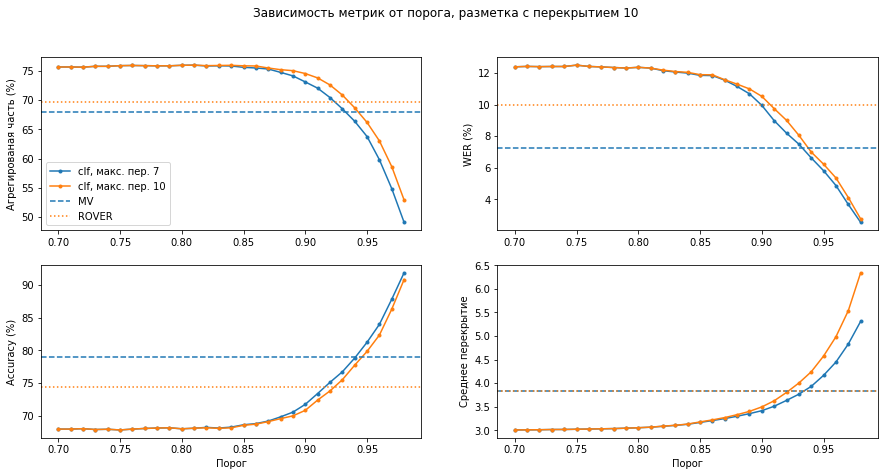

In [36]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, разметка с перекрытием 10')
plt.subplot(221)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_clf_new_assistant_true.png")
plt.show()

In [37]:
len(data_assistant_test_valid)

3486

In [38]:
from scipy.stats import norm

In [39]:
def err(value, n, conf=0.95):
    z = norm.ppf(conf)
    return z * np.sqrt(value * (1 - value) / n)

In [40]:
scores_clf_assistant_new_max_cost_7[:, 1]

array([0.75645439, 0.75645439, 0.75616753, 0.75760184, 0.75760184,
       0.75874928, 0.75903614, 0.75874928, 0.75846242, 0.75846242,
       0.75932301, 0.75960987, 0.75817556, 0.75846242, 0.75817556,
       0.75588067, 0.75473322, 0.75301205, 0.74727481, 0.74125072,
       0.73092369, 0.72030981, 0.70424555, 0.68502582, 0.66379805,
       0.63769363, 0.59810671, 0.54876649, 0.49110729])

In [41]:
test_words_count = [
    len(row['text'].split()) for row in data_assistant_test_valid
]
test_words_count = sum(test_words_count)

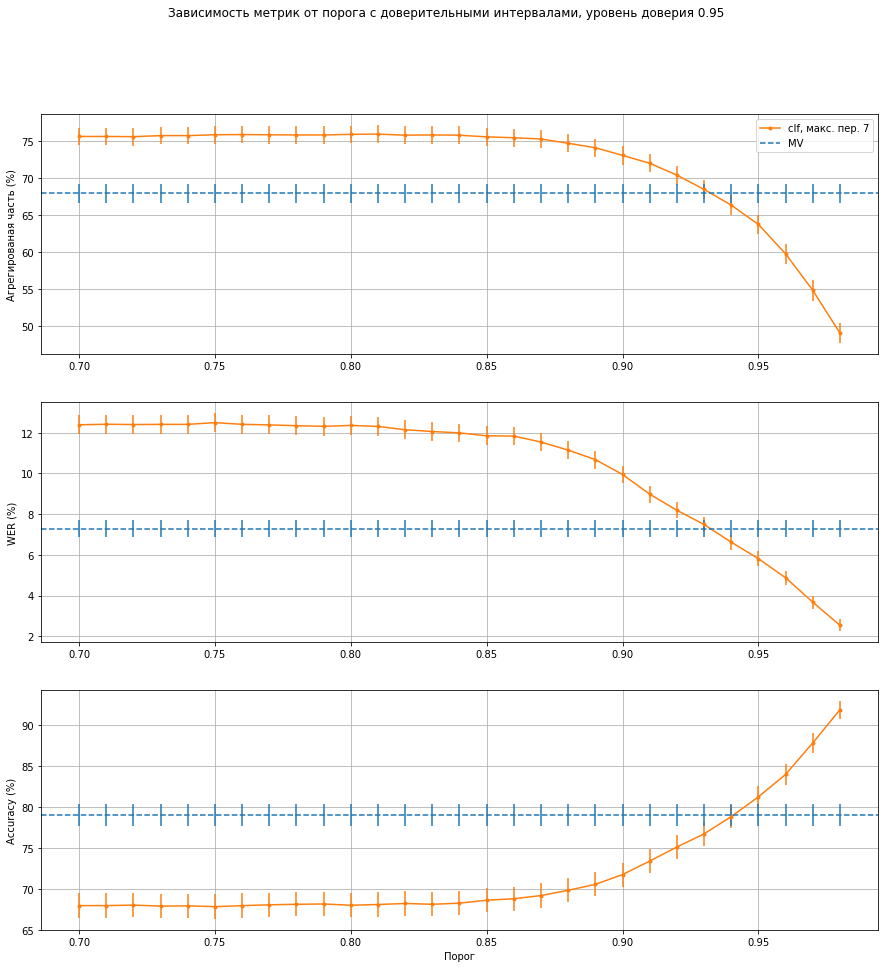

In [42]:
conf = 0.95

plt.figure(figsize=(15,15))
plt.suptitle('Зависимость метрик от порога с доверительными интервалами, уровень доверия {}'.format(conf))
plt.subplot(311)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 1] * 100,
            [err(val, len(data_assistant_test_valid), conf=conf) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:, 1]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[0] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            [err(val, len(data_assistant_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[0]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.ylabel('Агрегированая часть (%)')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 2] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 2] * 100,
            [err(val[2], val[5], conf=conf) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[1] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            [err(val, prod_agg_metrics[4], conf=conf) * 100 for val in 
            [prod_agg_metrics[1]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 3] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 3] * 100,
            [err(metrics[3], metrics[1] * len(data_assistant_test_valid), conf=conf) * 100 for metrics in
            scores_clf_assistant_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[2] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            yerr=[err(val, prod_agg_metrics[0] * len(data_assistant_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[2]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.savefig("metrics_conf_int_assistant_true.png")
plt.show()

In [43]:
scores_clf_assistant_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_assistant_new_max_cost_7.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_7 = np.array(scores_clf_assistant_new_max_cost_7)

0.7
Aggregated: 75.6454%
WER: 12.3916%
Accuracy: 67.9560%
Mean overlap: 3.007
0.71
Aggregated: 75.6454%
WER: 12.4178%
Accuracy: 67.9560%
Mean overlap: 3.009
0.72
Aggregated: 75.6168%
WER: 12.4038%
Accuracy: 68.0197%
Mean overlap: 3.011
0.73
Aggregated: 75.7602%
WER: 12.4124%
Accuracy: 67.8910%
Mean overlap: 3.016
0.74
Aggregated: 75.7602%
WER: 12.4124%
Accuracy: 67.9288%
Mean overlap: 3.017
0.75
Aggregated: 75.8749%
WER: 12.4981%
Accuracy: 67.8261%
Mean overlap: 3.022
0.76
Aggregated: 75.9036%
WER: 12.4147%
Accuracy: 67.9516%
Mean overlap: 3.027
0.77
Aggregated: 75.8749%
WER: 12.3859%
Accuracy: 68.0529%
Mean overlap: 3.031
0.7799999999999999
Aggregated: 75.8462%
WER: 12.3479%
Accuracy: 68.1165%
Mean overlap: 3.036
0.7899999999999999
Aggregated: 75.8462%
WER: 12.3155%
Accuracy: 68.1543%
Mean overlap: 3.044
0.7999999999999999
Aggregated: 75.9323%
WER: 12.3591%
Accuracy: 68.0015%
Mean overlap: 3.054
0.8099999999999999
Aggregated: 75.9610%
WER: 12.3119%
Accuracy: 68.0891%
Mean overlap: 3.0

In [44]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_prod)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833


In [45]:
def aggregate_rover_with_clf_and_empty_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [46]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    aggregated_empty = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if hyp == '':
            aggregated_empty += 1
            if row['text'] != '':
                false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if aggregated_empty:
        false_empty /= aggregated_empty
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}\nEmpty error part: {:.4%}".format(
            aggregated_part, wer, accuracy, cost, false_empty
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [47]:
def evaluate_metrics_clf_and_empty_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_and_empty_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [48]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.92,
                                    max_cost=7)

Aggregated: 93.3735%
WER: 9.0156%
Accuracy: 79.8464%
Mean overlap: 3.633
Empty error part: 5.6250%


(0.9337349397590361,
 0.09015560247087341,
 0.7984639016897082,
 3.6333907056798624,
 12789,
 0.05625)

In [49]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.92,
                                    max_cost=7)

Aggregated: 70.4246%
WER: 8.1900%
Accuracy: 75.1120%
Mean overlap: 3.633
Empty error part: 0.0000%


(0.704245553643144,
 0.0818999526589869,
 0.7511201629327903,
 3.6333907056798624,
 12674,
 0.0)

In [50]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.93,
                                    max_cost=7)

Aggregated: 91.1933%
WER: 8.2077%
Accuracy: 81.2205%
Mean overlap: 3.765
Empty error part: 5.1833%


(0.9119334480780263,
 0.08207691687494961,
 0.8122050959421202,
 3.7653471026965004,
 12403,
 0.051833122629582805)

In [51]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.93,
                                    max_cost=7)

Aggregated: 68.5026%
WER: 7.4917%
Accuracy: 76.7169%
Mean overlap: 3.765
Empty error part: 0.0000%


(0.685025817555938,
 0.07491671406516616,
 0.7671691792294807,
 3.7653471026965004,
 12307,
 0.0)

In [60]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.935,
                                    max_cost=7)

Aggregated: 67.5273%
WER: 7.1364%
Accuracy: 77.7400%
Mean overlap: 3.845
Empty error part: 0.0000%


(0.6752725186460127,
 0.07136382365059744,
 0.7774001699235344,
 3.844807802639128,
 12135,
 0.0)

In [52]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.94,
                                    max_cost=7)

Aggregated: 88.5542%
WER: 7.2065%
Accuracy: 83.0904%
Mean overlap: 3.931
Empty error part: 4.1397%


(0.8855421686746988,
 0.07206531700408231,
 0.8309037900874635,
 3.9305794606999425,
 12003,
 0.04139715394566624)

In [53]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.94,
                                    max_cost=7)

Aggregated: 66.3798%
WER: 6.6231%
Accuracy: 78.8245%
Mean overlap: 3.931
Empty error part: 0.0000%


(0.663798049340218,
 0.06623071763916834,
 0.7882454624027658,
 3.9305794606999425,
 11928,
 0.0)

In [54]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.95,
                                    max_cost=7)

Aggregated: 63.7694%
WER: 5.8111%
Accuracy: 81.2416%
Mean overlap: 4.165
Empty error part: 0.0000%


(0.6376936316695353,
 0.058110955056179775,
 0.8124156545209177,
 4.164658634538153,
 11392,
 0.0)

In [59]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.948,
                                    max_cost=7)

Aggregated: 64.1997%
WER: 5.9865%
Accuracy: 80.7417%
Mean overlap: 4.12
Empty error part: 0.0000%


(0.6419965576592083,
 0.05986465382613222,
 0.8074173369079535,
 4.119621342512909,
 11526,
 0.0)

In [130]:
2248/len(data_assistant_test_valid)

0.6448651749856569

In [56]:
clf_new.save_model("assistant_2019-09-23_prototype.clf")

In [61]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.948,
                                    max_cost=7)

Aggregated: 85.6569%
WER: 6.4814%
Accuracy: 84.7957%
Mean overlap: 4.12
Empty error part: 3.0749%


(0.8565691336775674,
 0.06481401570725813,
 0.8479571332886805,
 4.119621342512909,
 11587,
 0.03074866310160428)

In [64]:
sum(1 for x in data_assistant_test_valid if x["text"] == "")/len(data_assistant_test_valid) * 100.0

22.57601835915089

In [113]:
x = aggregate_rover_with_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.948,
                                    max_cost=7)

In [128]:
sum([i.cost >= 7 for i in list(x.values())])

609

In [129]:
len(data_assistant_test_valid)

3486

In [71]:
aggregated_keys = set(key for key, value in x.items() if value.confidence > 0.948)

In [74]:
test_agregated_part = [x for x in data_assistant_test_valid if x["mds_key"] in aggregated_keys]

In [76]:
evaluate_metrics_clf_(test_agregated_part, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.948,
                                    max_cost=7)

Aggregated: 100.0000%
WER: 5.9865%
Accuracy: 80.7417%
Mean overlap: 3.458
Empty error part: 0.0000%


(1.0, 0.05986465382613222, 0.8074173369079535, 3.4575513851653263, 11526, 0.0)

In [78]:
def aggregate_prod_plus(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    # if text != "" and text_rate >= 2:
    conf = text_rate * 1.0 / sum(texts.values())
    #else:
    #    text = None
    #    conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [80]:
evaluate_metrics(test_agregated_part, 'toloka_results', aggregate_prod)

Aggregated: 95.4424%
WER: 5.1191%
Accuracy: 83.7079%
Mean overlap: 3.883


(0.9544235924932976,
 0.051191179366016935,
 0.8370786516853933,
 3.882931188561215,
 10158)

In [79]:
evaluate_metrics(test_agregated_part, 'toloka_results', aggregate_prod_plus)

Aggregated: 100.0000%
WER: 9.5436%
Accuracy: 80.0715%
Mean overlap: 3.883


(1.0, 0.09543640465035572, 0.8007149240393209, 3.882931188561215, 11526)

In [103]:
common_part = [
    row for row in test_agregated_part 
    if aggregate_prod(sorted(row['toloka_results'], key=lambda x: x["submit_ts"])).text is not None
    and aggregate_prod(sorted(row['toloka_results'], key=lambda x: x["submit_ts"])).confidence > 0
]

In [104]:
evaluate_metrics(common_part, 'toloka_results', aggregate_prod)

Aggregated: 100.0000%
WER: 5.1191%
Accuracy: 83.7079%
Mean overlap: 3.831


(1.0, 0.051191179366016935, 0.8370786516853933, 3.831460674157303, 10158)

In [105]:
evaluate_metrics_clf_(common_part, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.948,
                                    max_cost=7)

Aggregated: 100.0000%
WER: 5.0896%
Accuracy: 83.2865%
Mean overlap: 3.387
Empty error part: 0.0000%


(1.0, 0.0508958456389053, 0.8328651685393258, 3.387172284644195, 10158, 0.0)

In [109]:
test_mv_part = [
    row for row in data_assistant_test_valid 
    if aggregate_prod(sorted(row['toloka_results'], key=lambda x: x["submit_ts"])).text is not None
    and aggregate_prod(sorted(row['toloka_results'], key=lambda x: x["submit_ts"])).confidence > 0
]

In [110]:
test_mv_part[0]["text"]

'алиса что такое форма три справка'

In [111]:
yt.write_table("//tmp/edvls/test_mv_part", test_mv_part)

In [112]:
yt.write_table("//tmp/edvls/test_agregated_part", test_agregated_part)